In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata, entropy
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings

Loading data...

--- Processing Season 1 ---


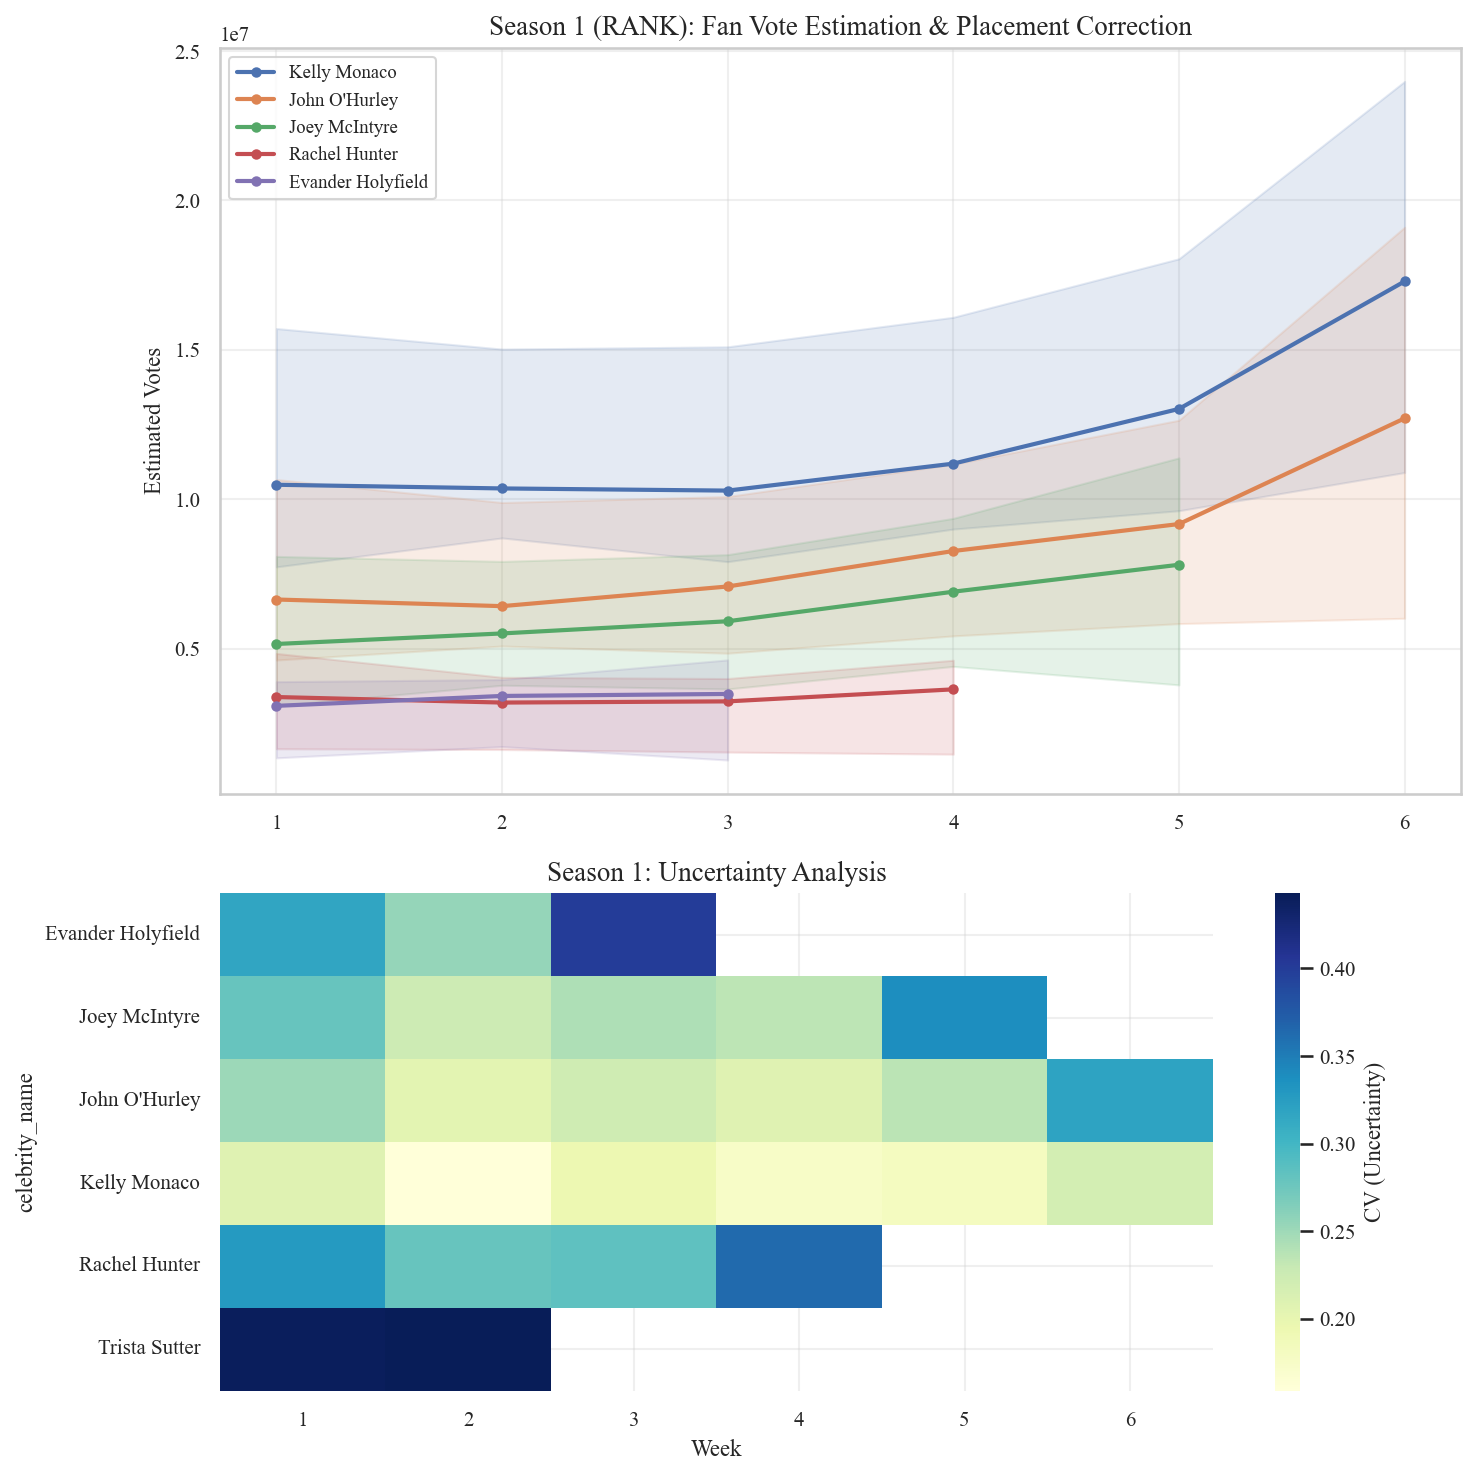


--- Processing Season 2 ---


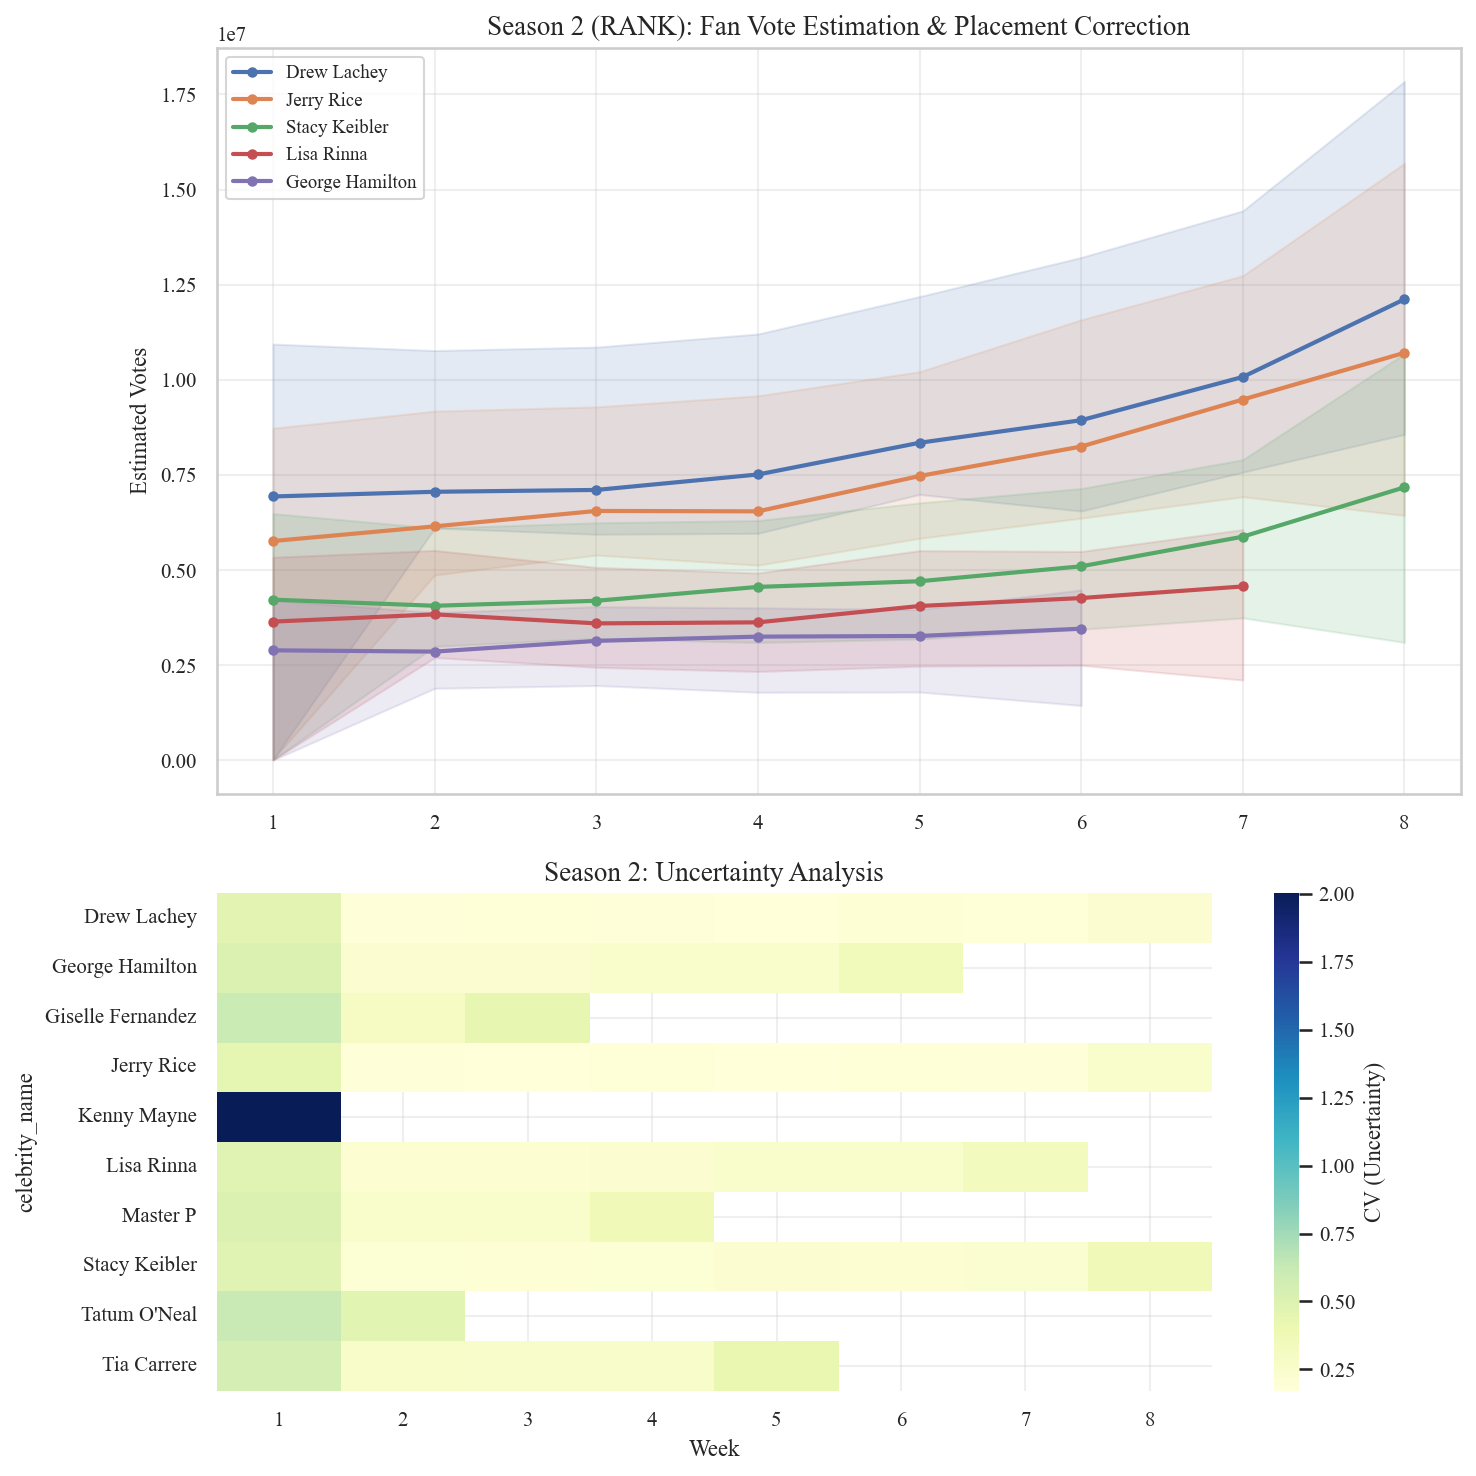


--- Processing Season 3 ---


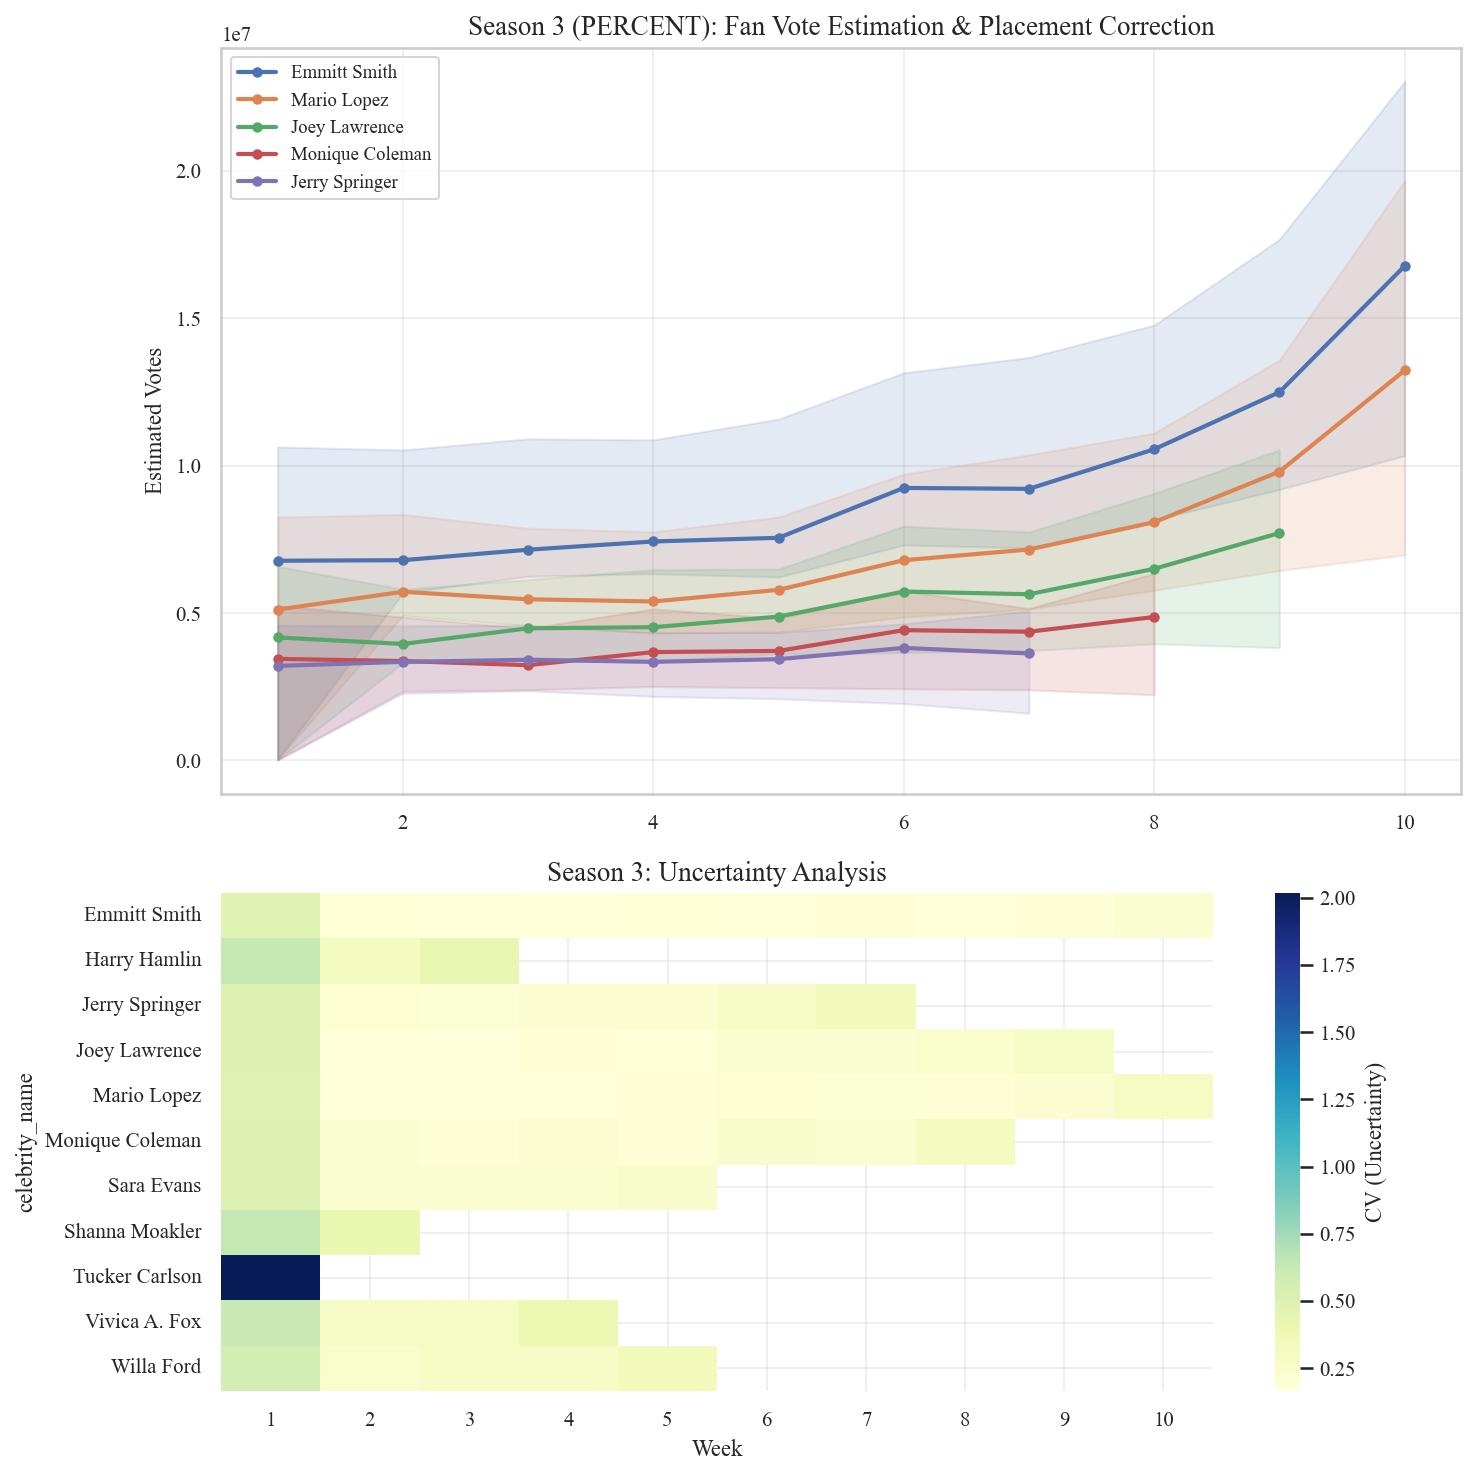


--- Processing Season 4 ---


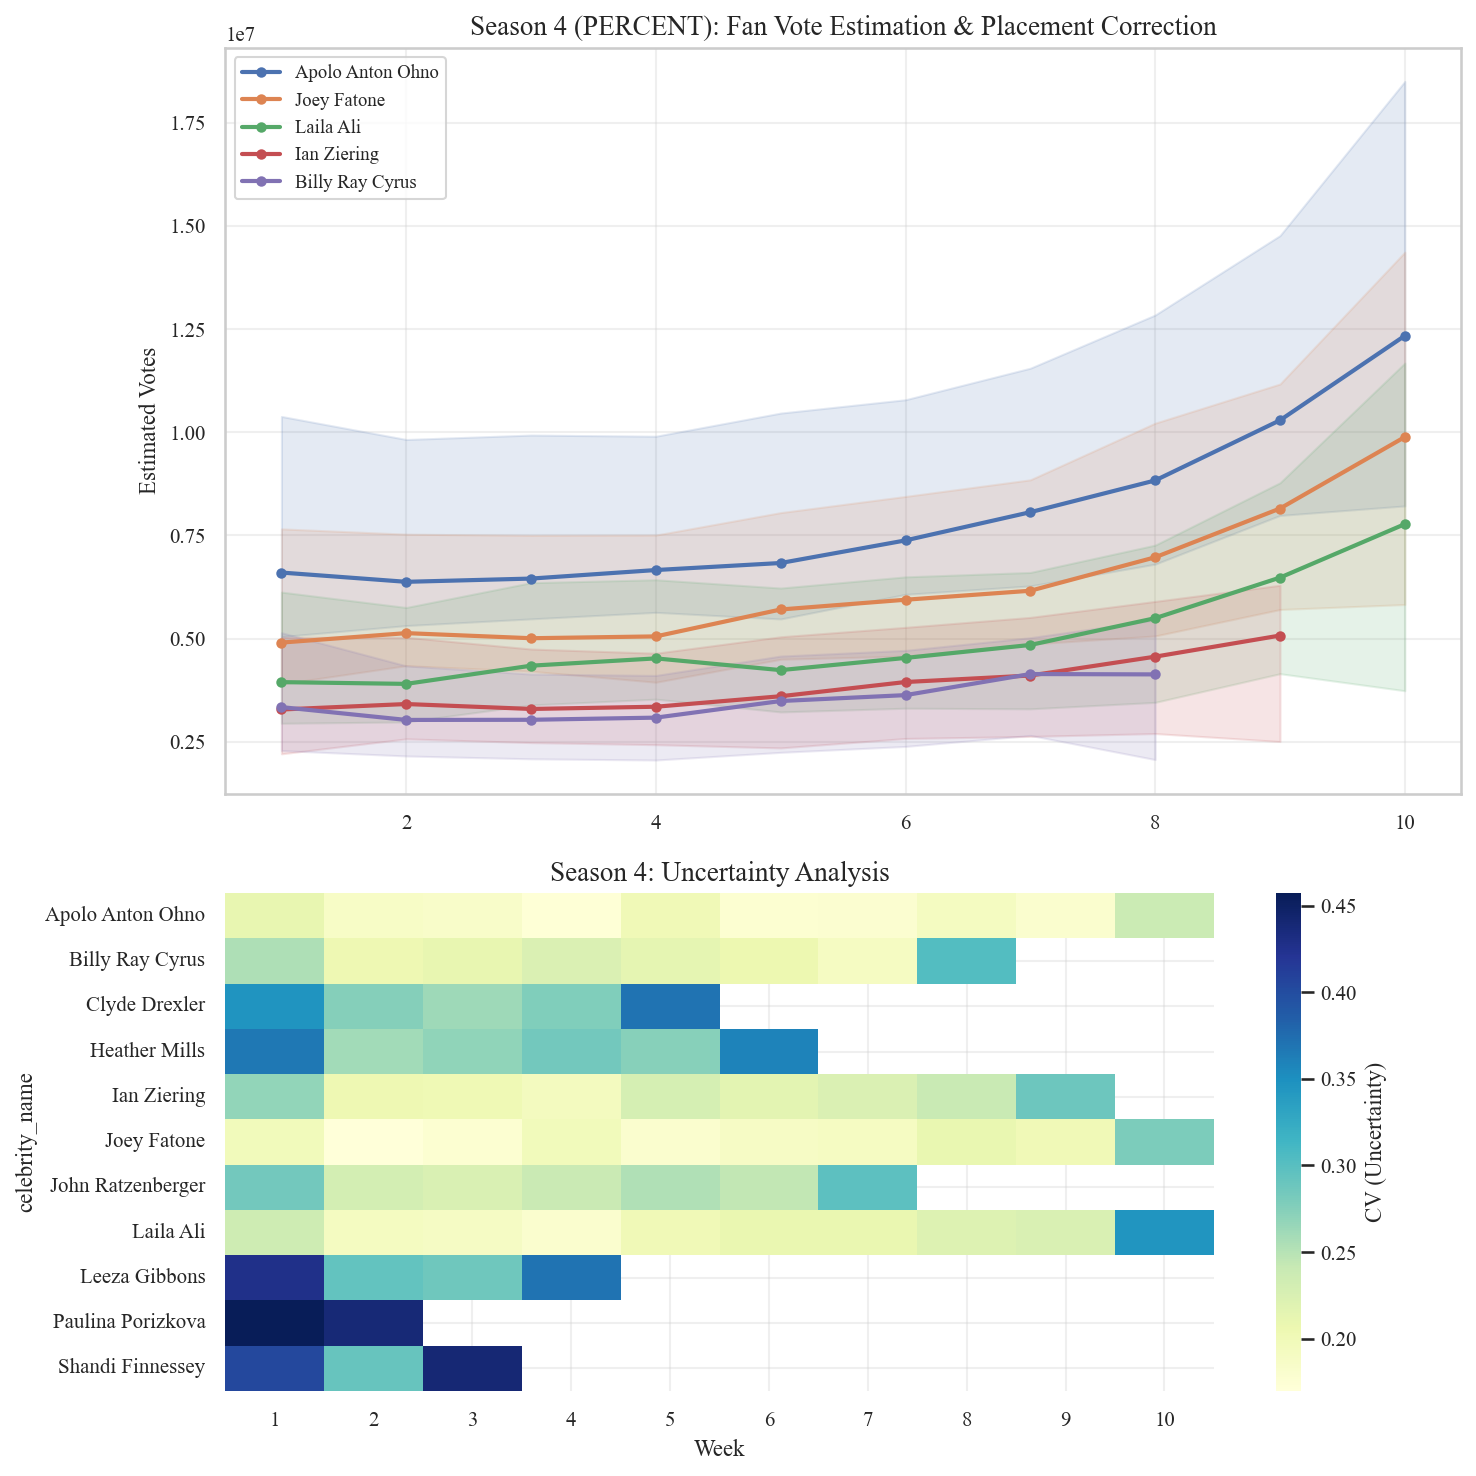


--- Processing Season 5 ---


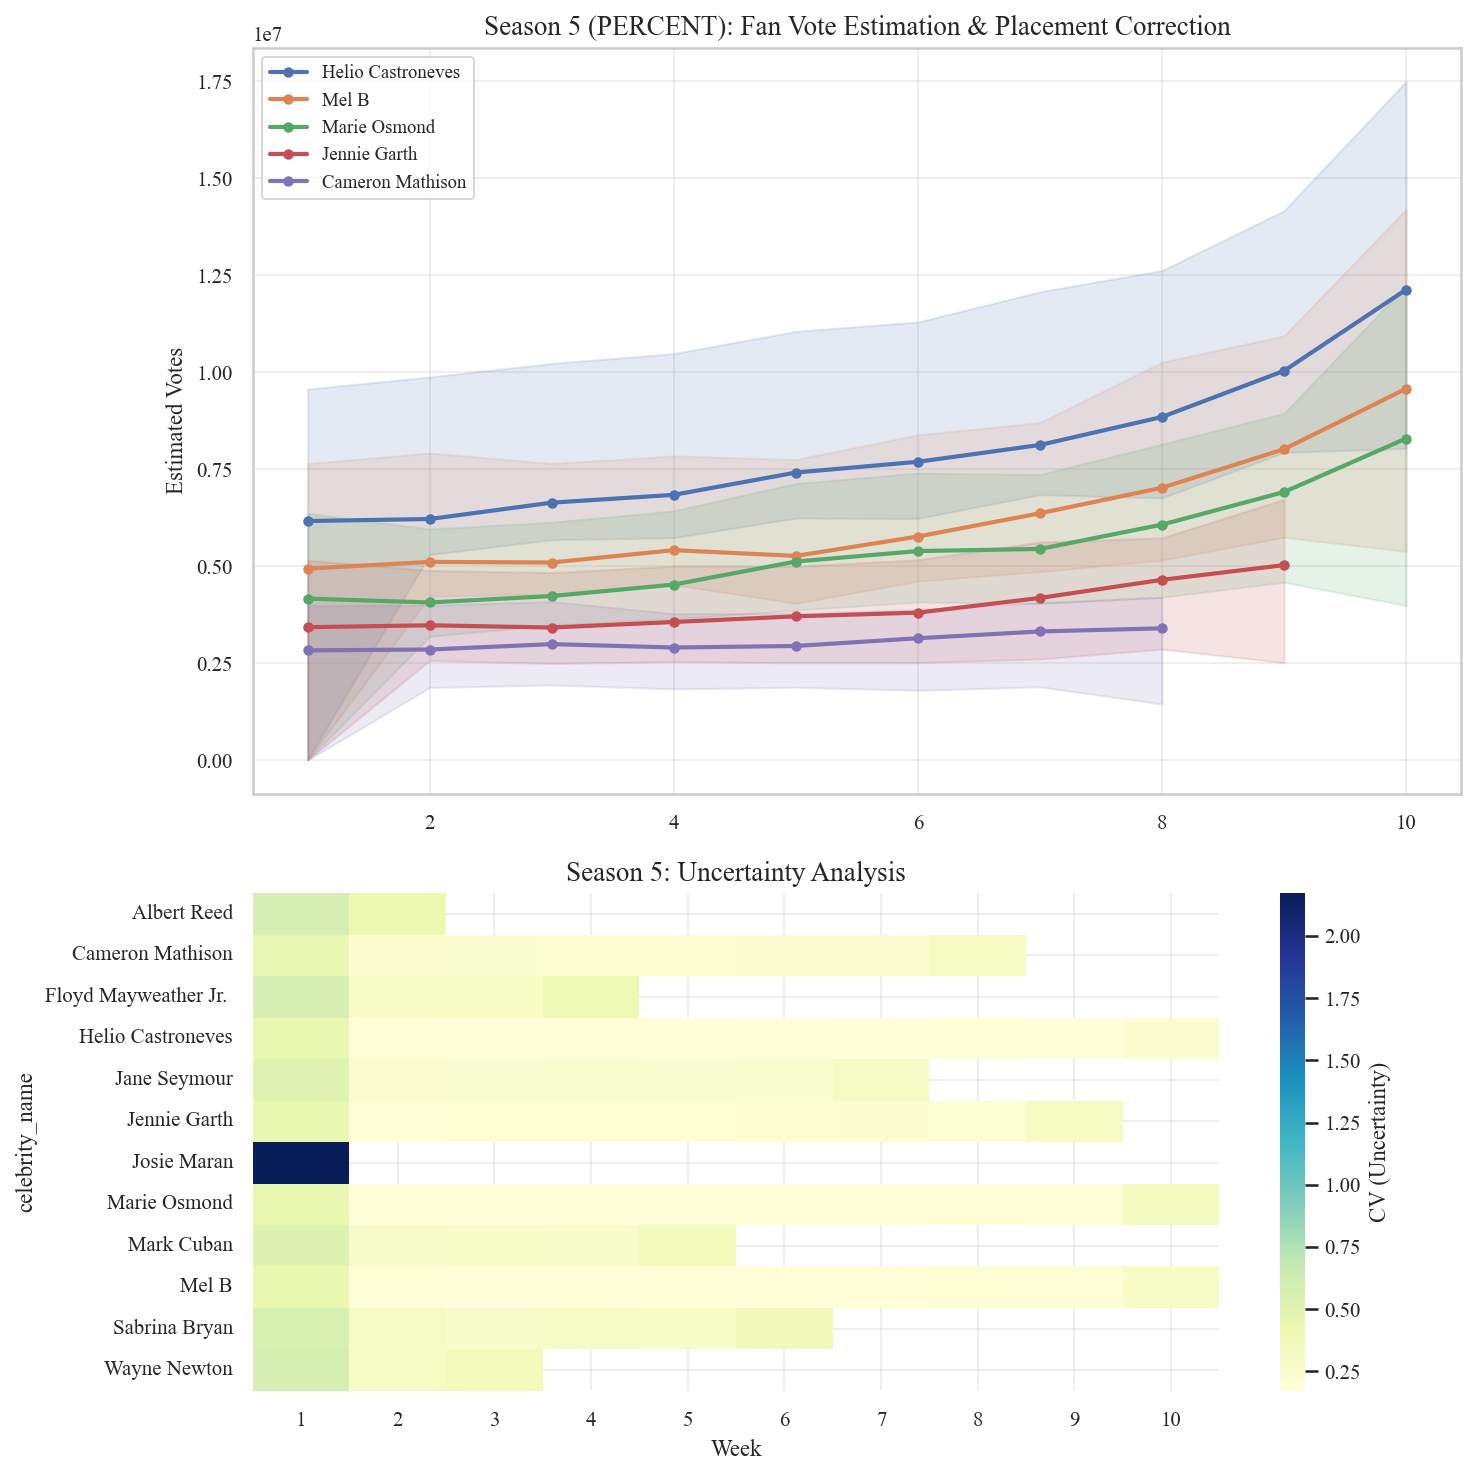


--- Processing Season 6 ---


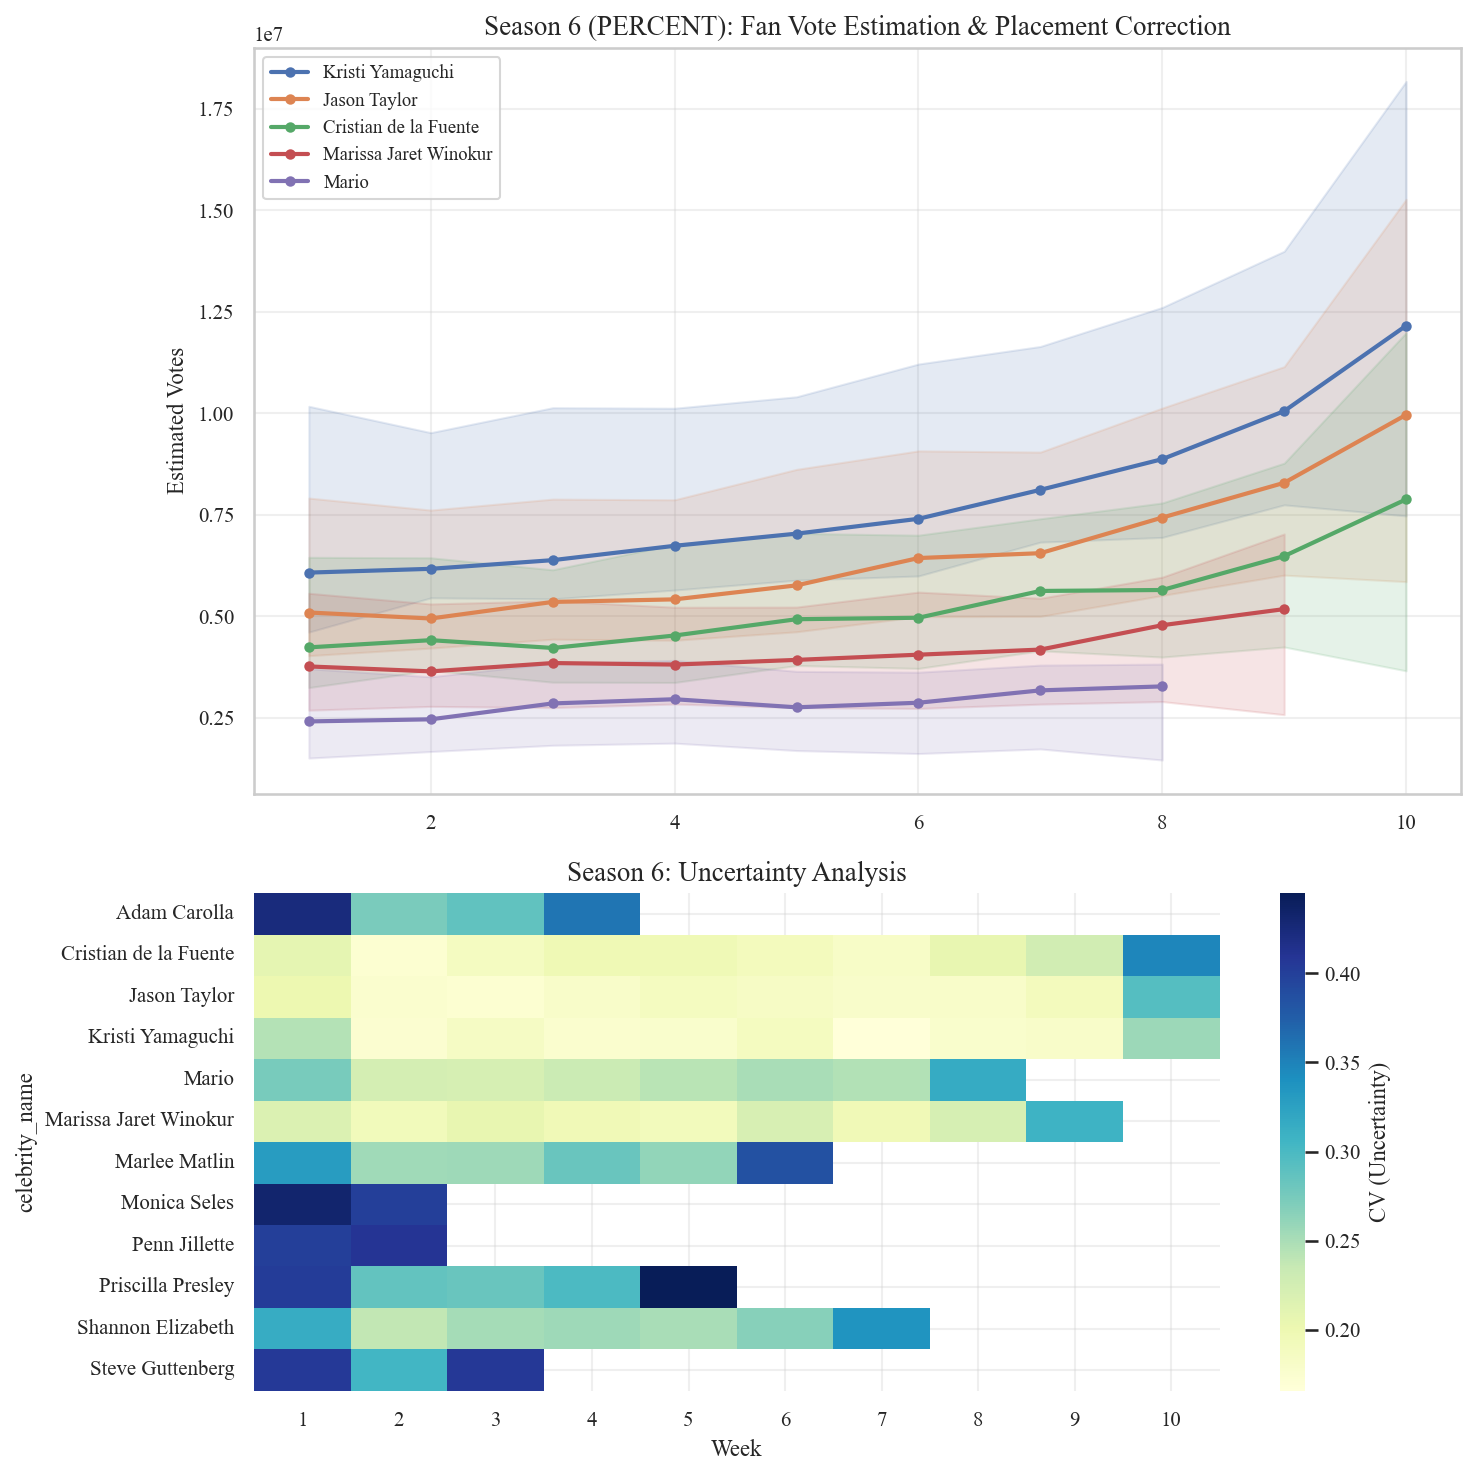


--- Processing Season 7 ---


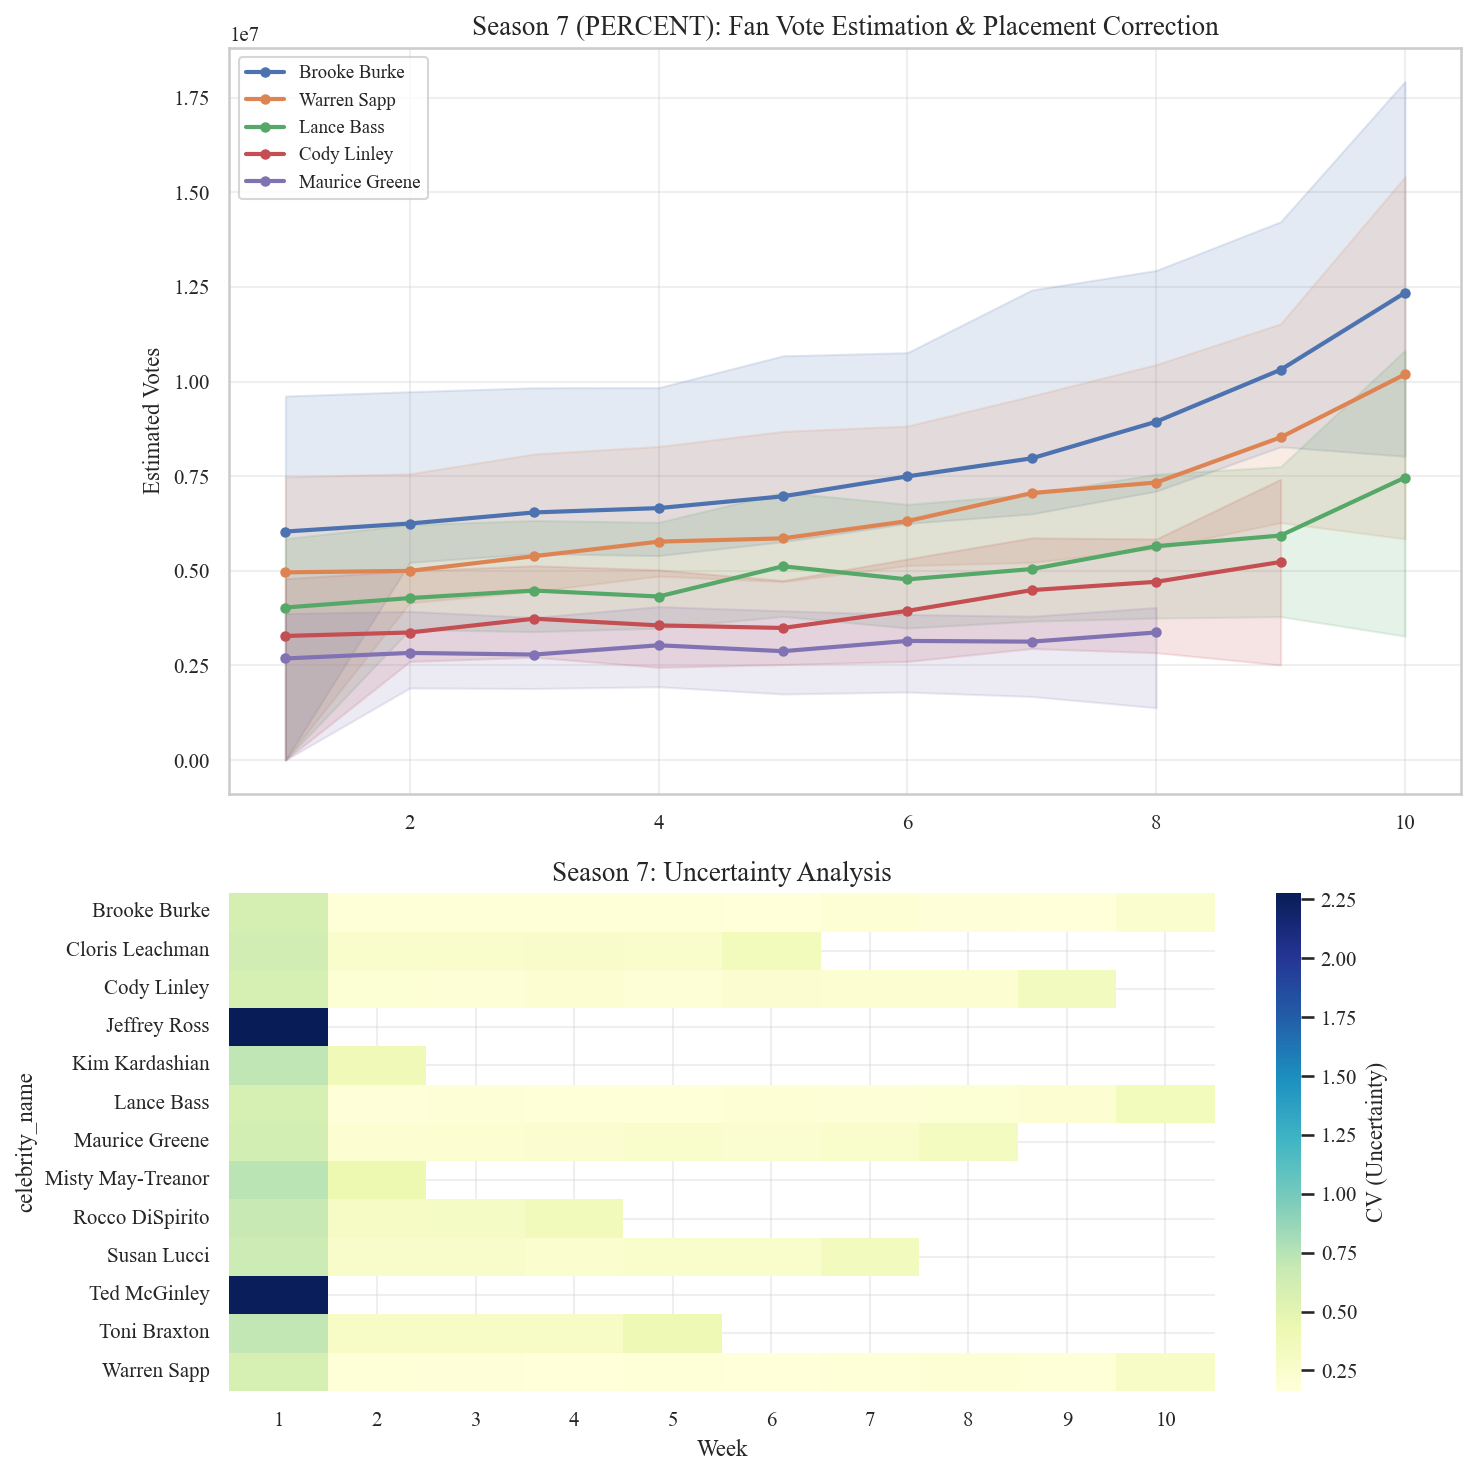


--- Processing Season 8 ---


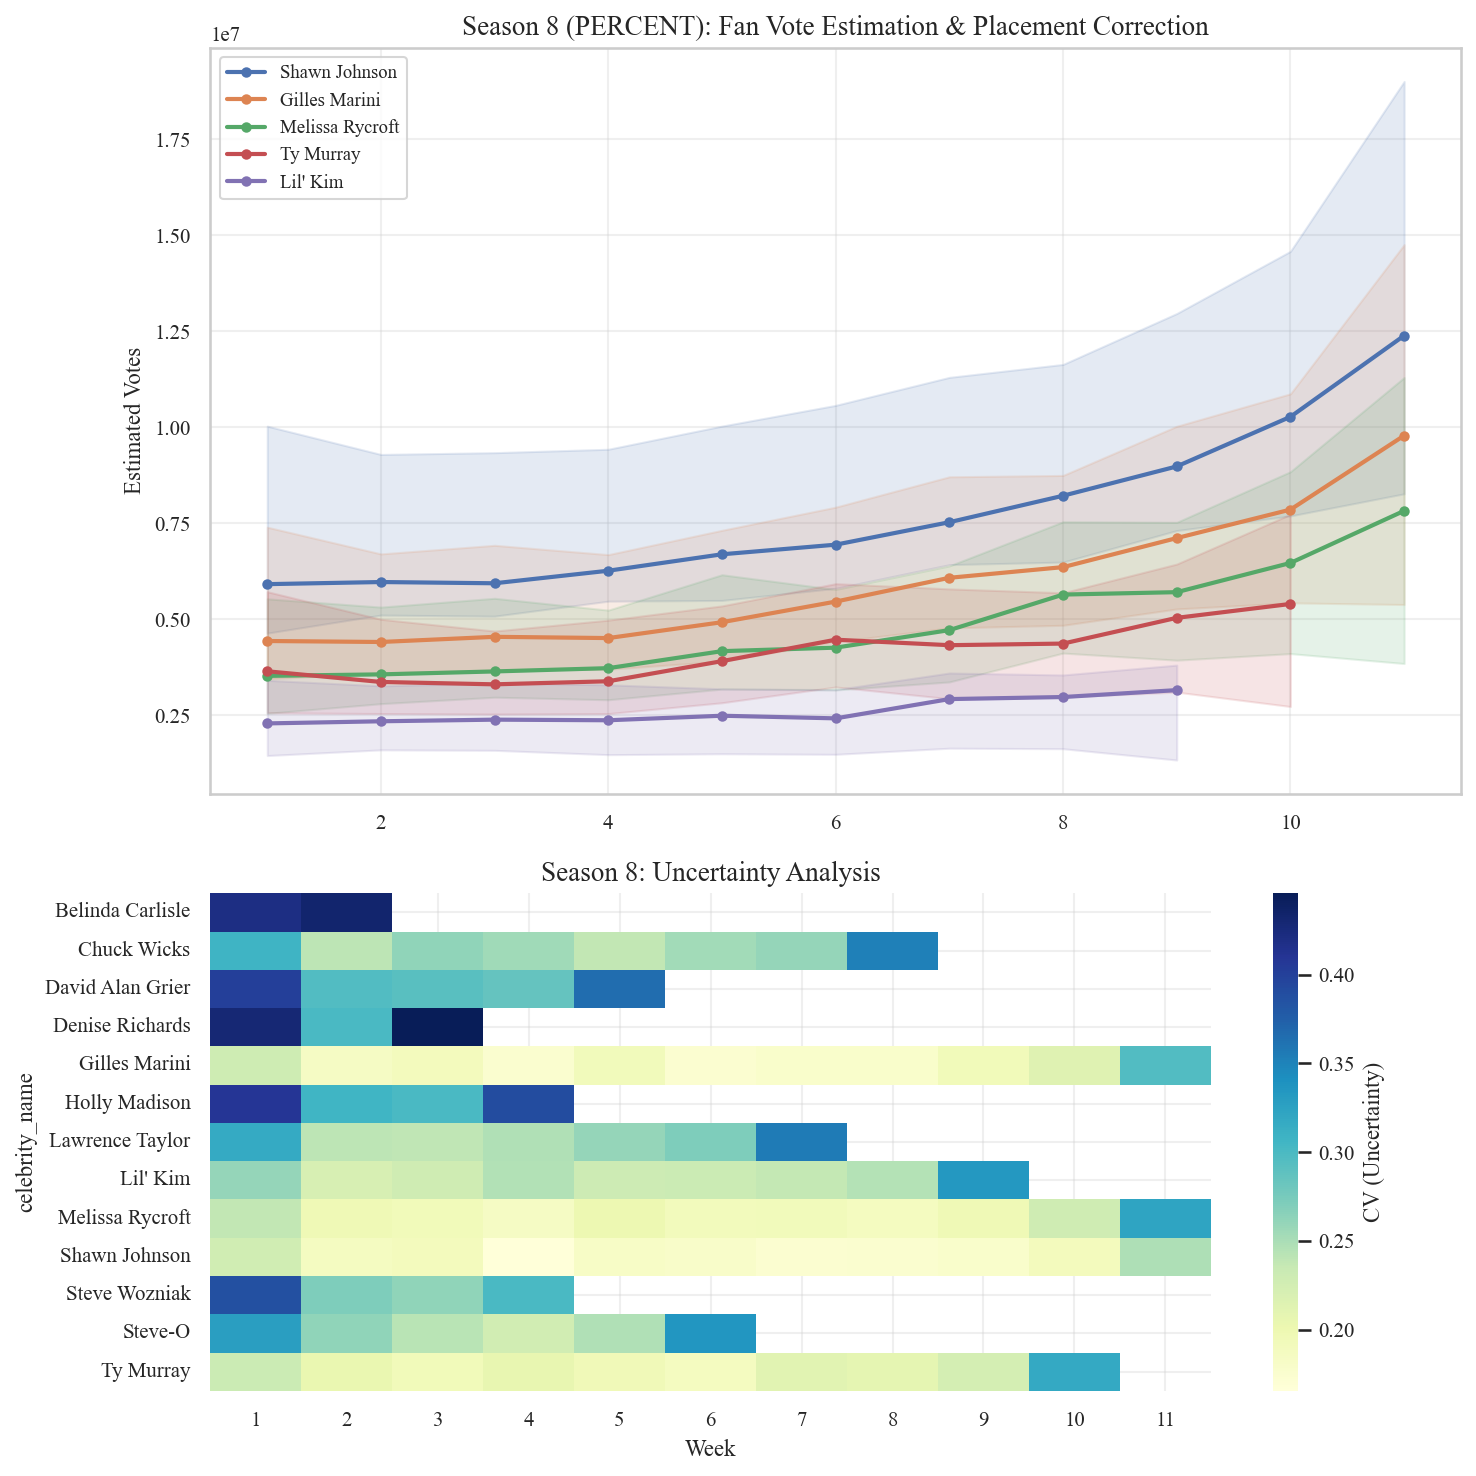


--- Processing Season 9 ---


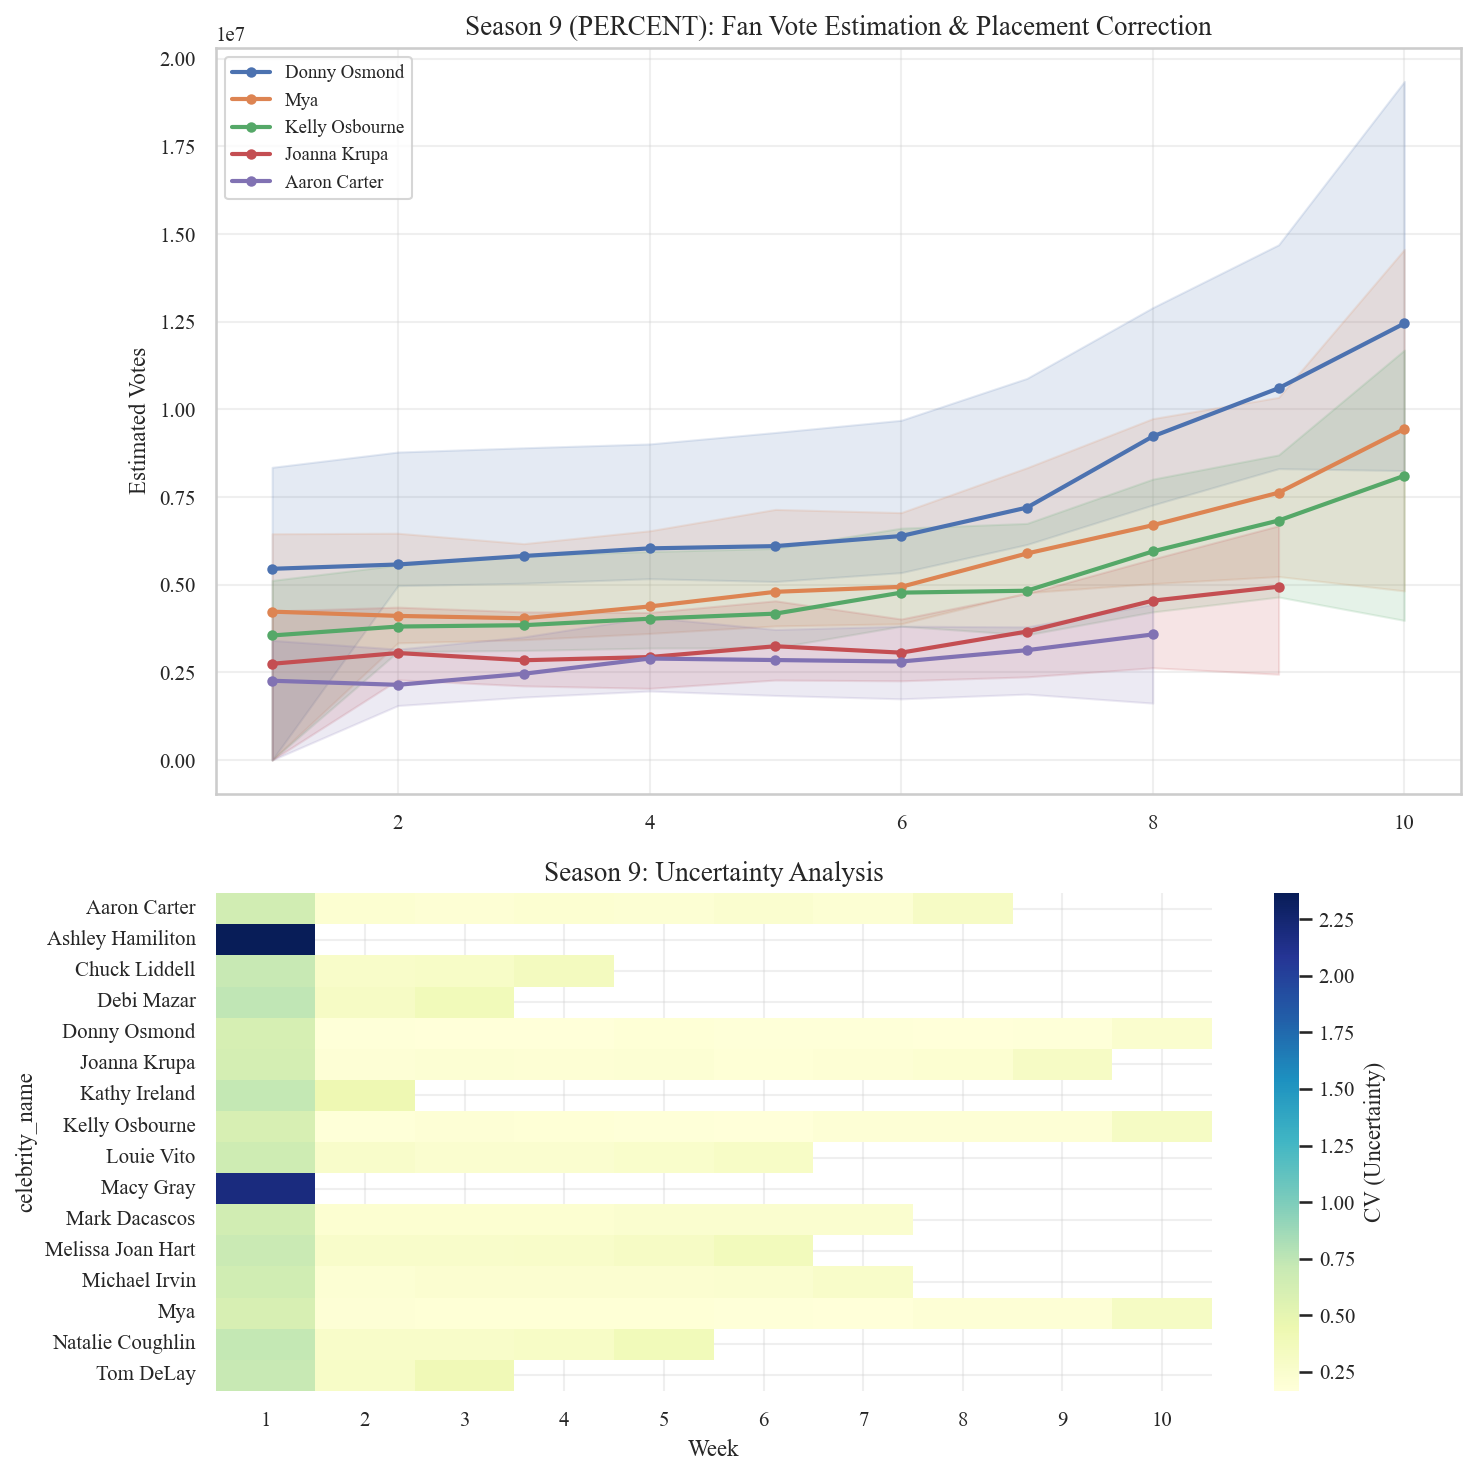


--- Processing Season 10 ---


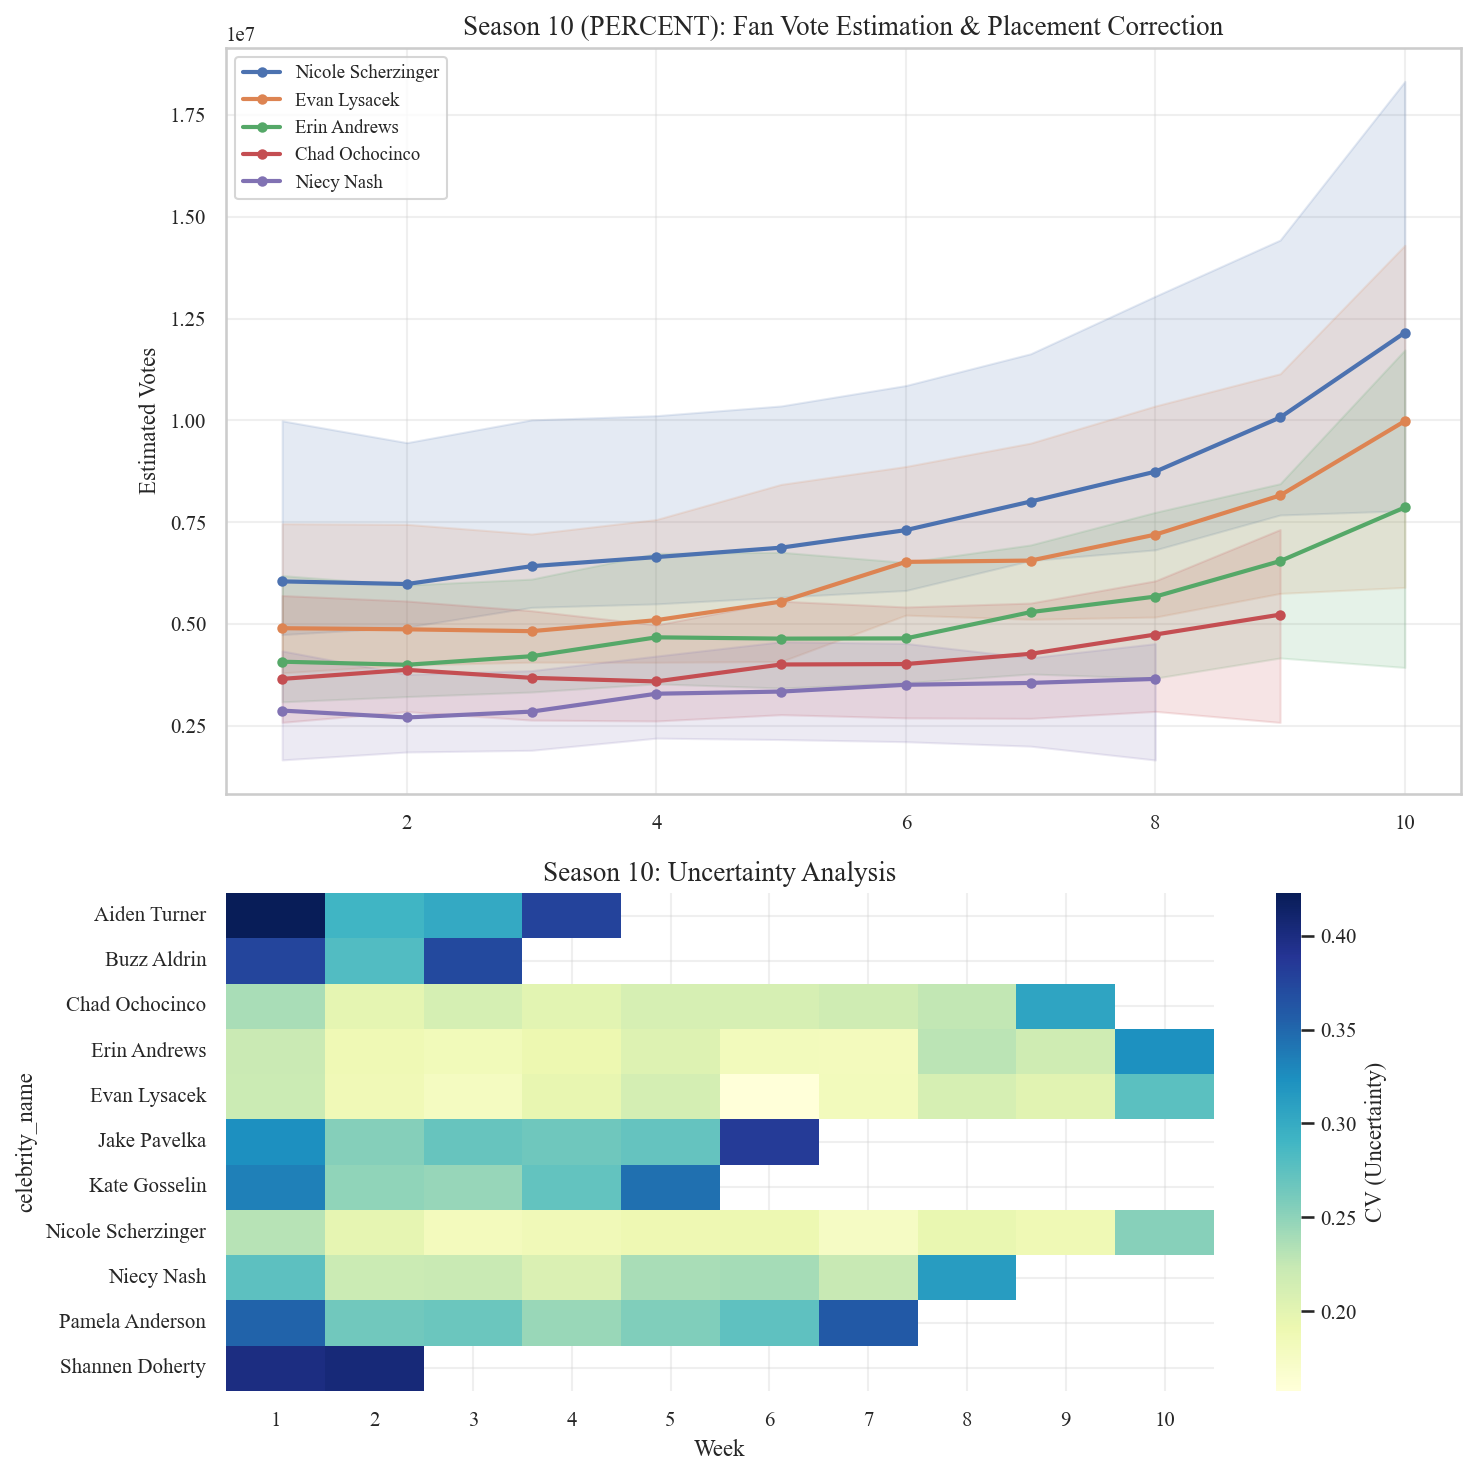


--- Processing Season 11 ---


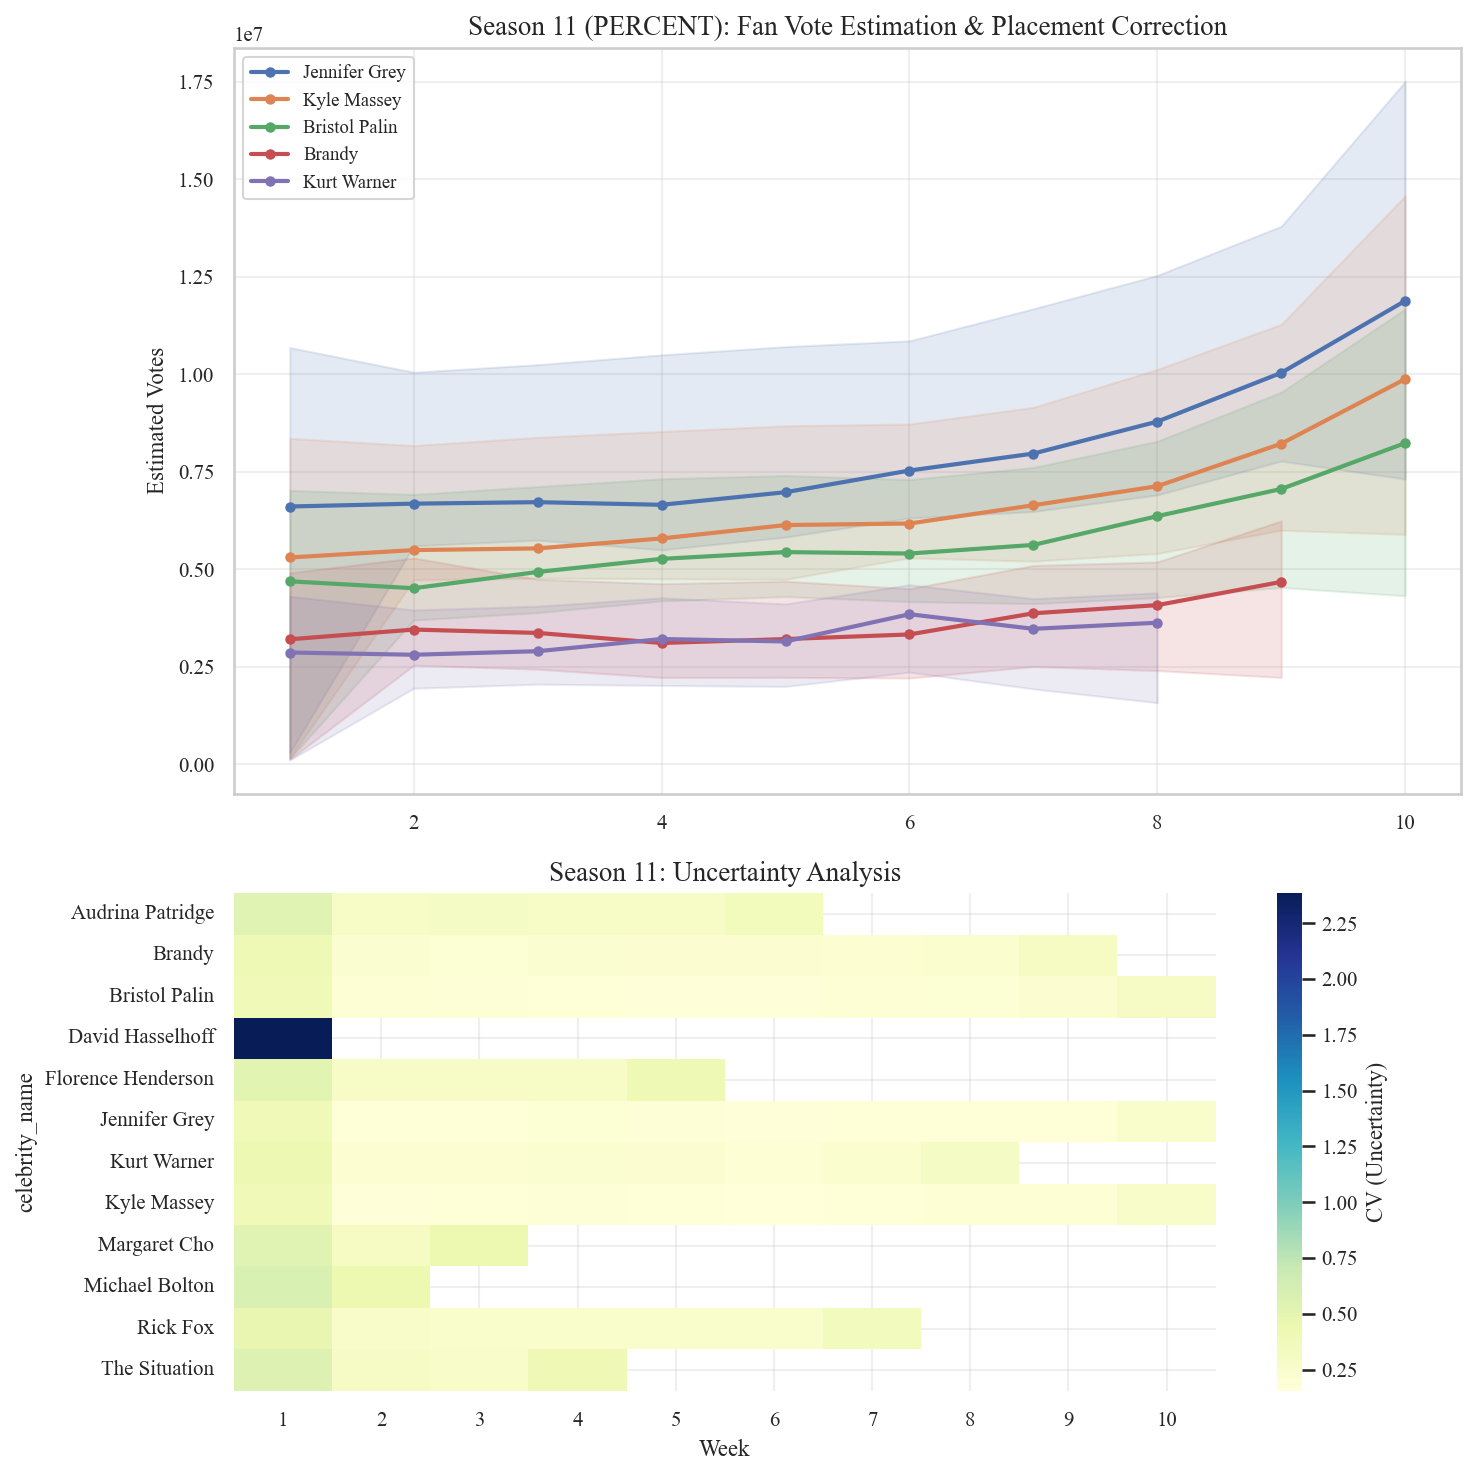


--- Processing Season 12 ---


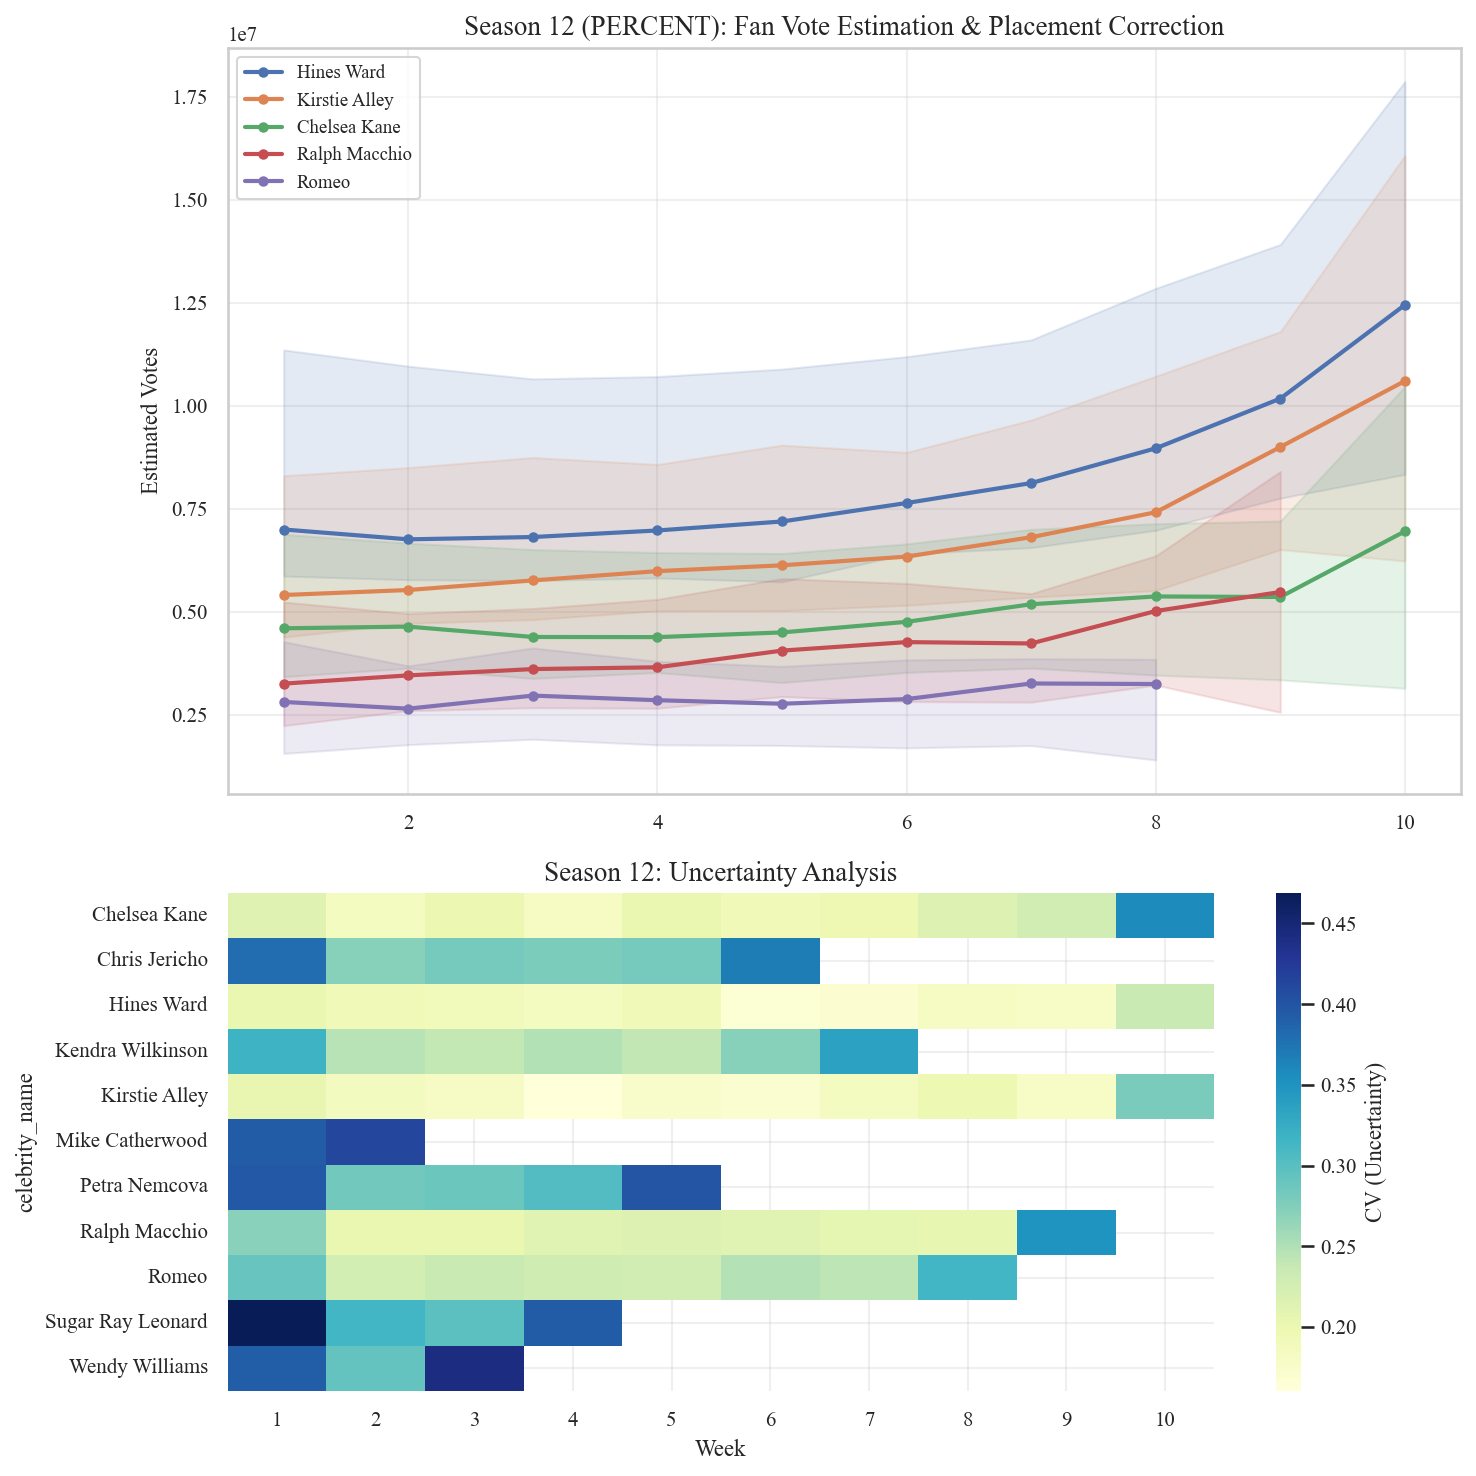


--- Processing Season 13 ---


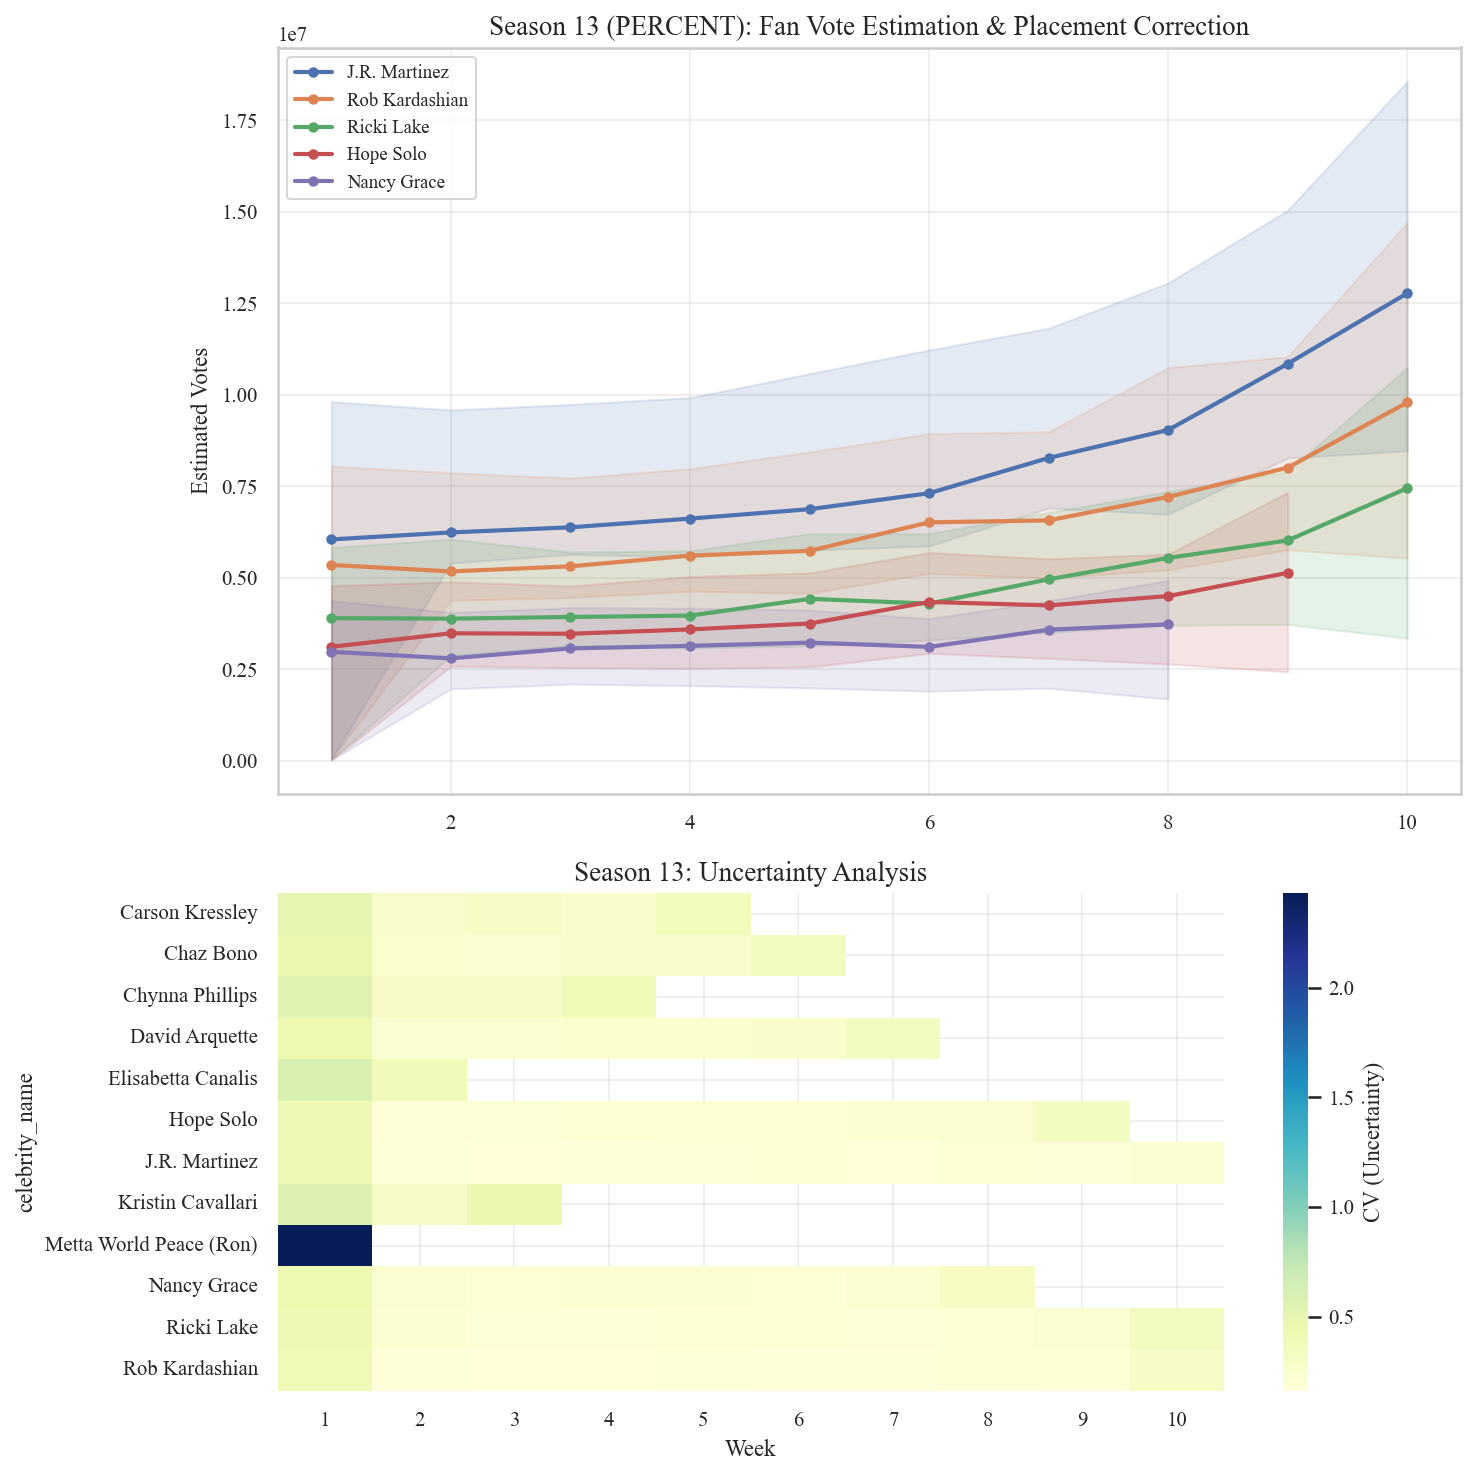


--- Processing Season 14 ---


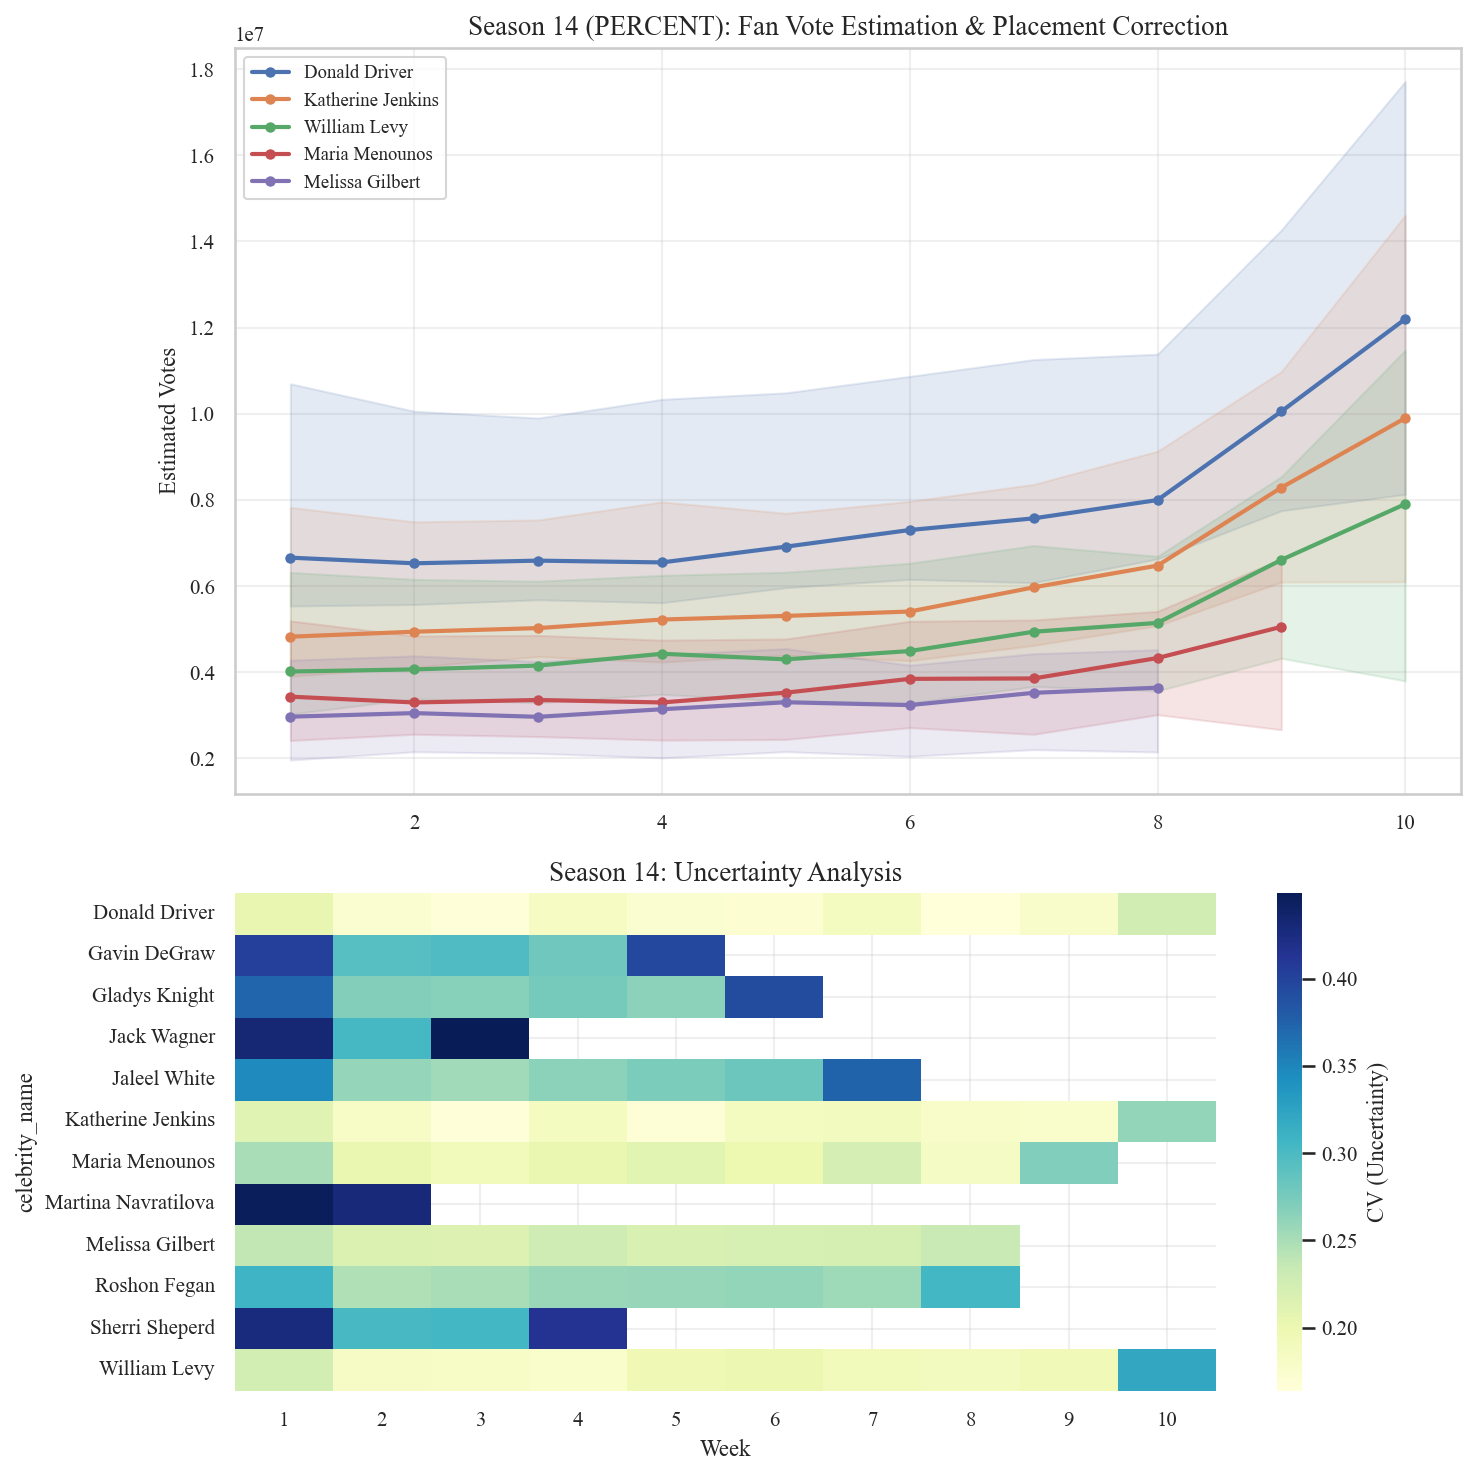


--- Processing Season 15 ---


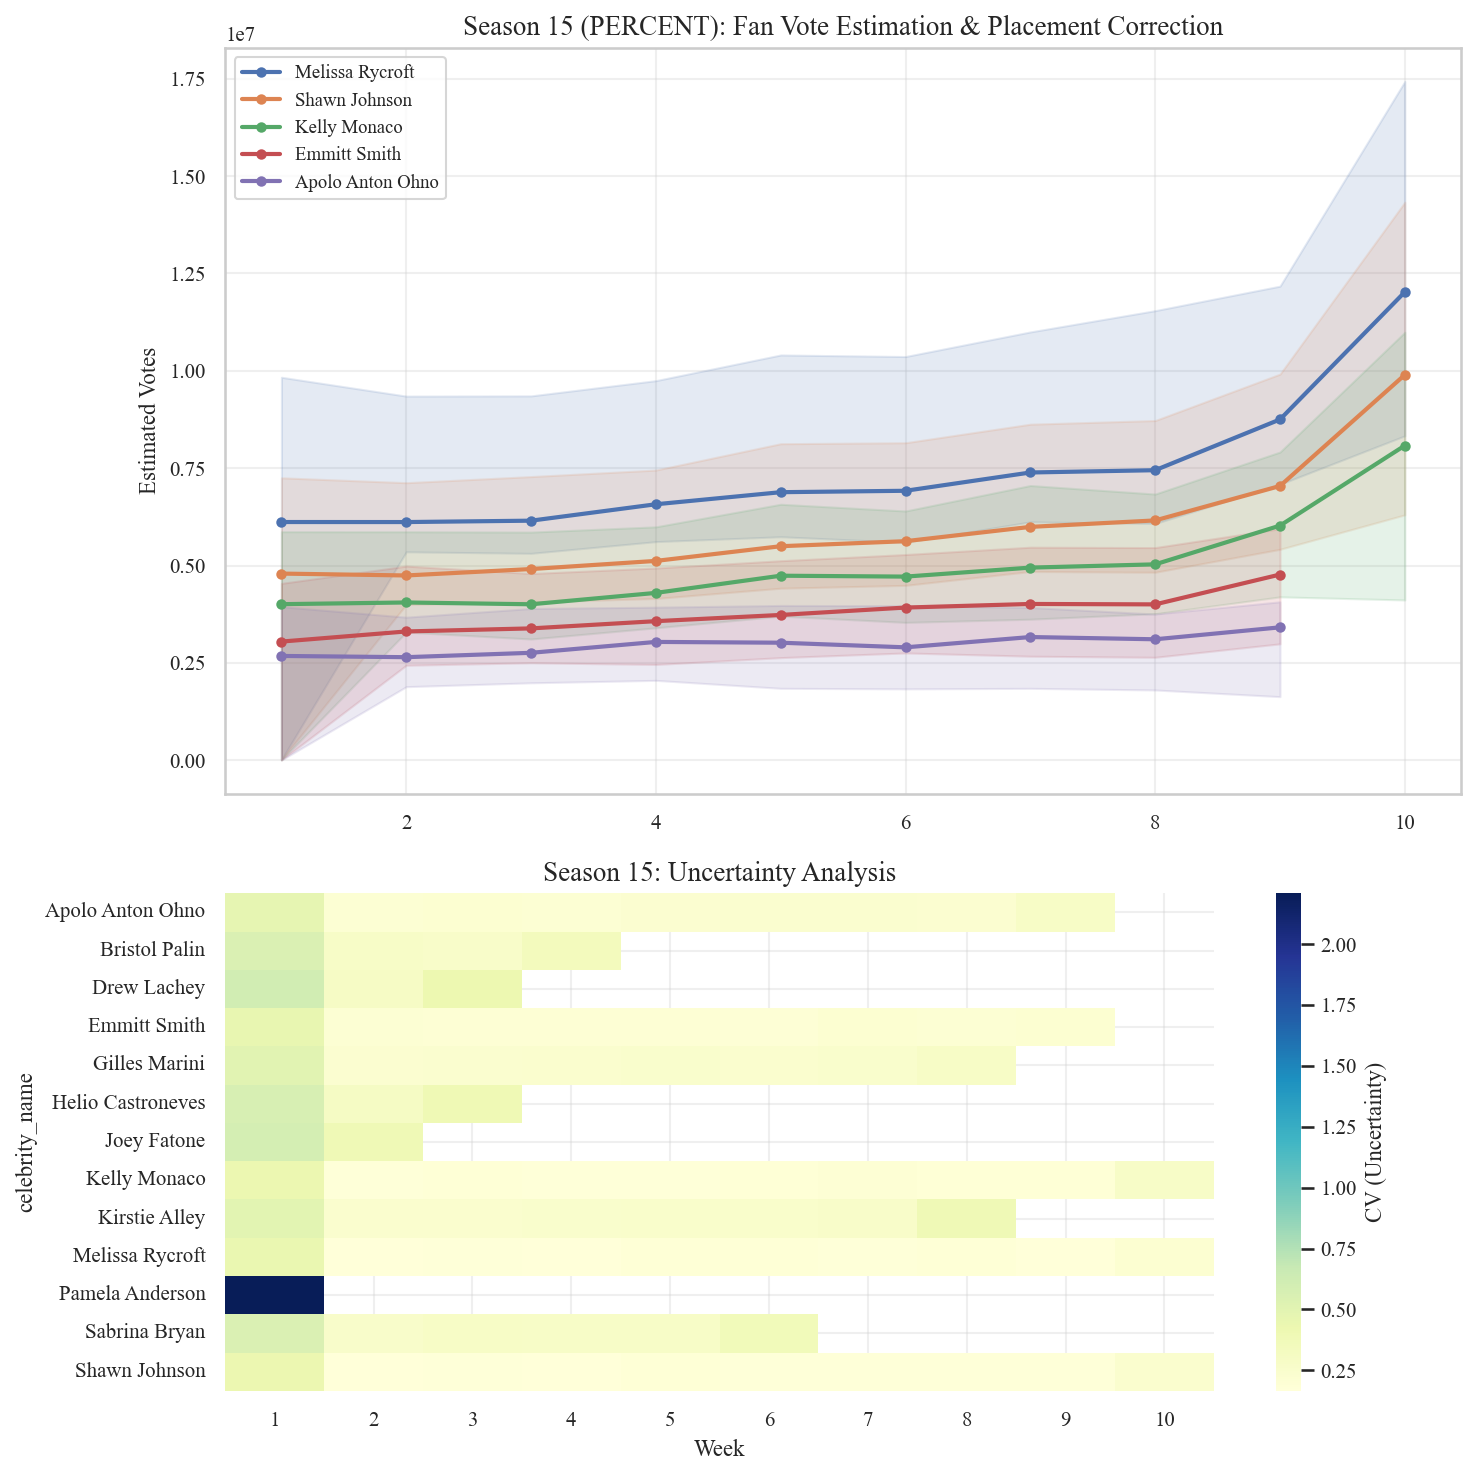


--- Processing Season 16 ---


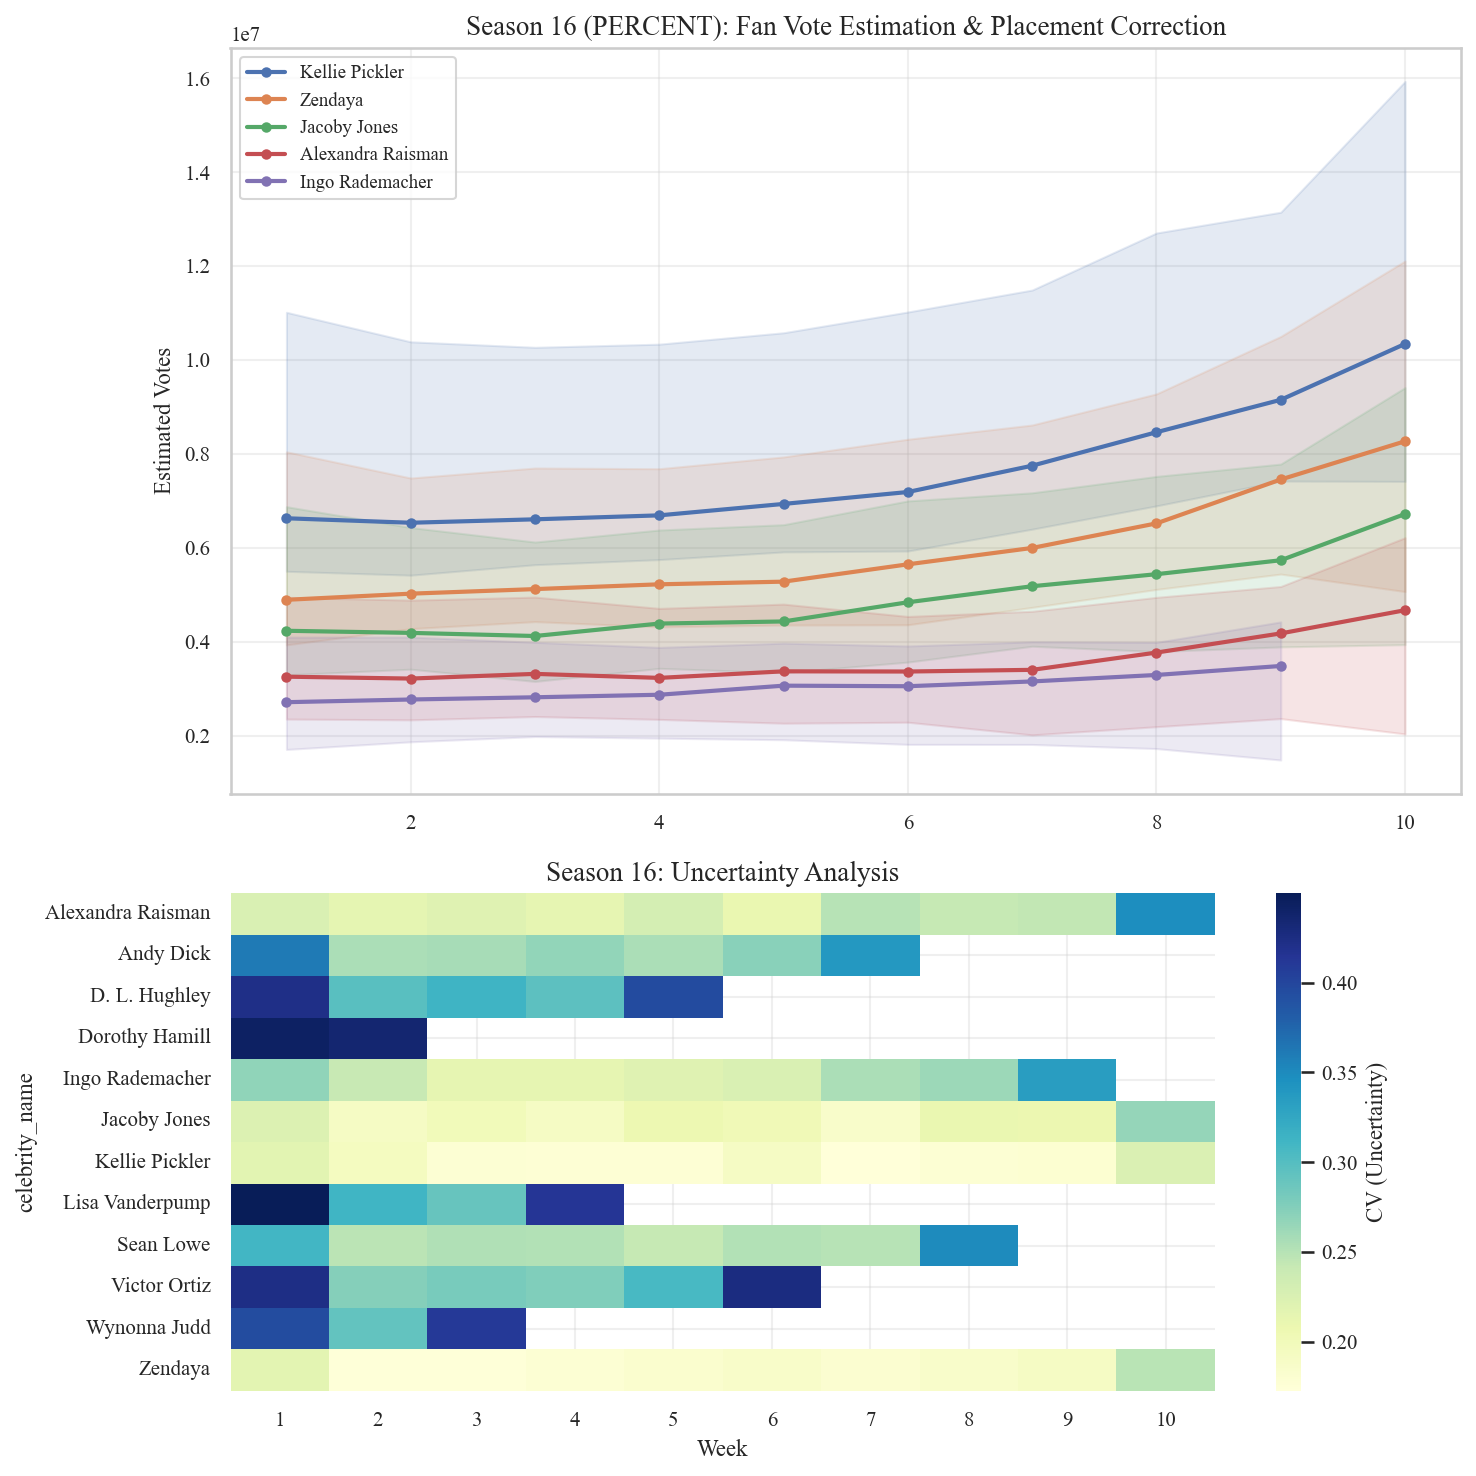


--- Processing Season 17 ---


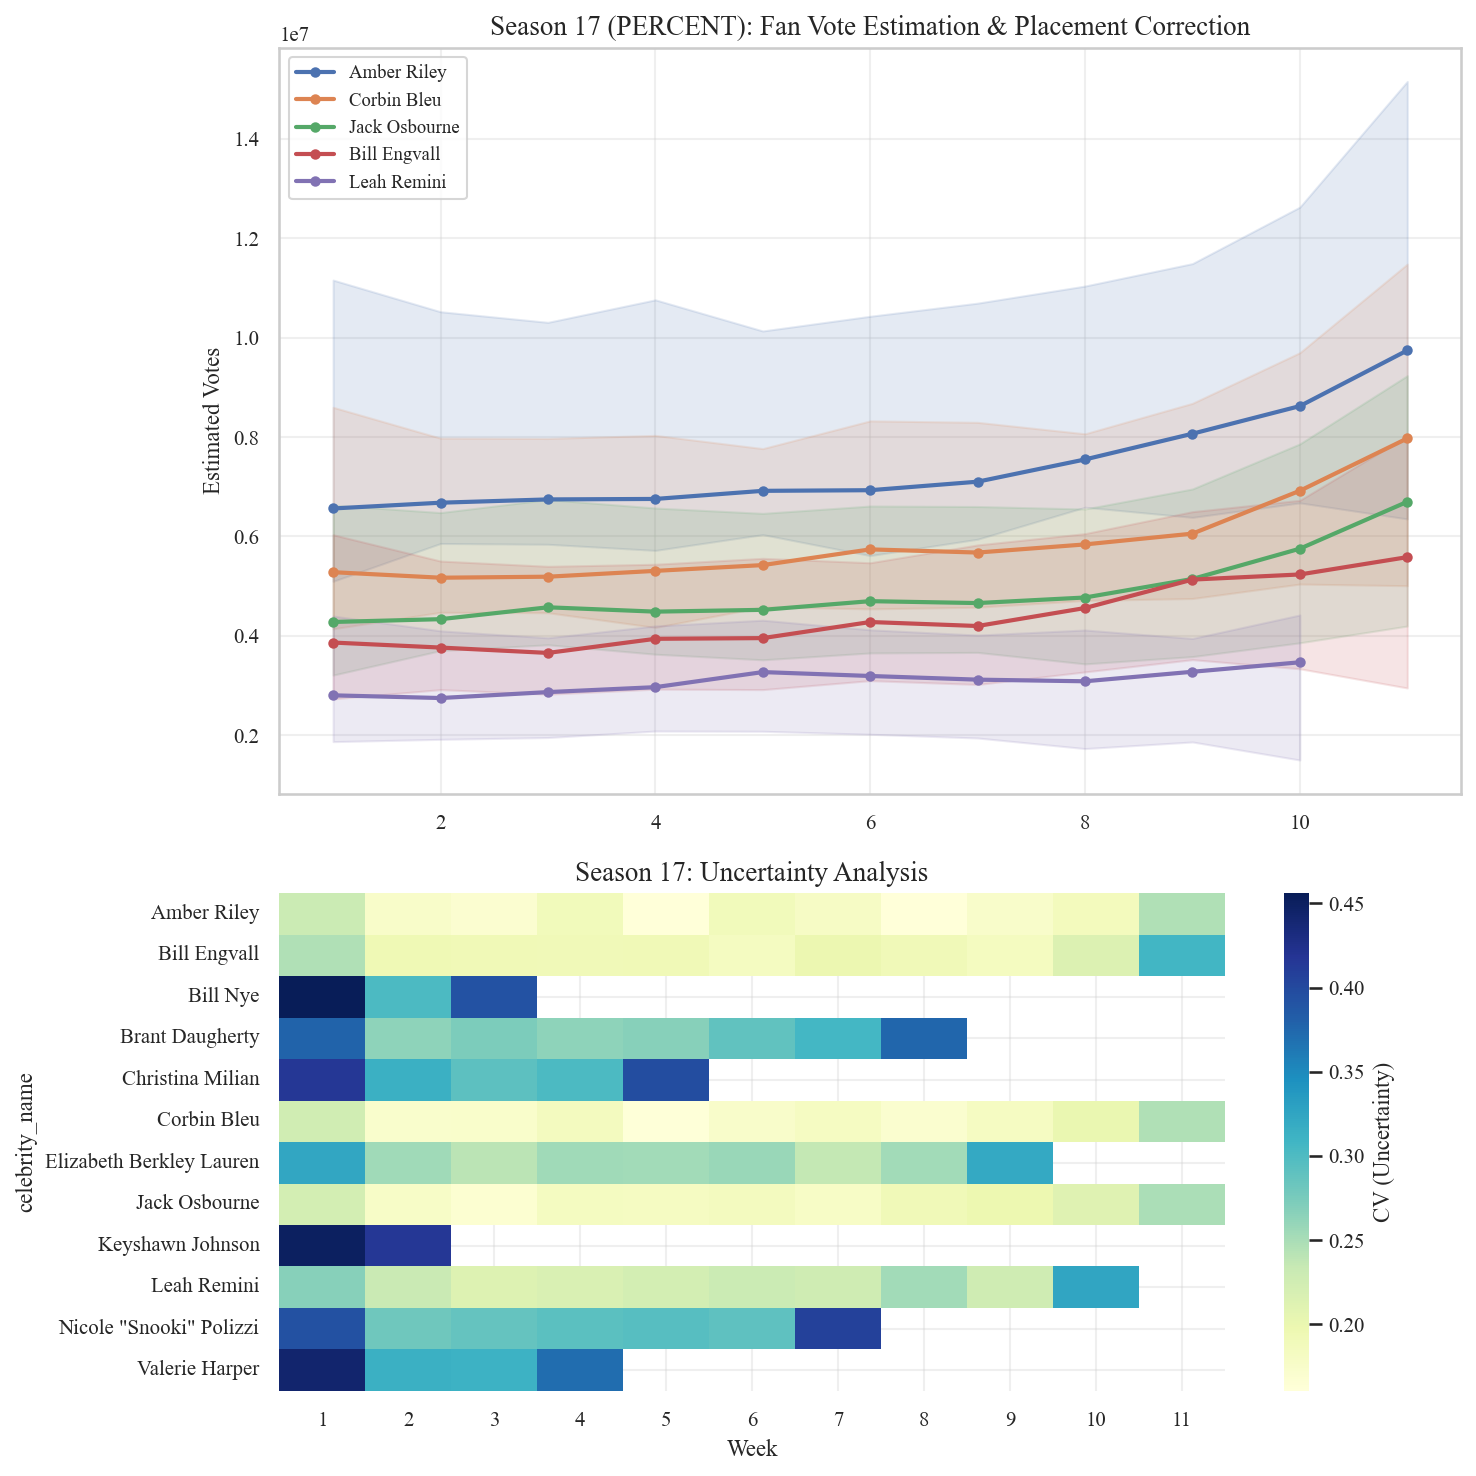


--- Processing Season 18 ---


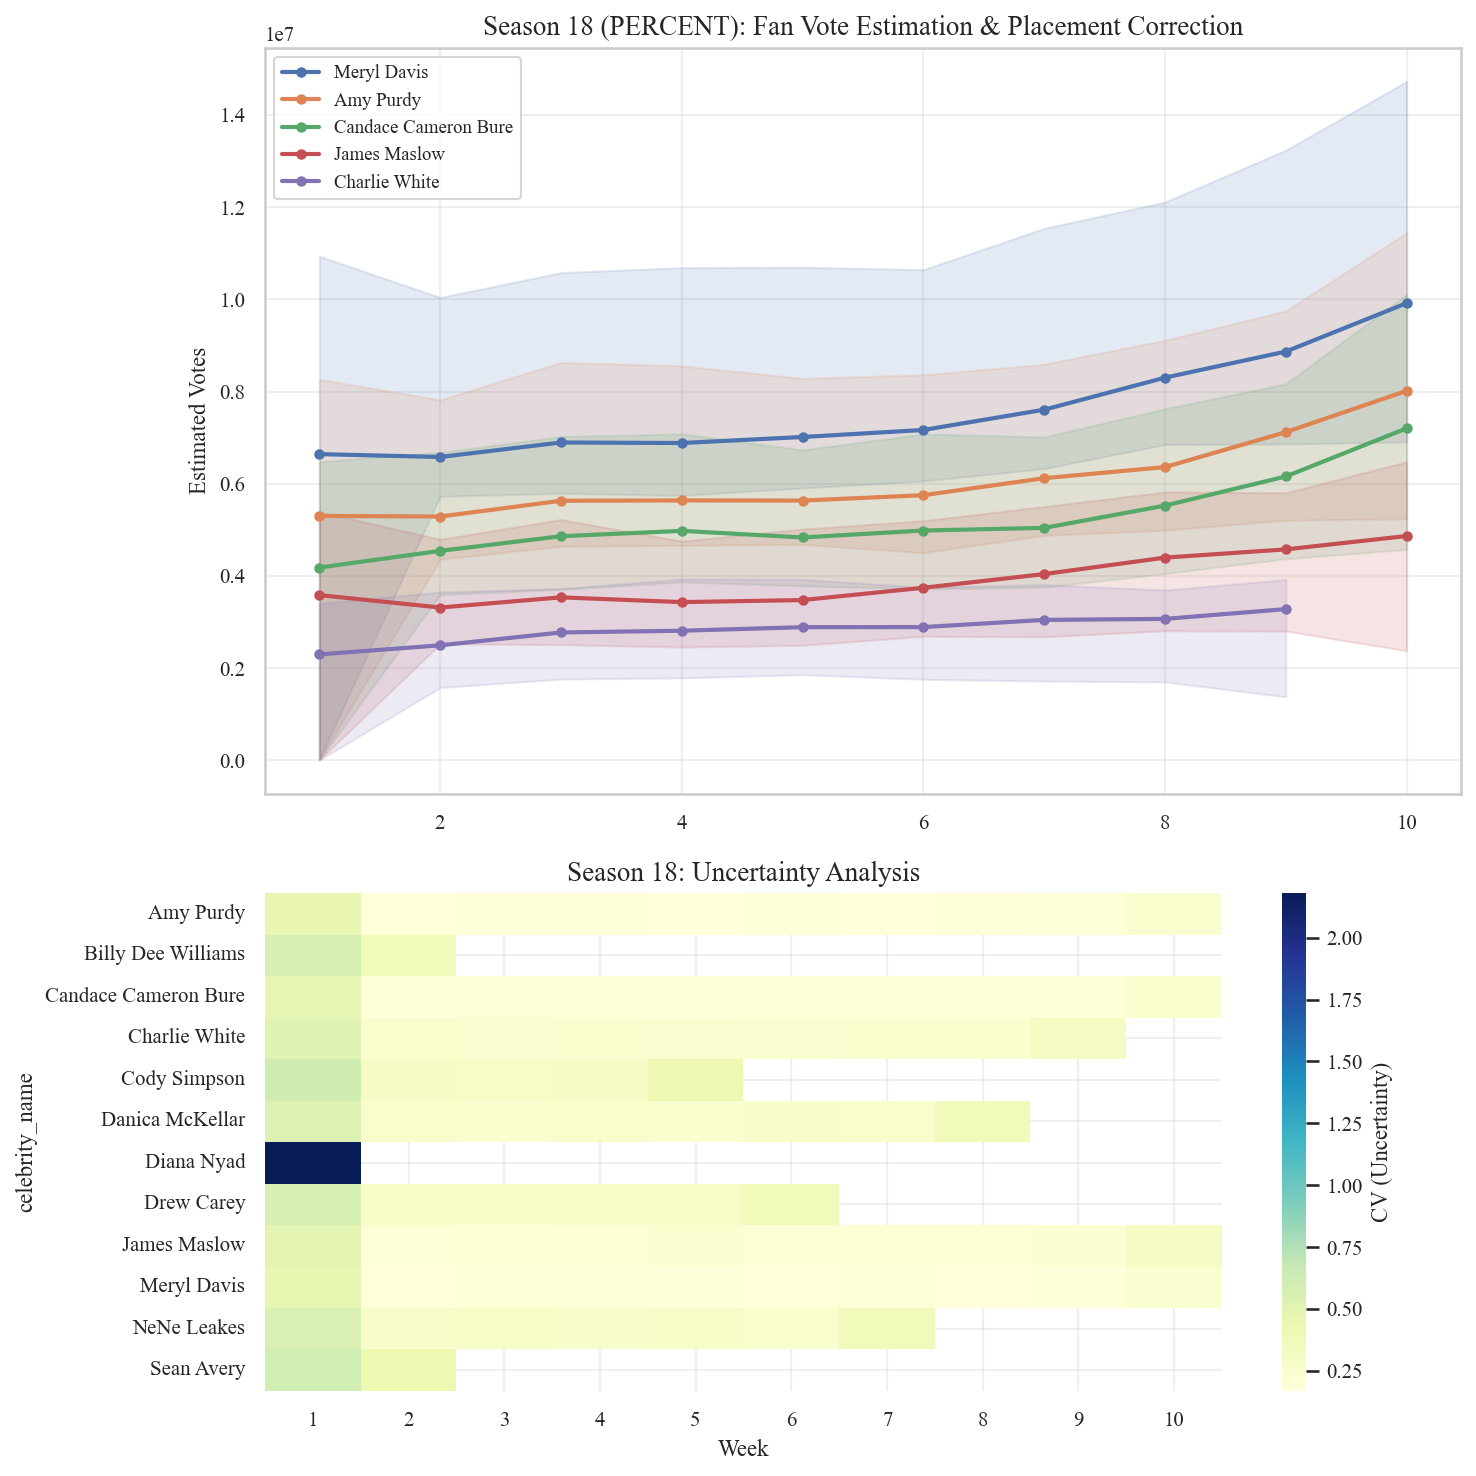


--- Processing Season 19 ---


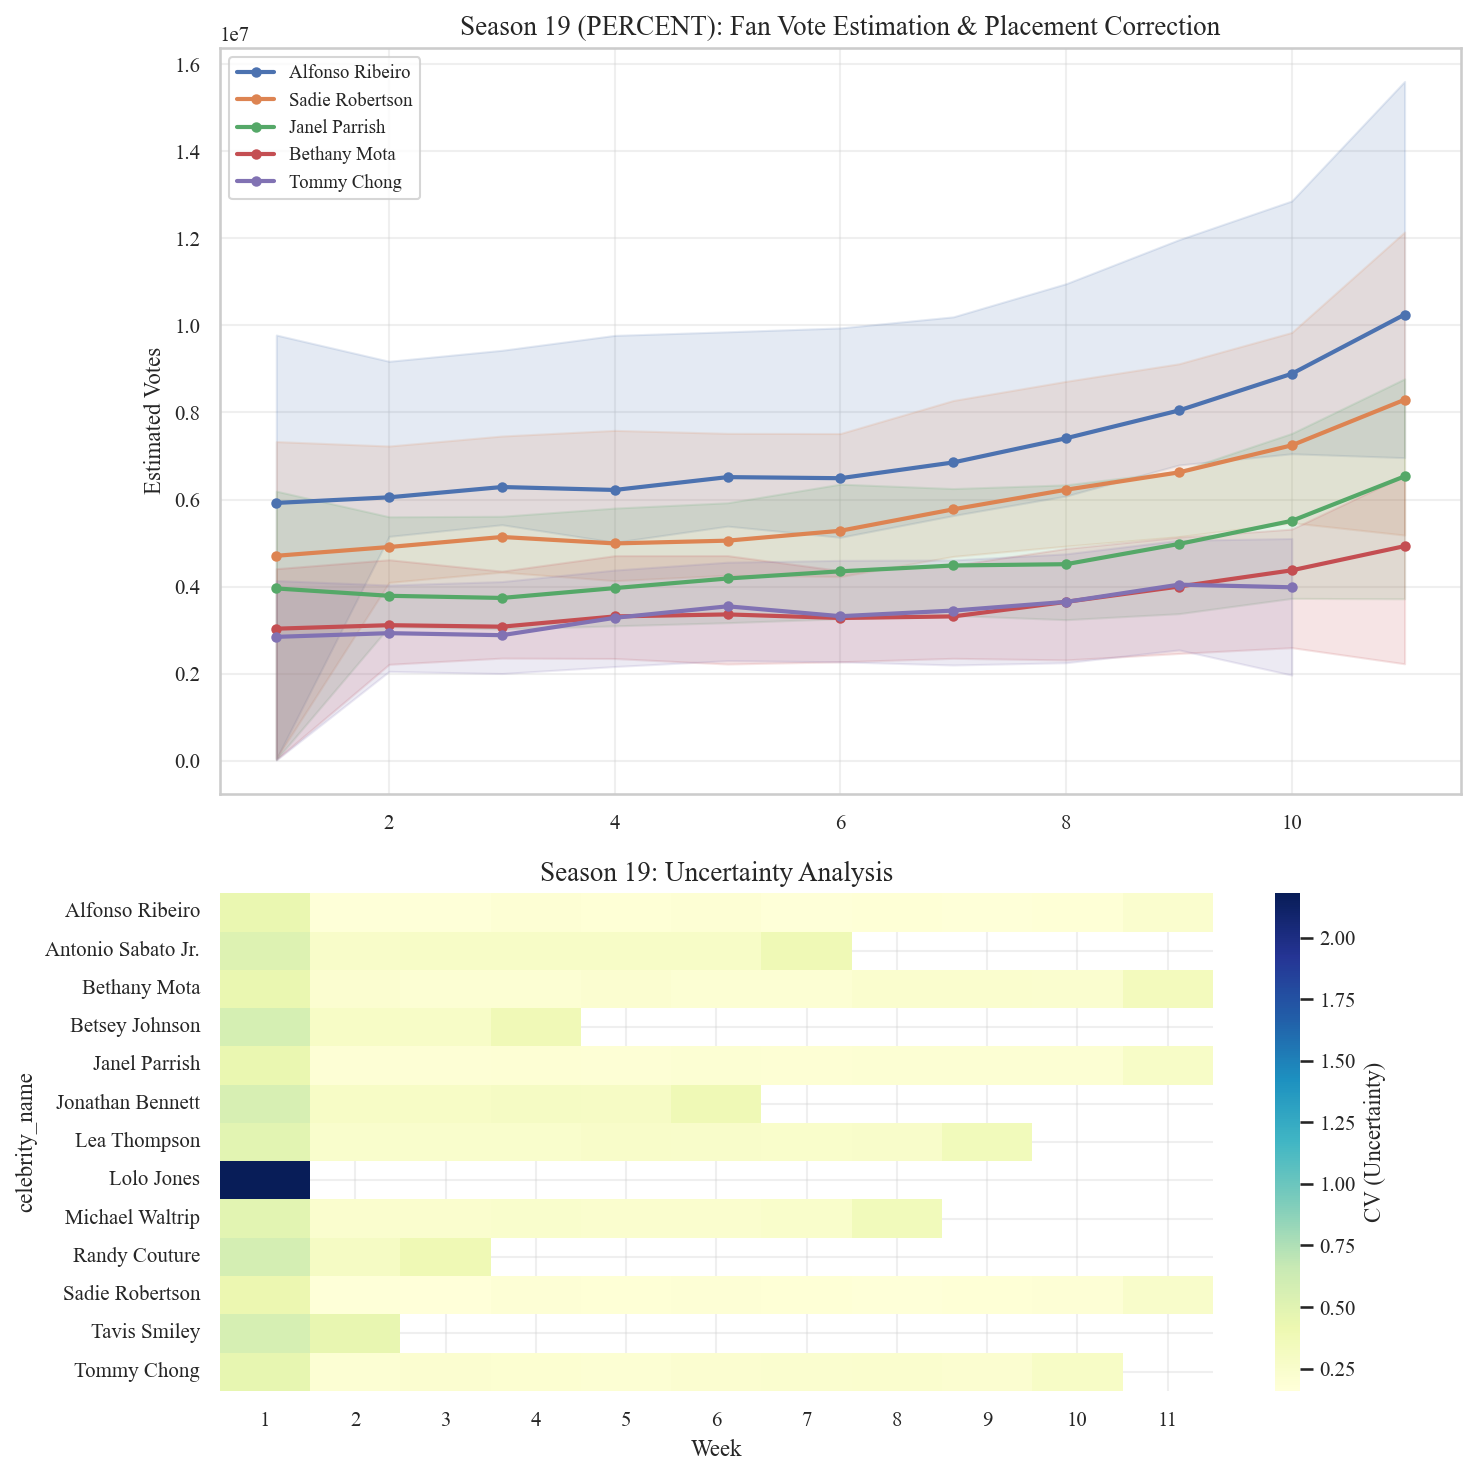


--- Processing Season 20 ---


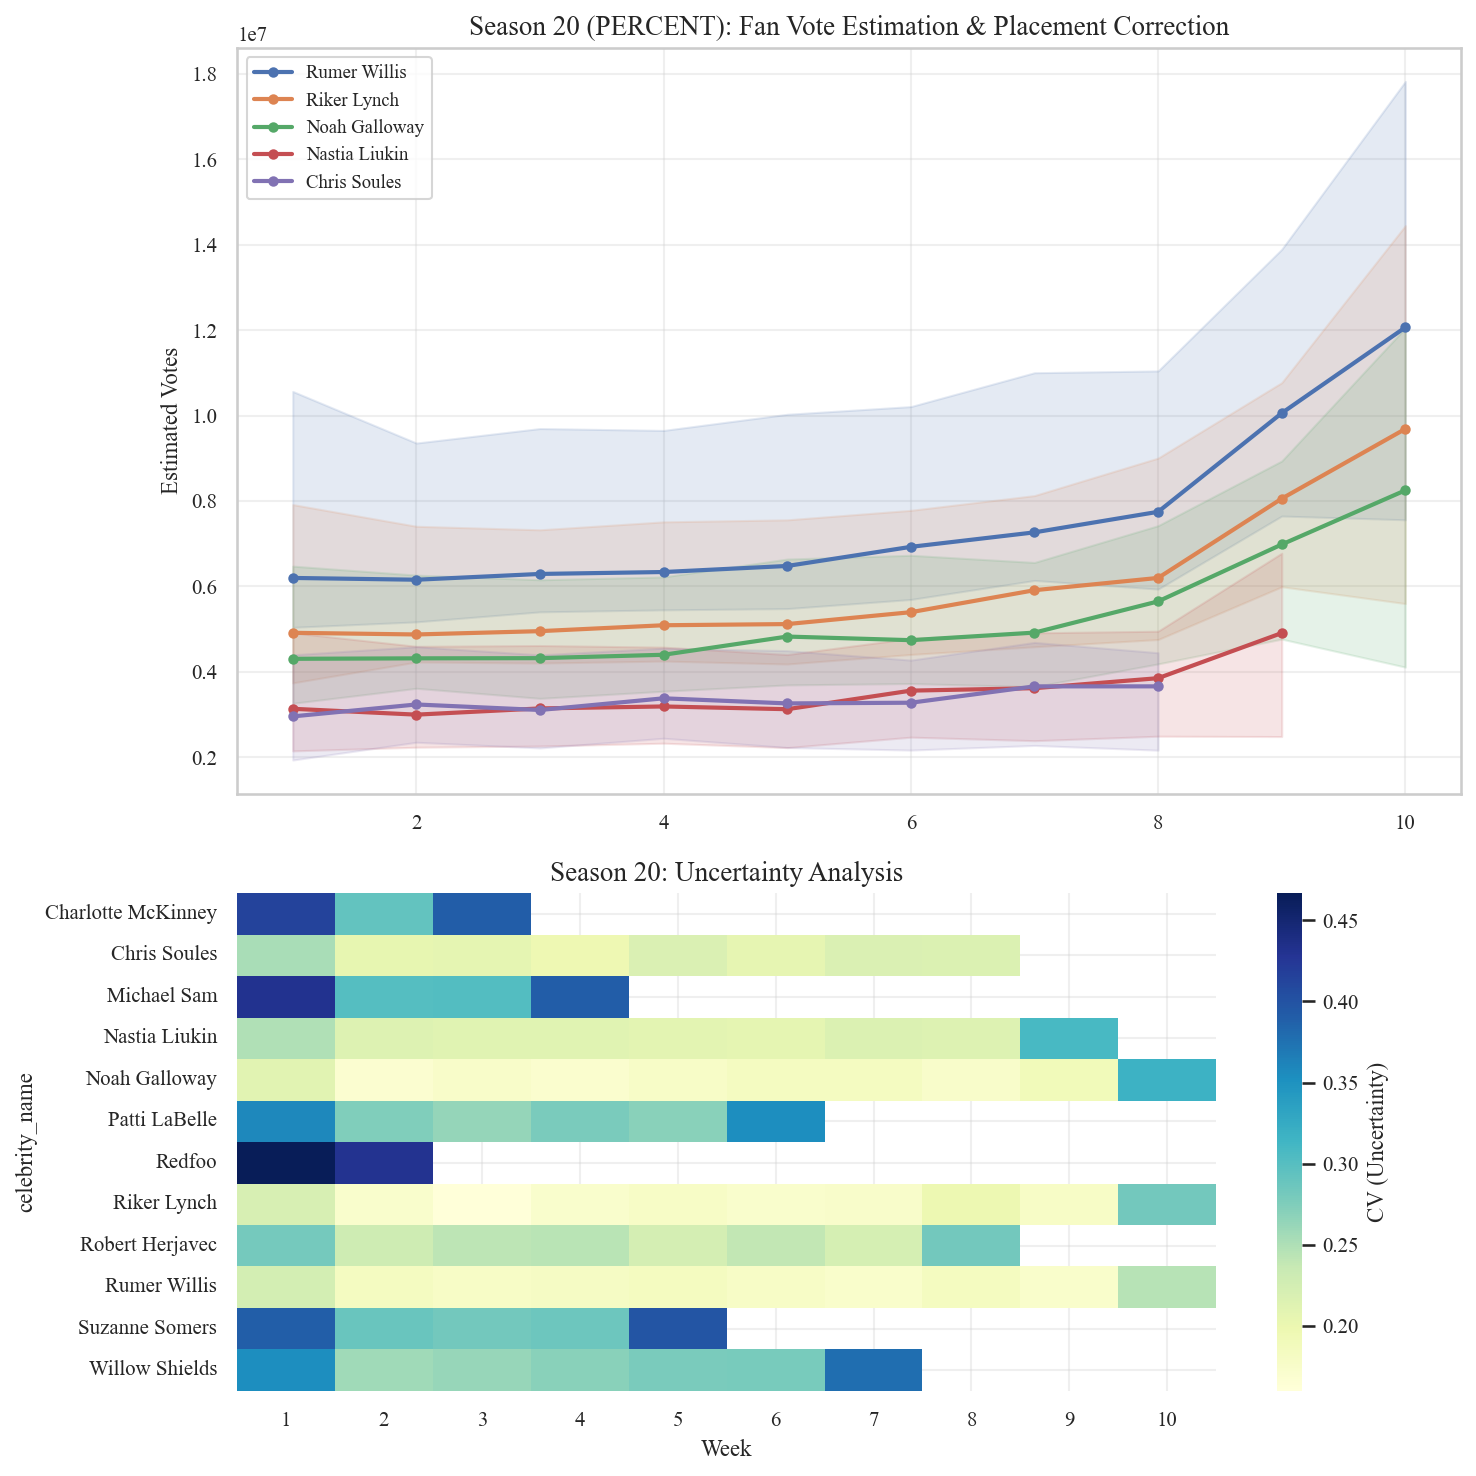


--- Processing Season 21 ---


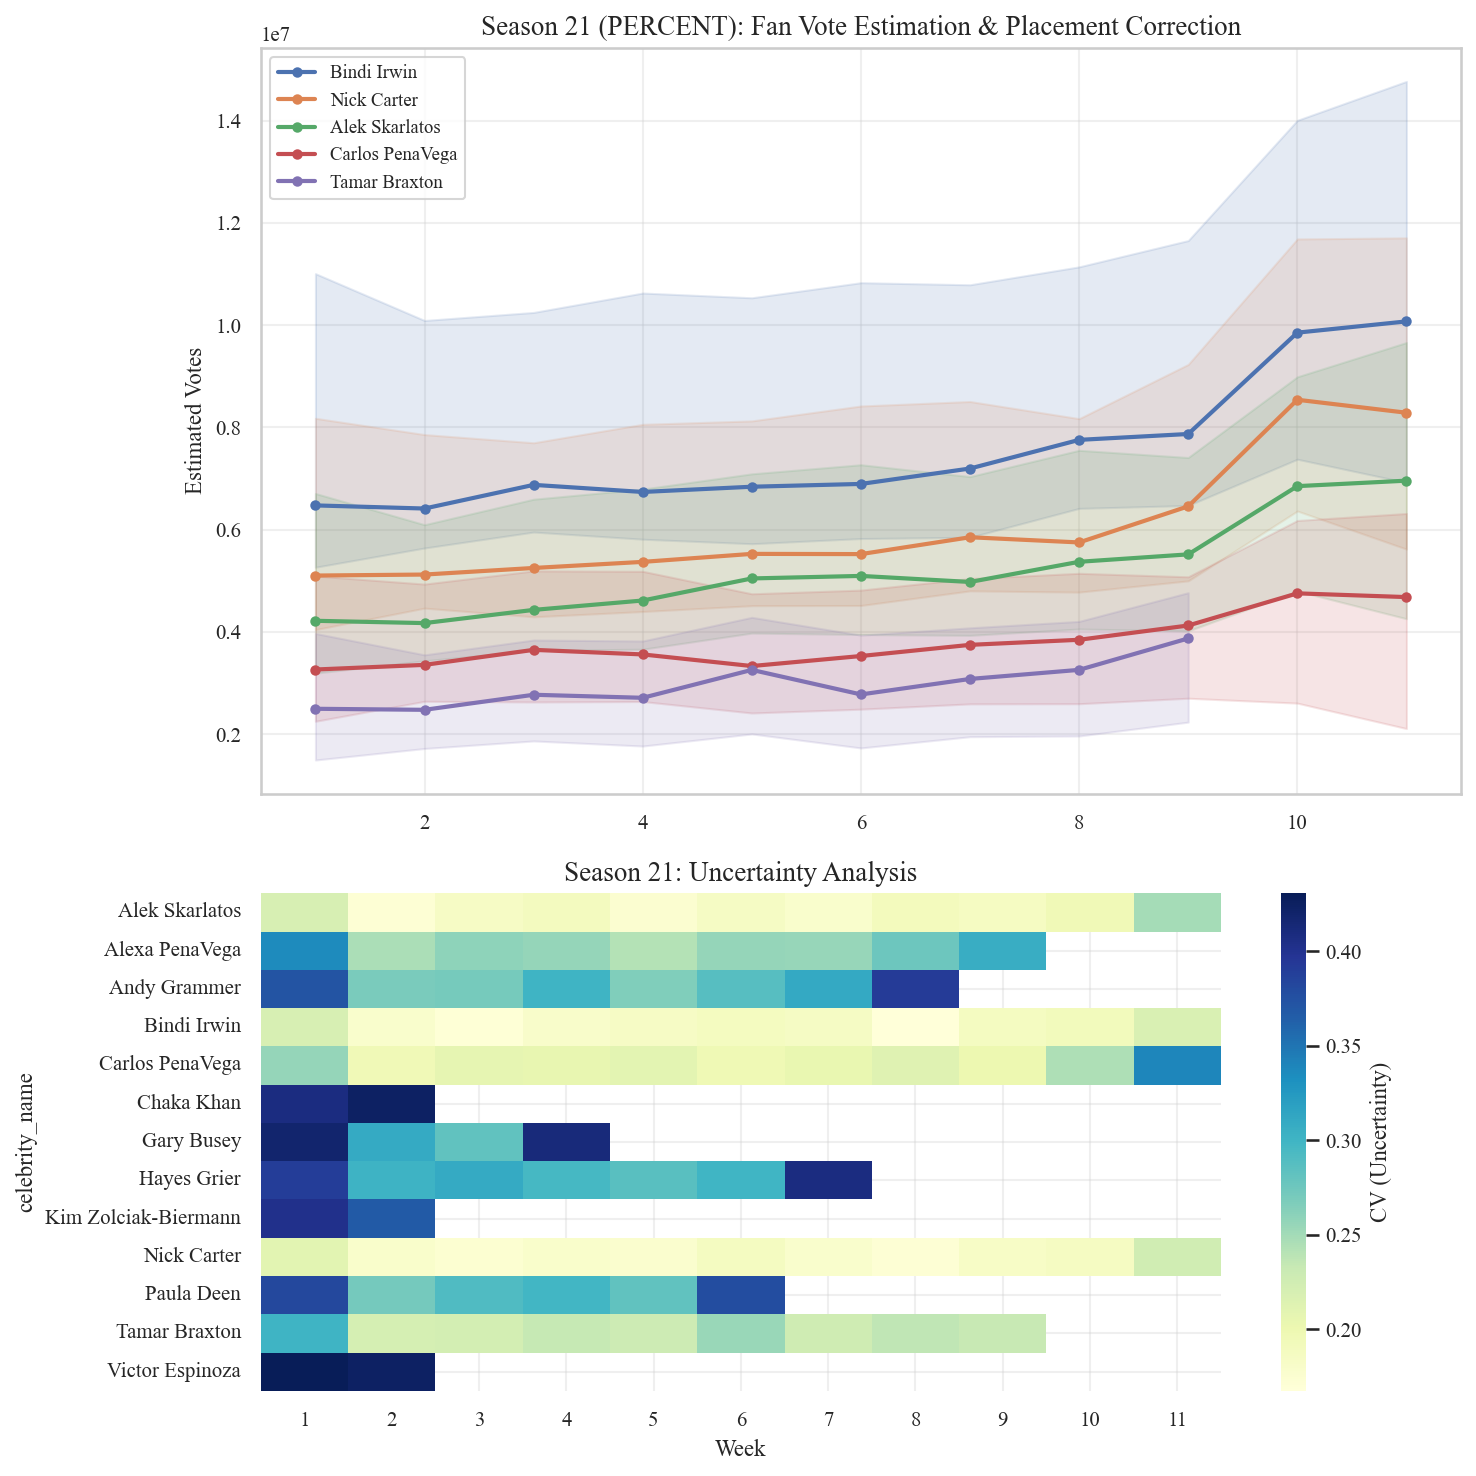


--- Processing Season 22 ---


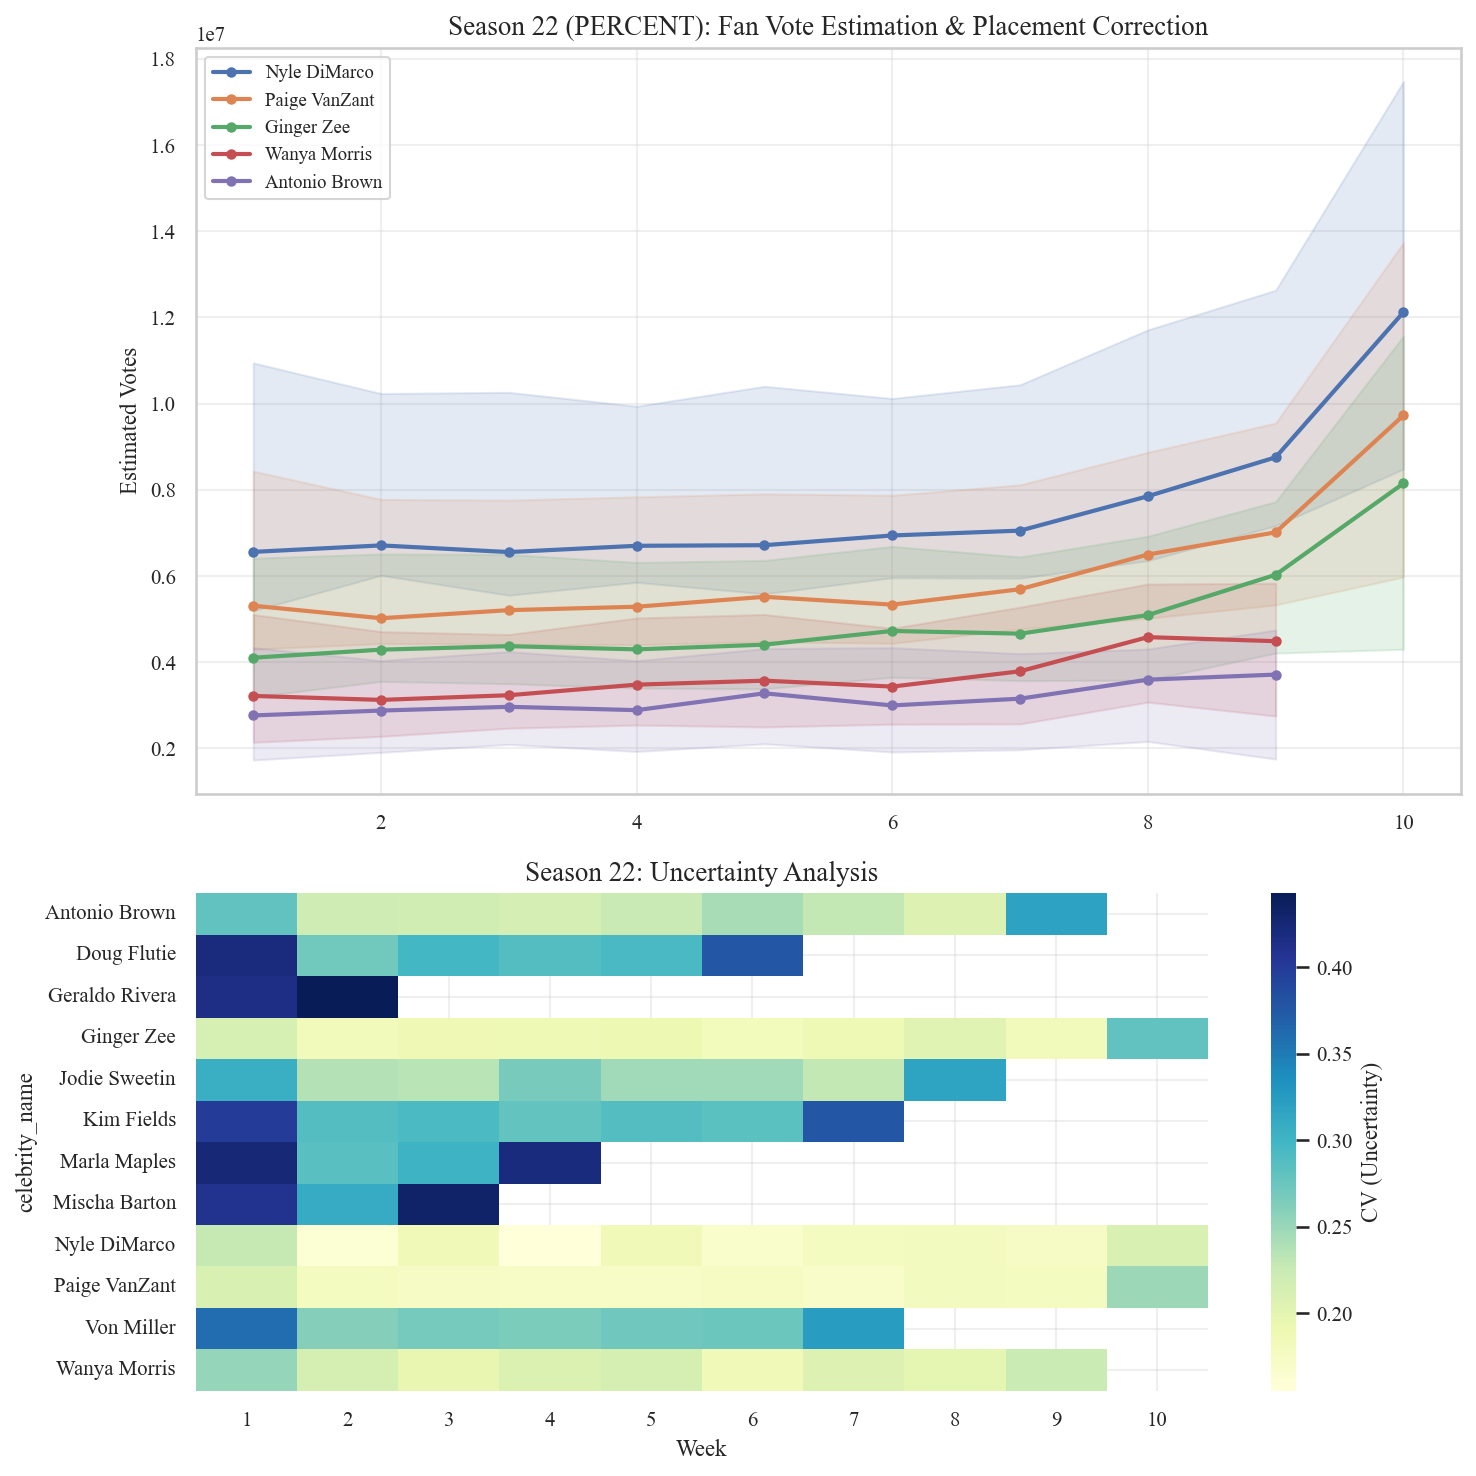


--- Processing Season 23 ---


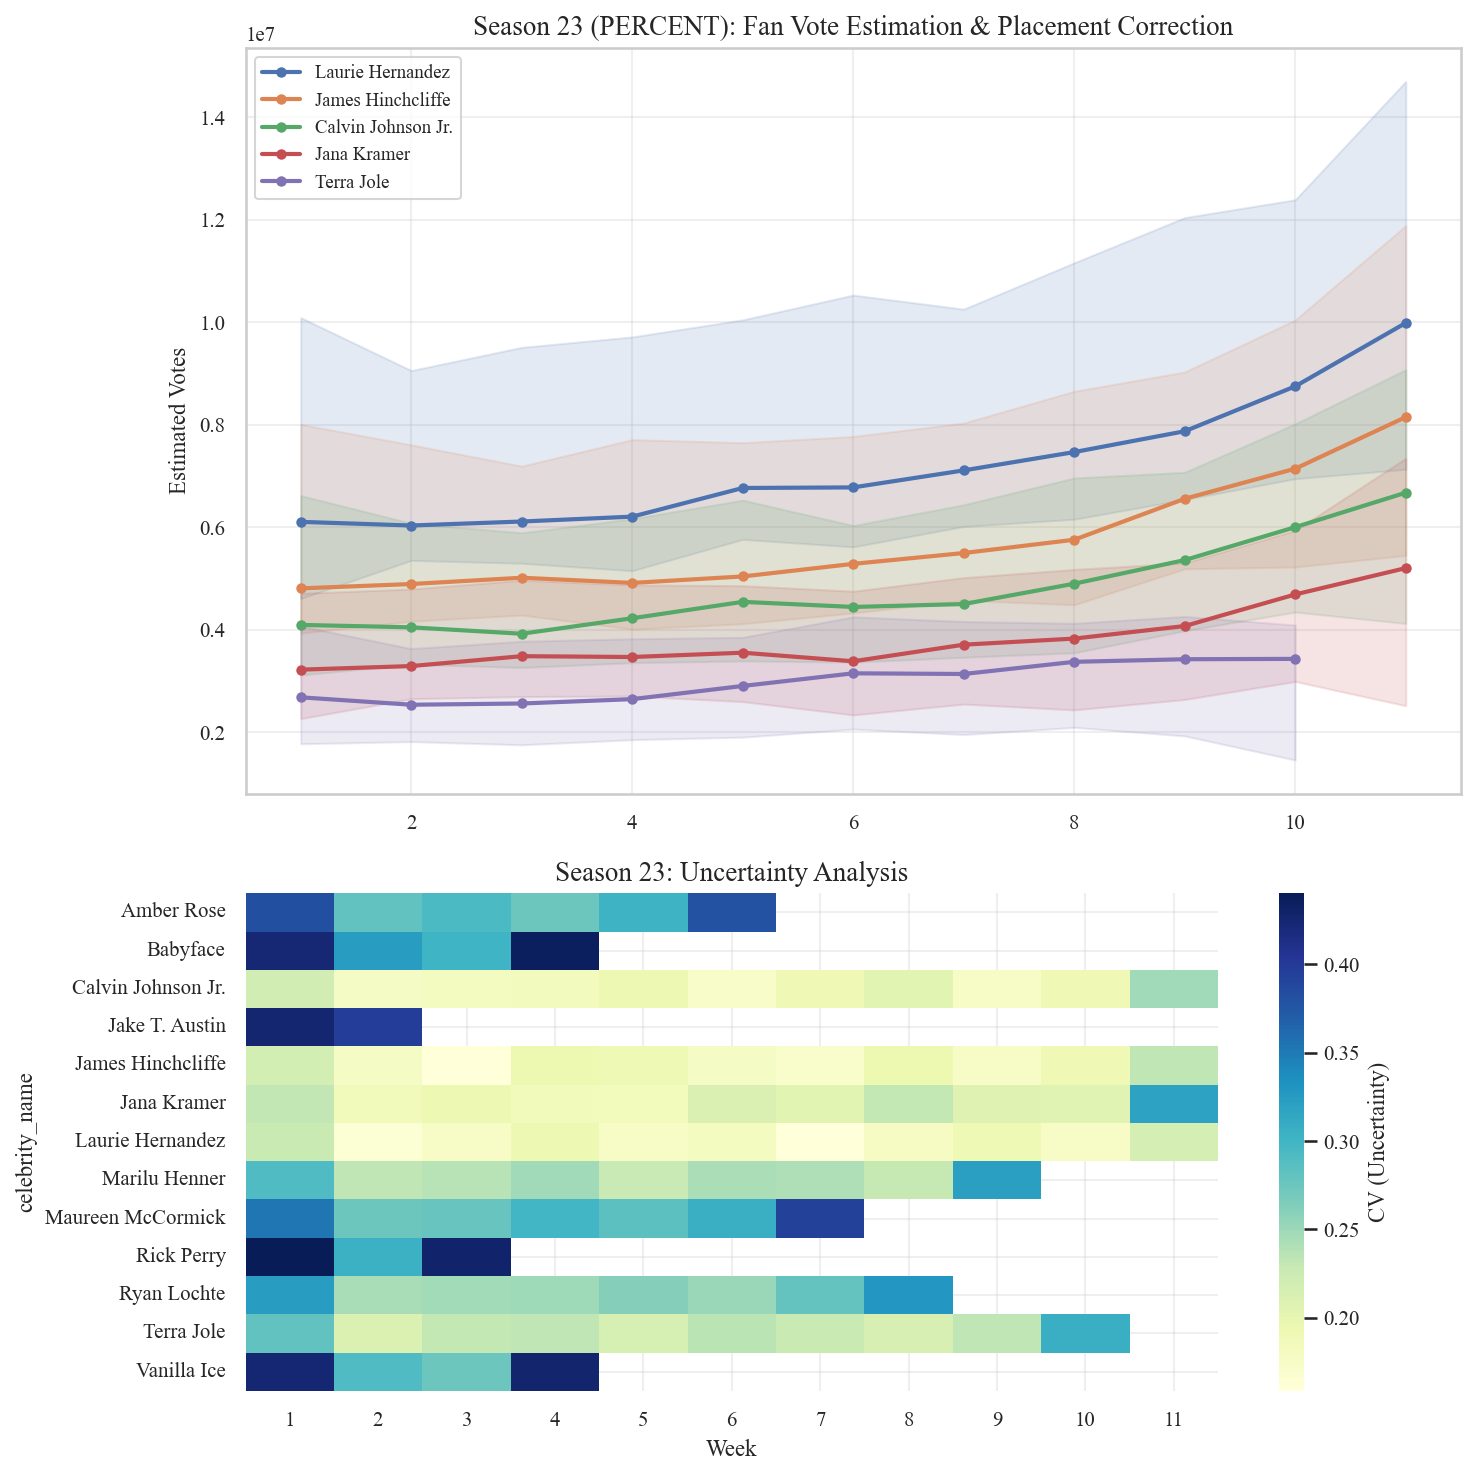


--- Processing Season 24 ---


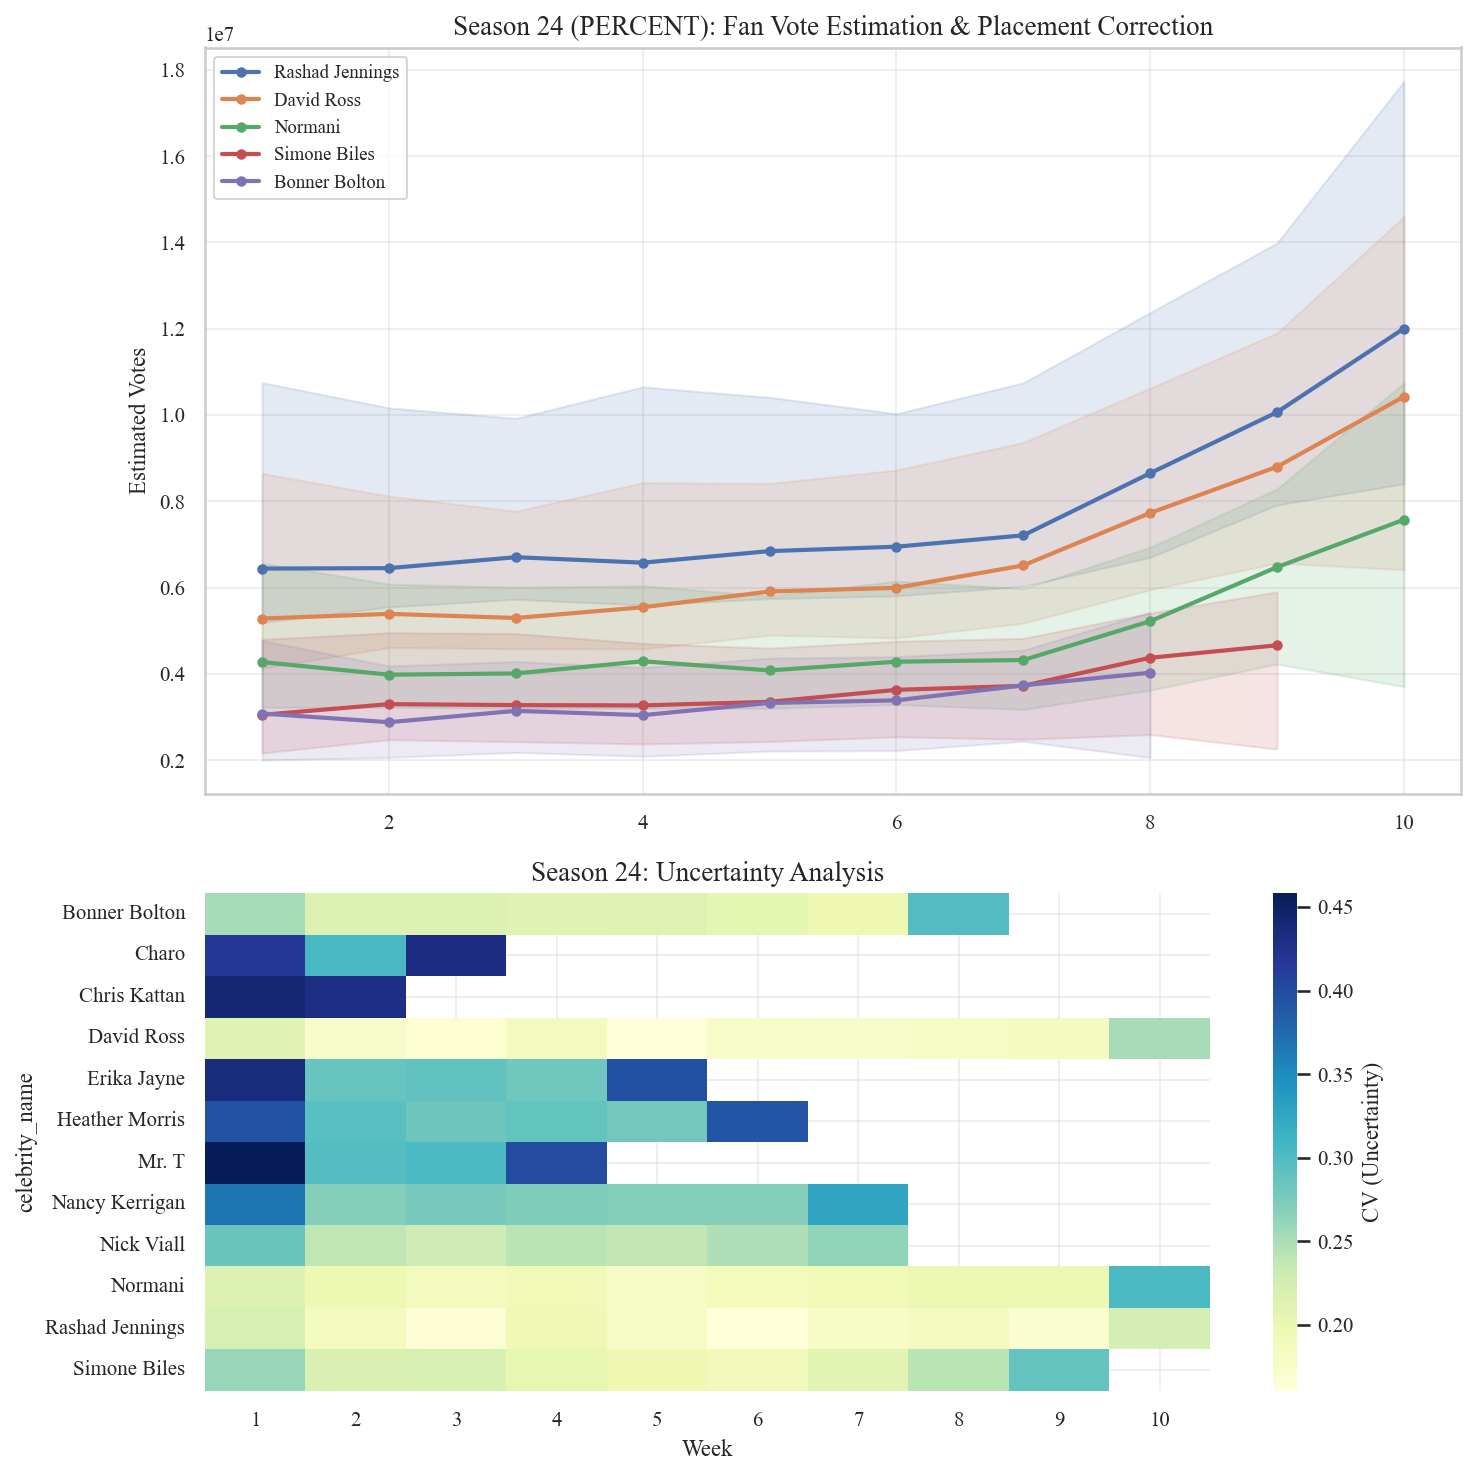


--- Processing Season 25 ---


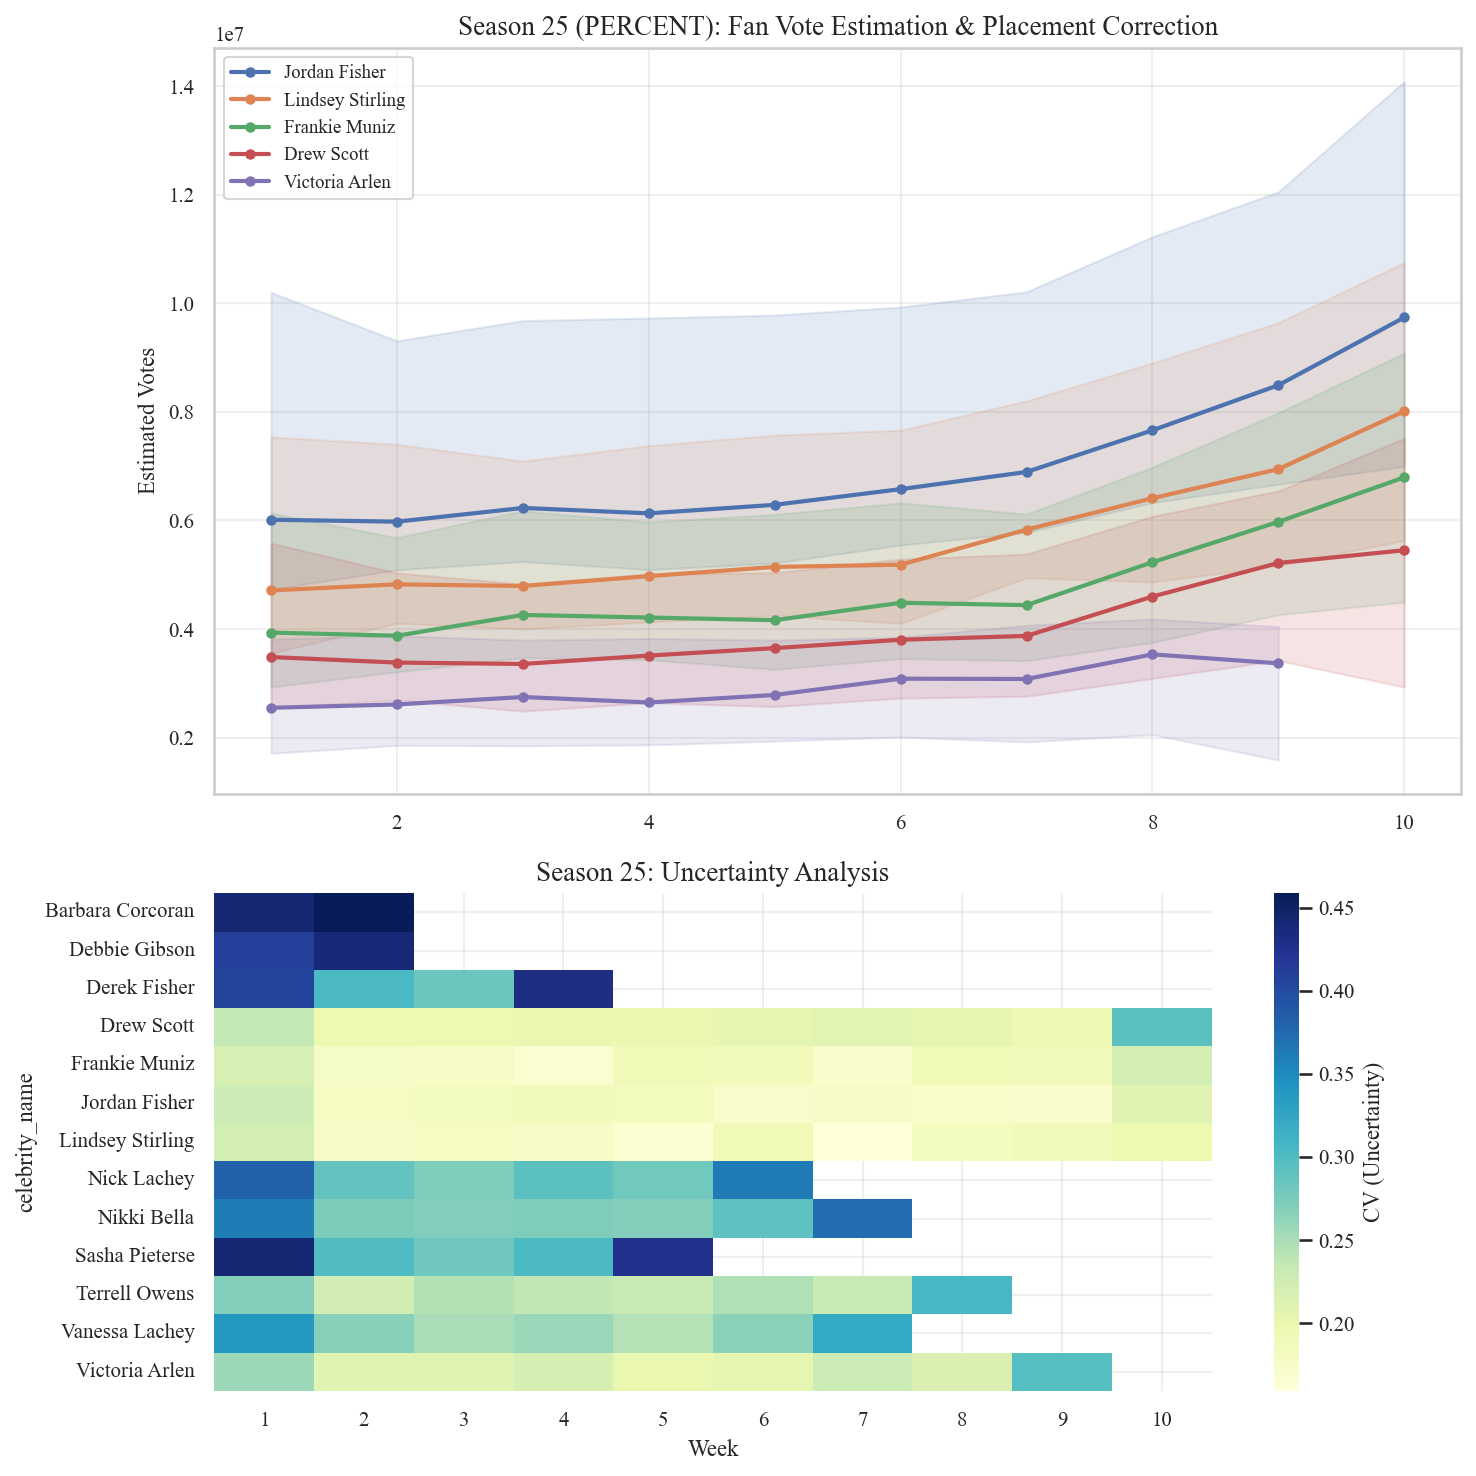


--- Processing Season 26 ---


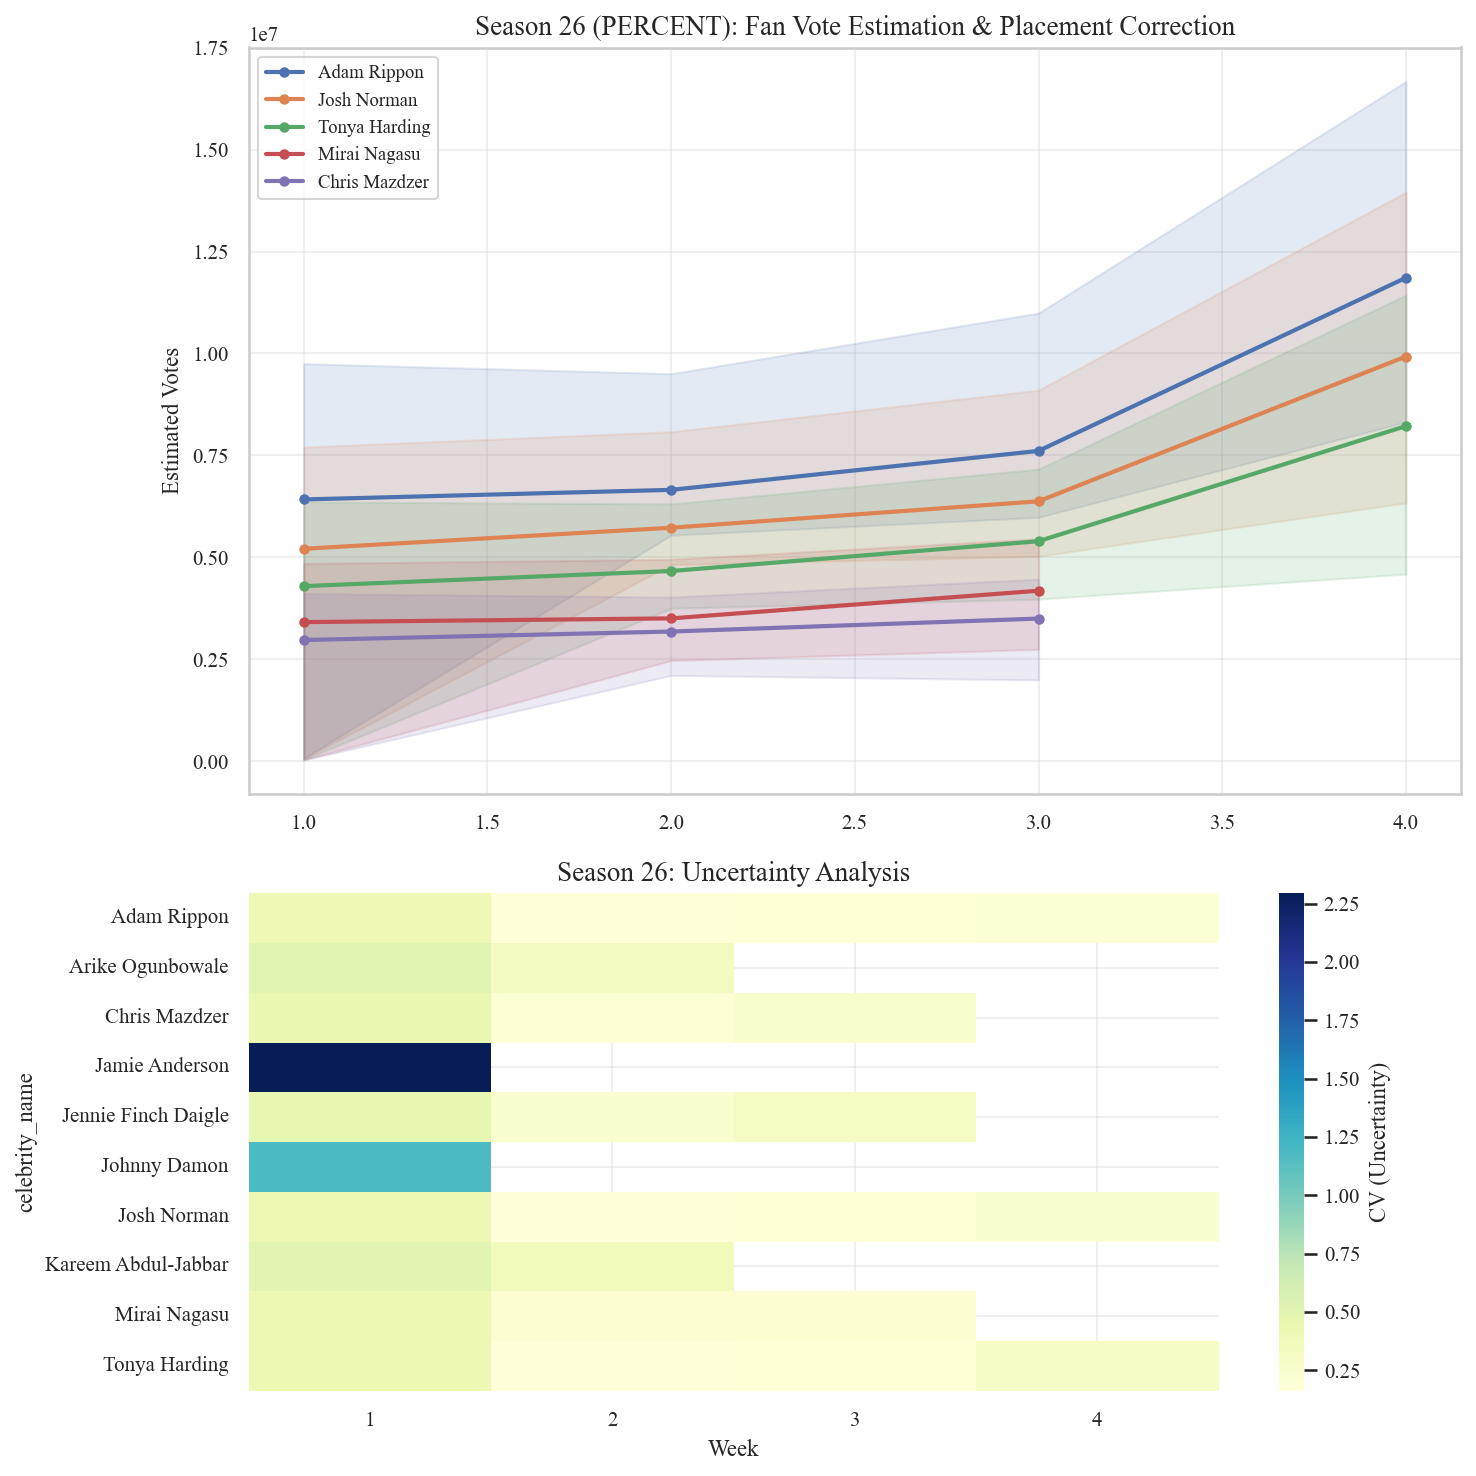


--- Processing Season 27 ---


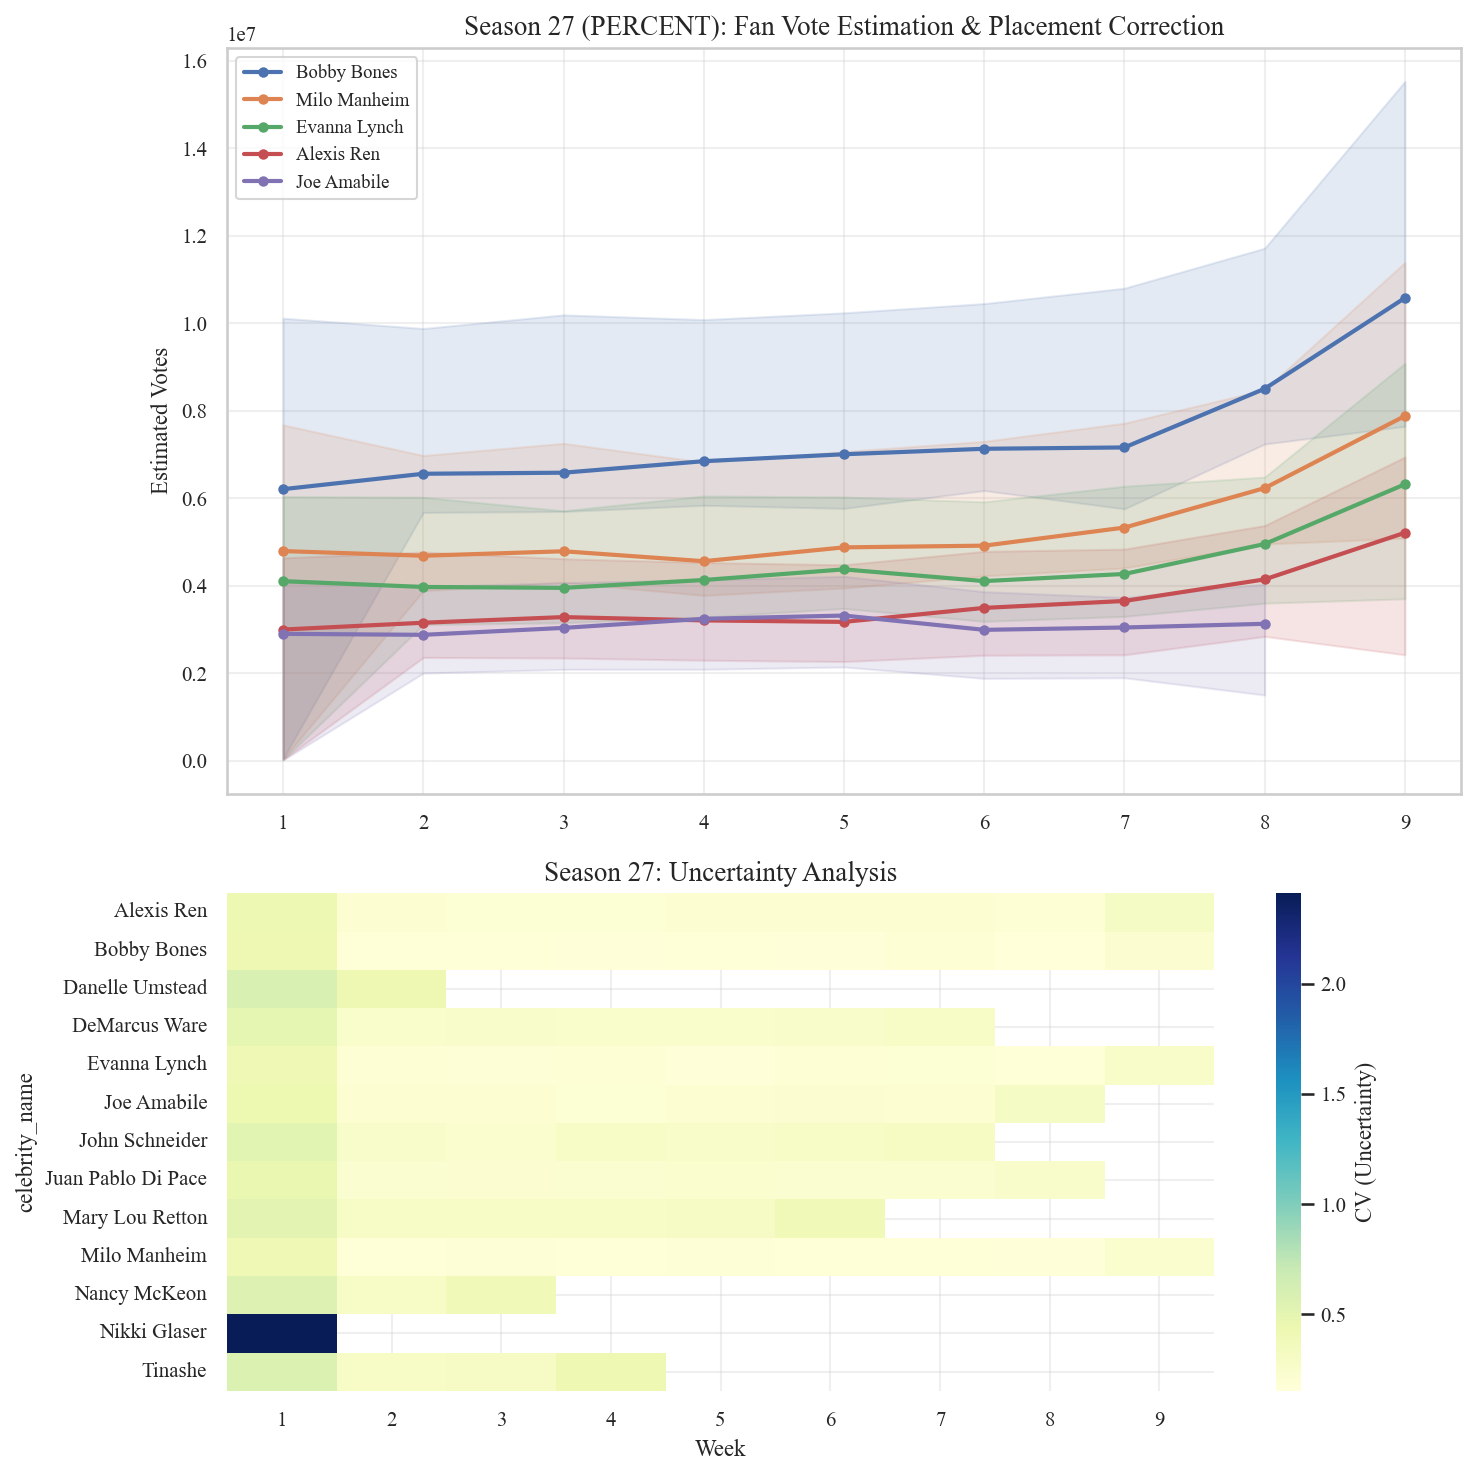


--- Processing Season 28 ---


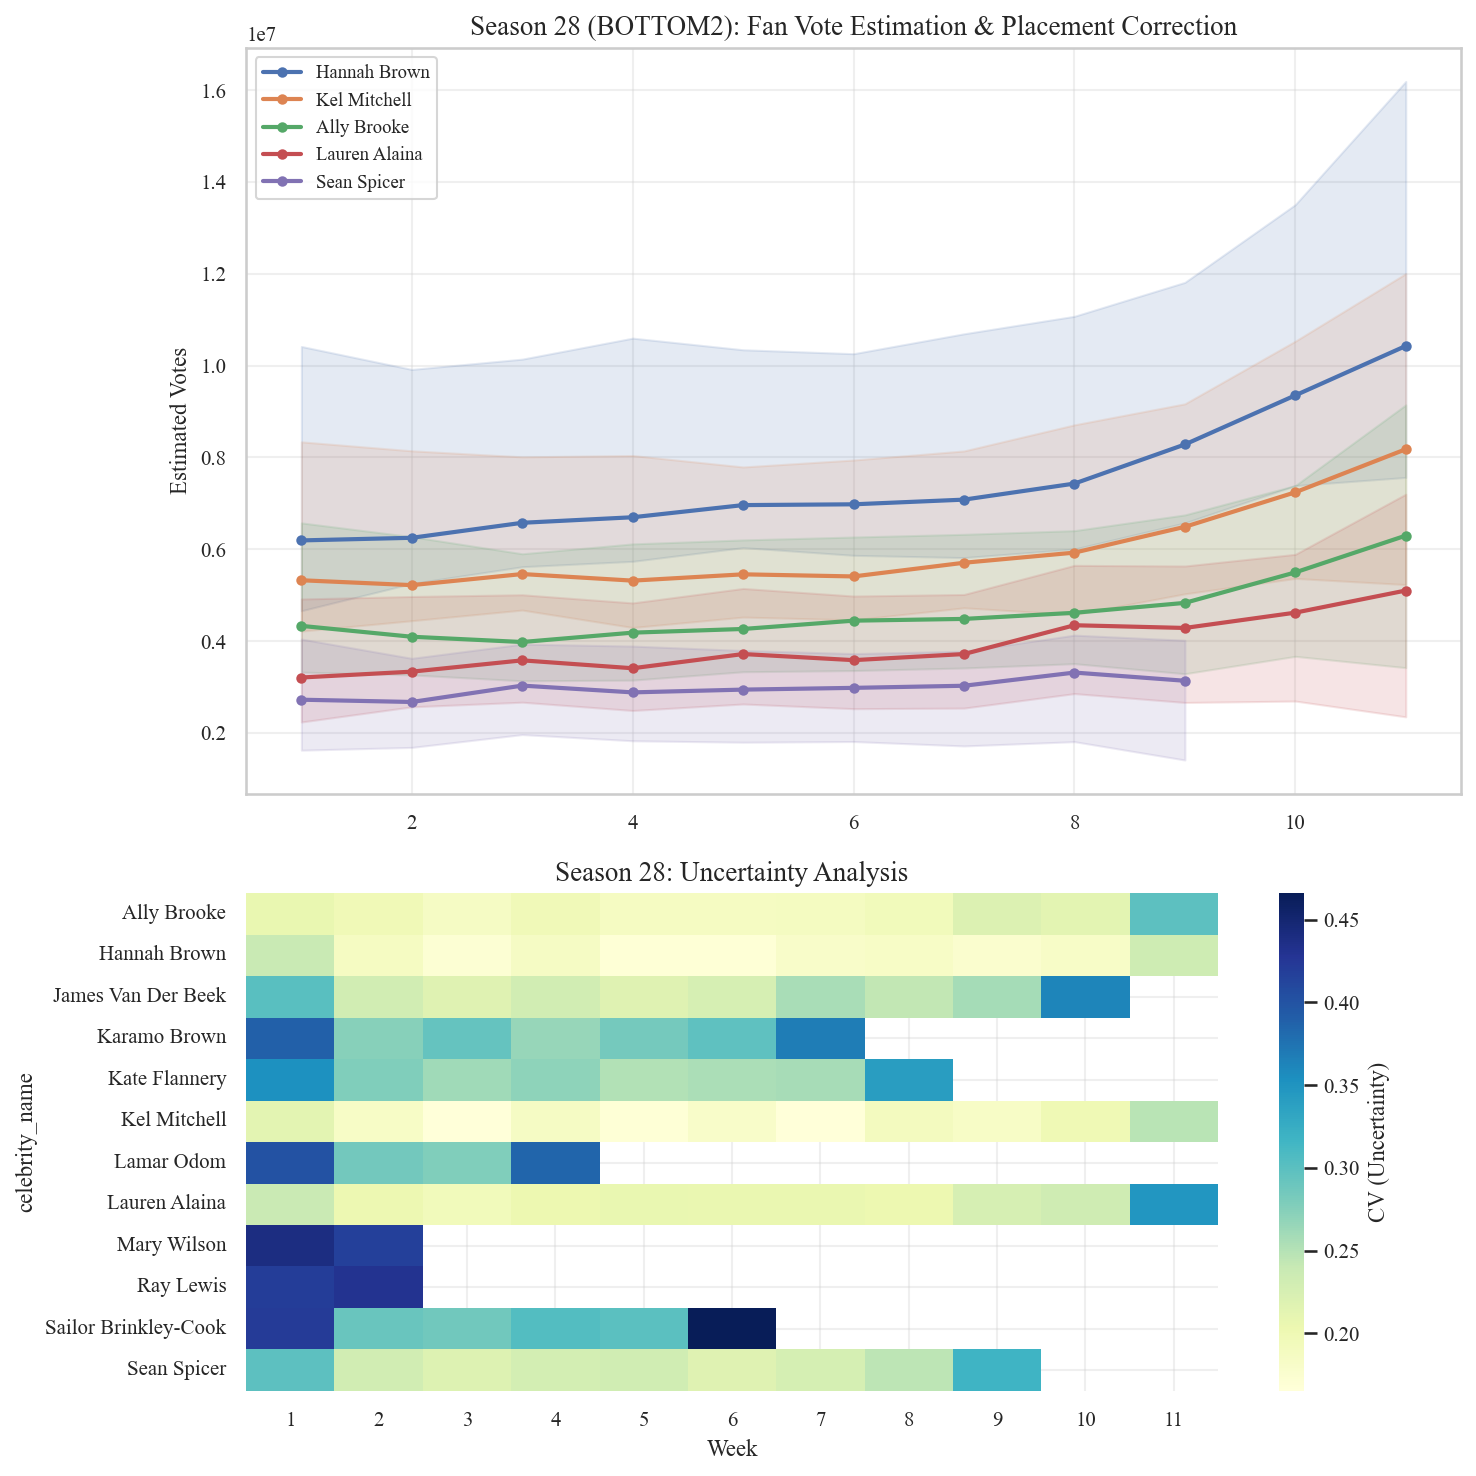


--- Processing Season 29 ---


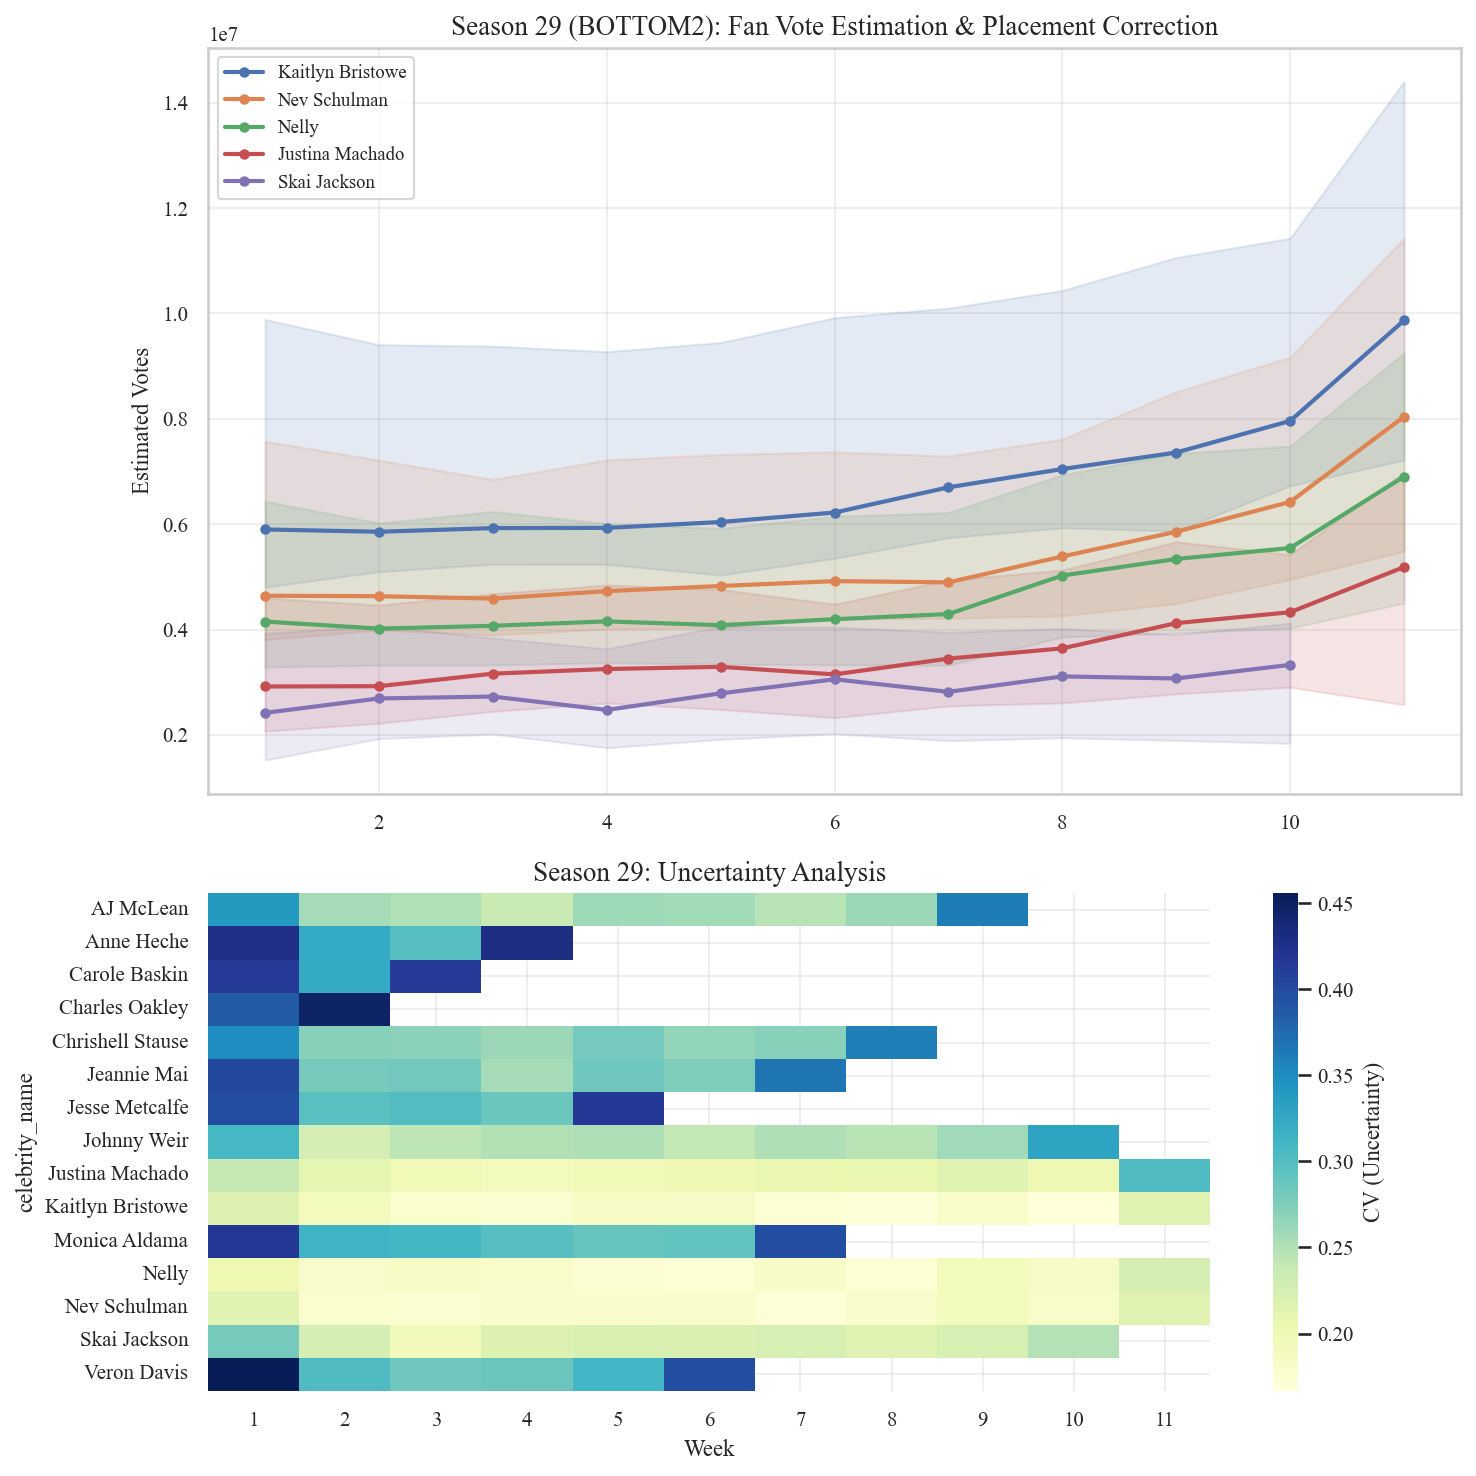


--- Processing Season 30 ---


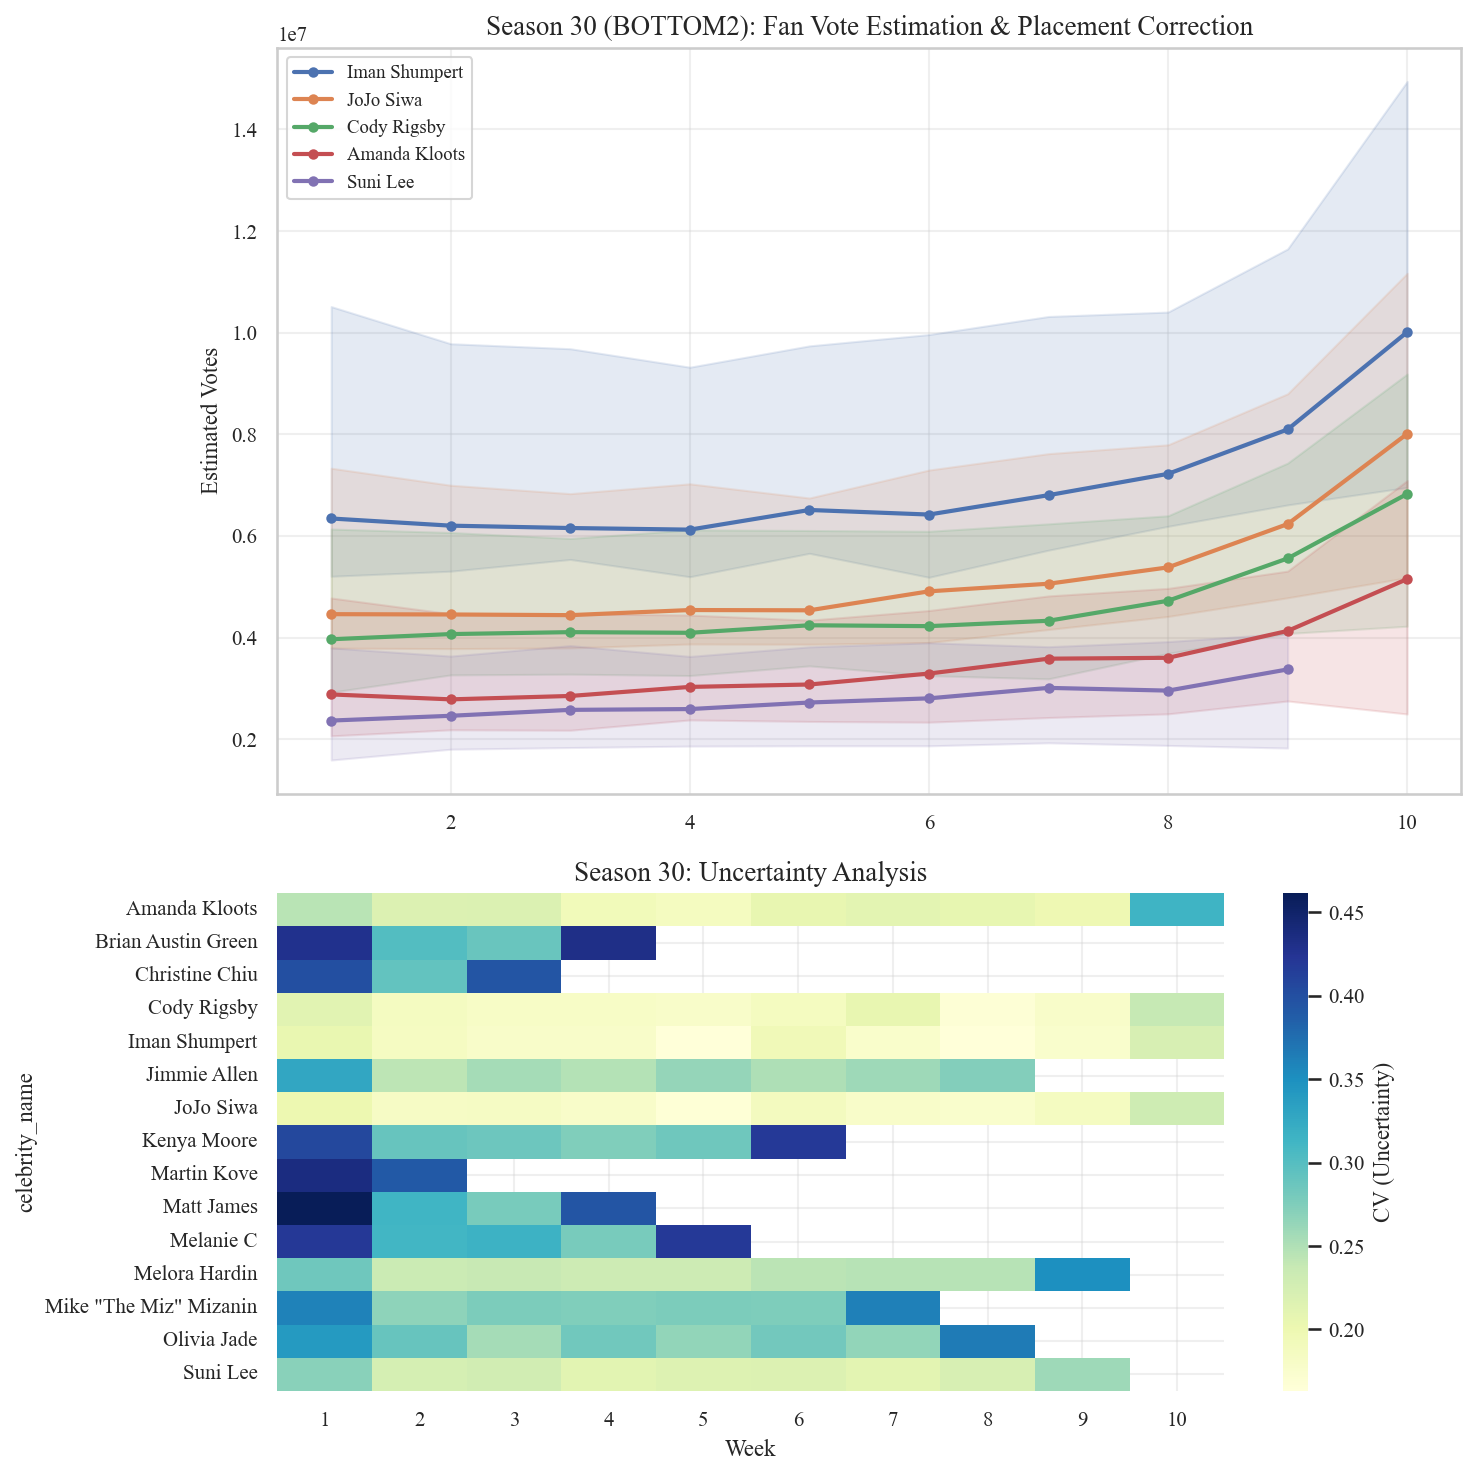


--- Processing Season 31 ---


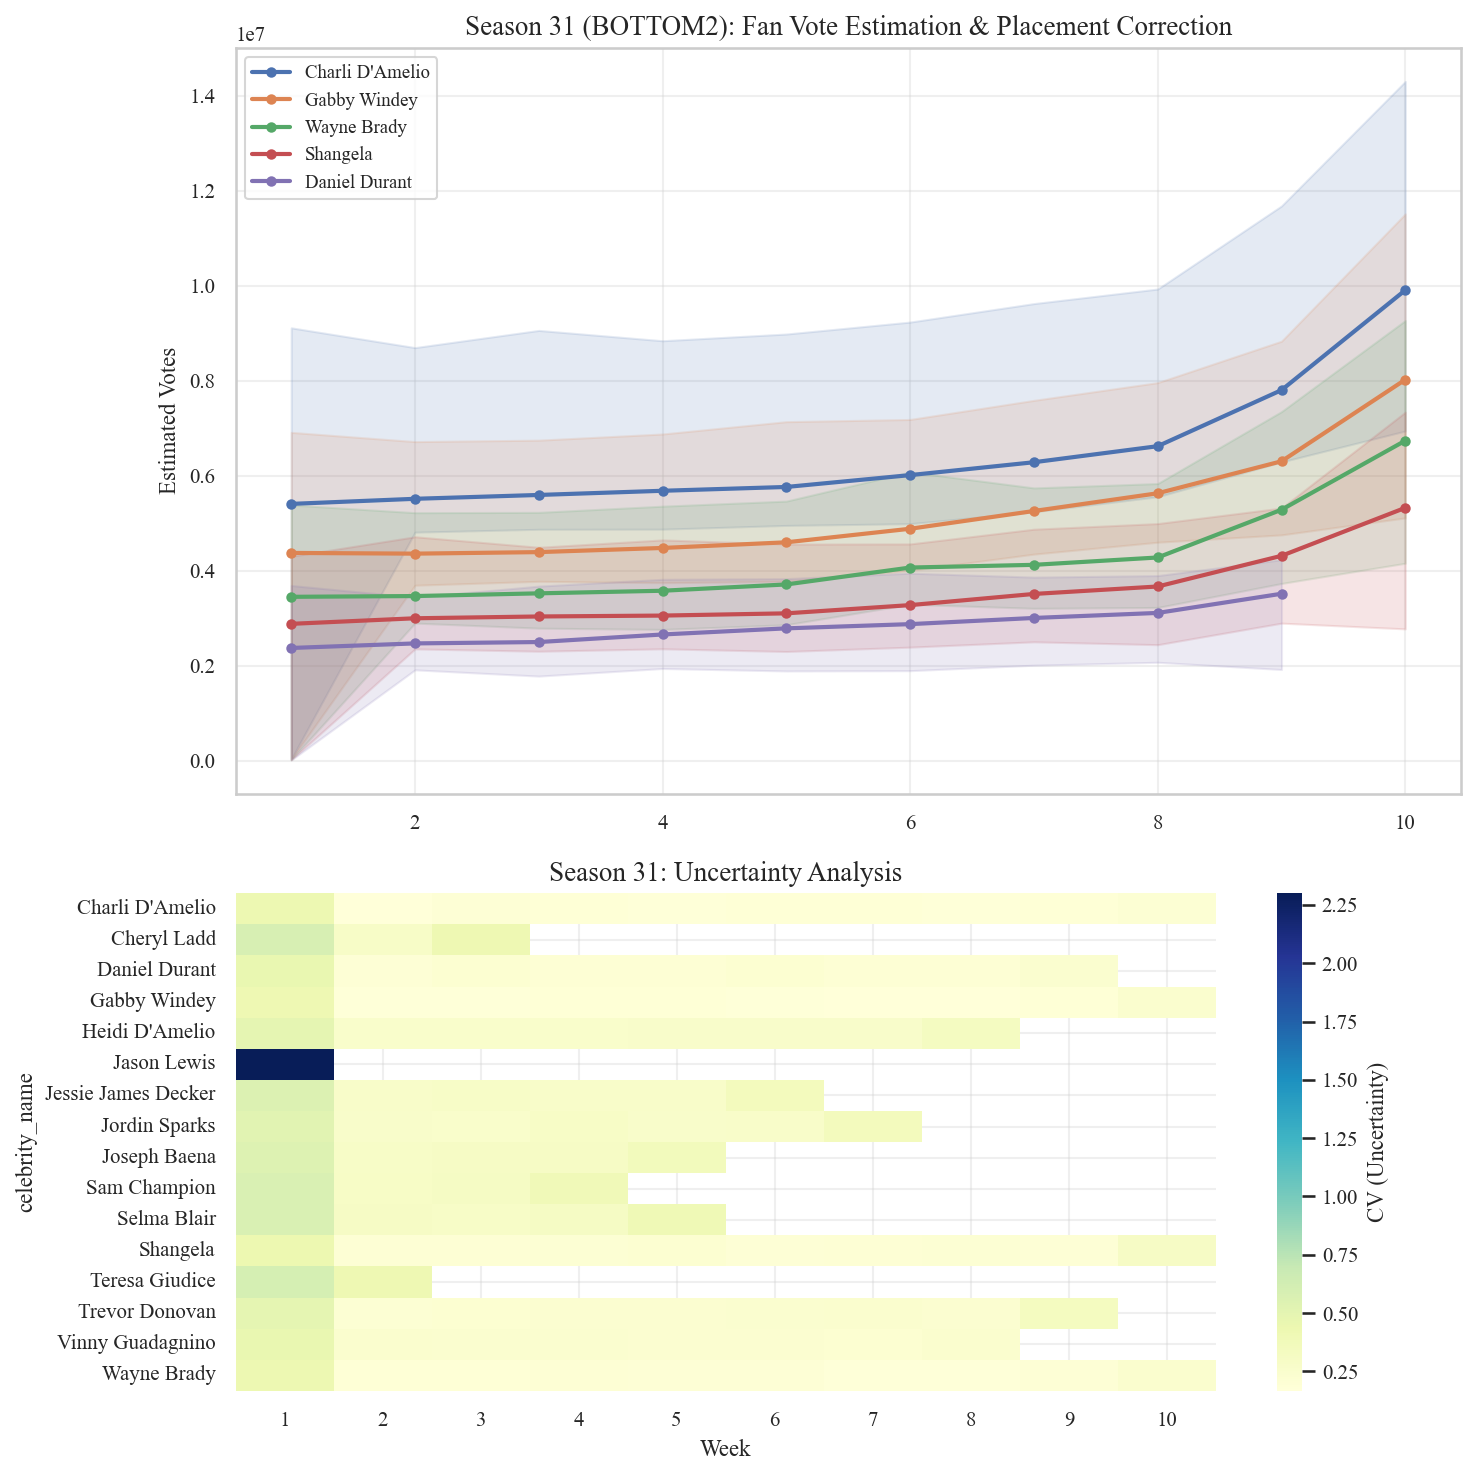


--- Processing Season 32 ---


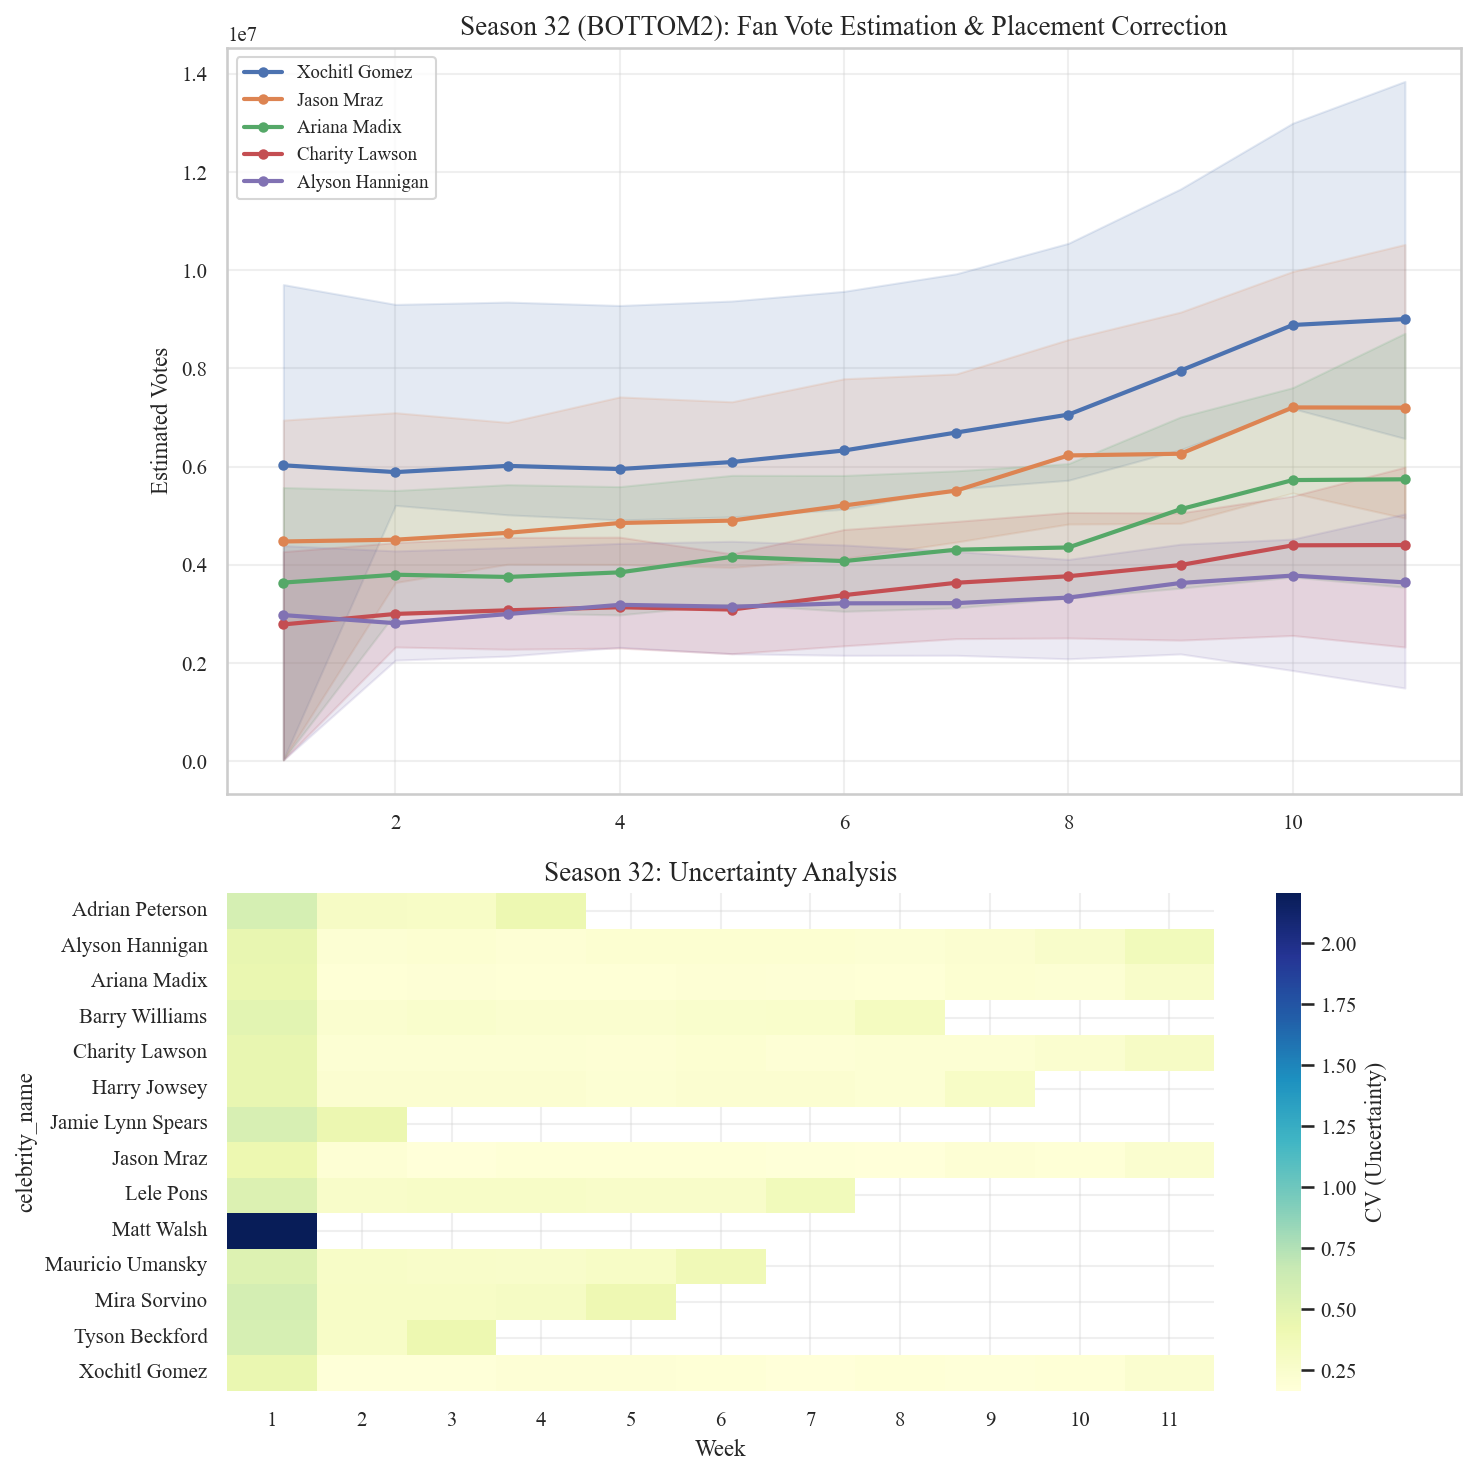


--- Processing Season 33 ---


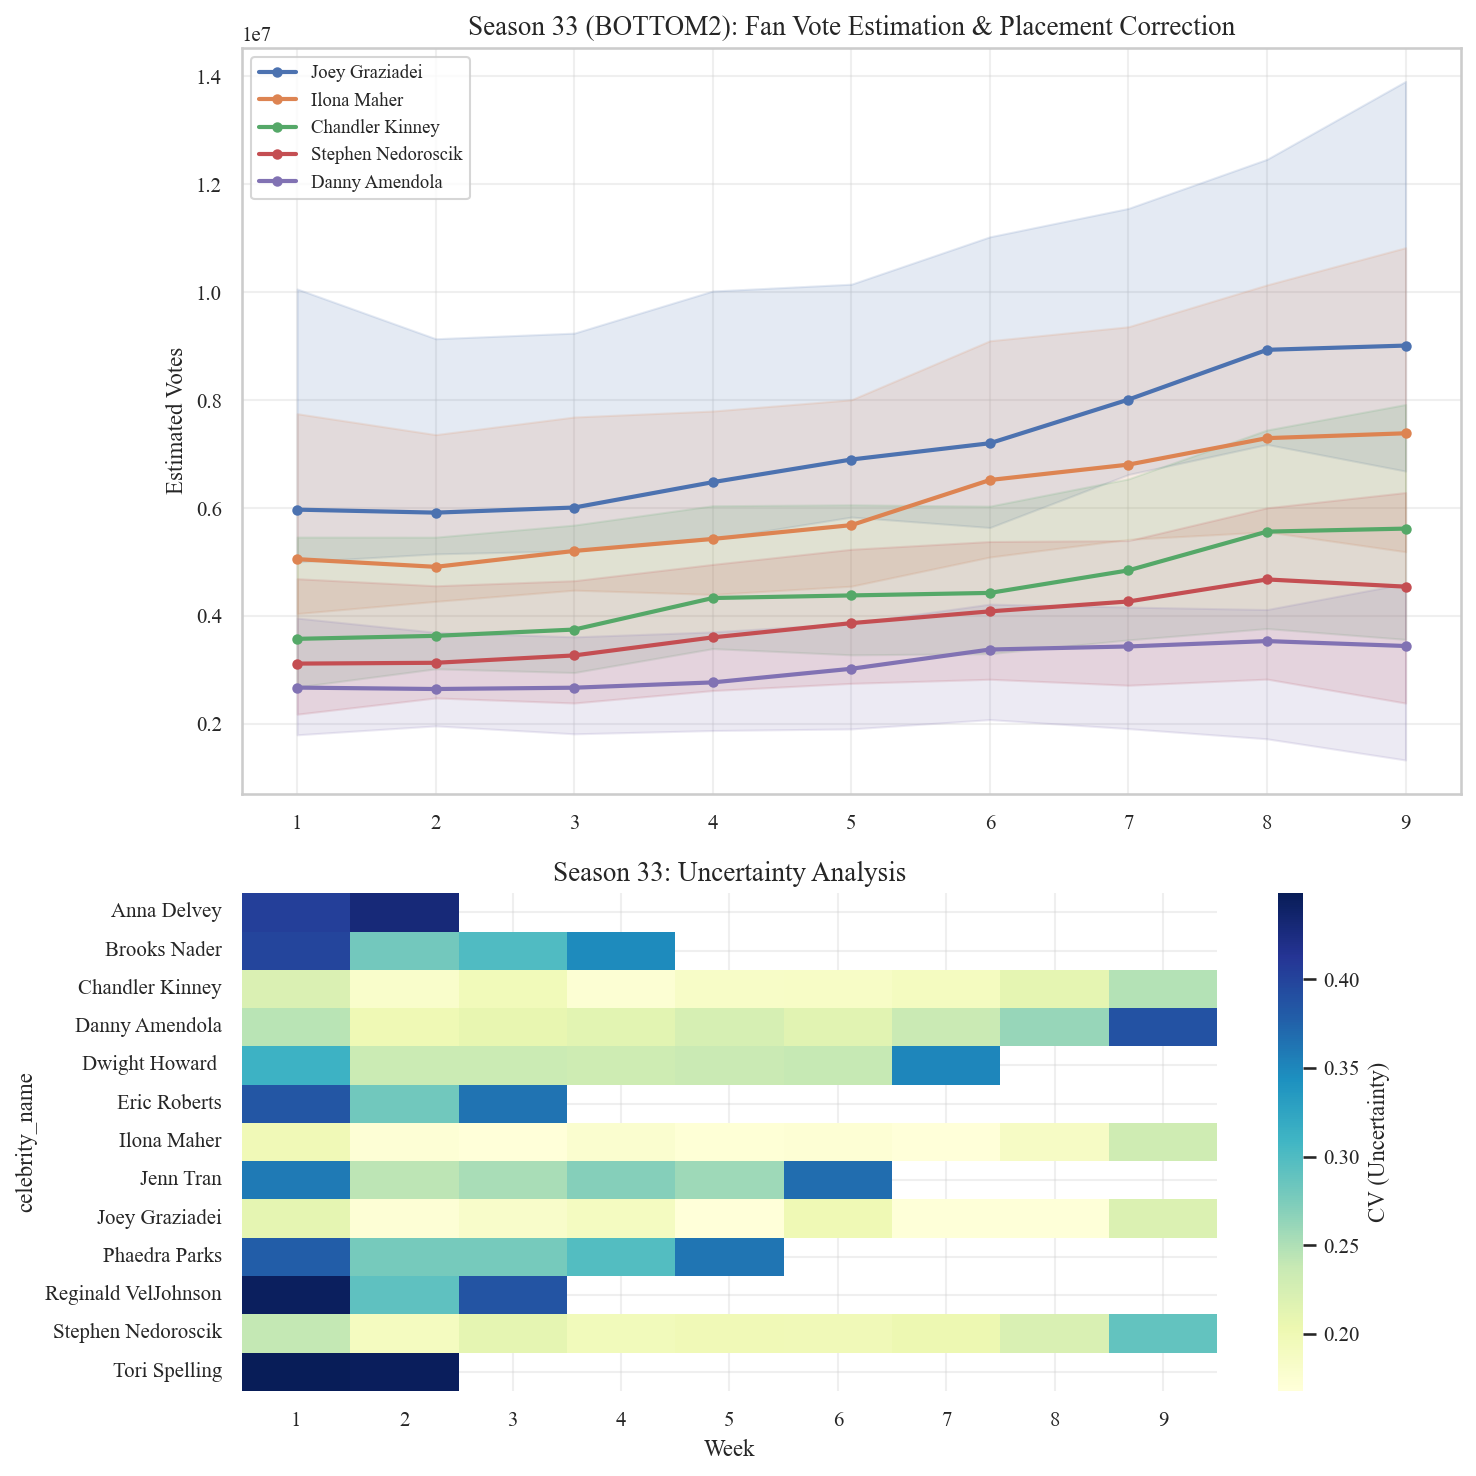


--- Processing Season 34 ---


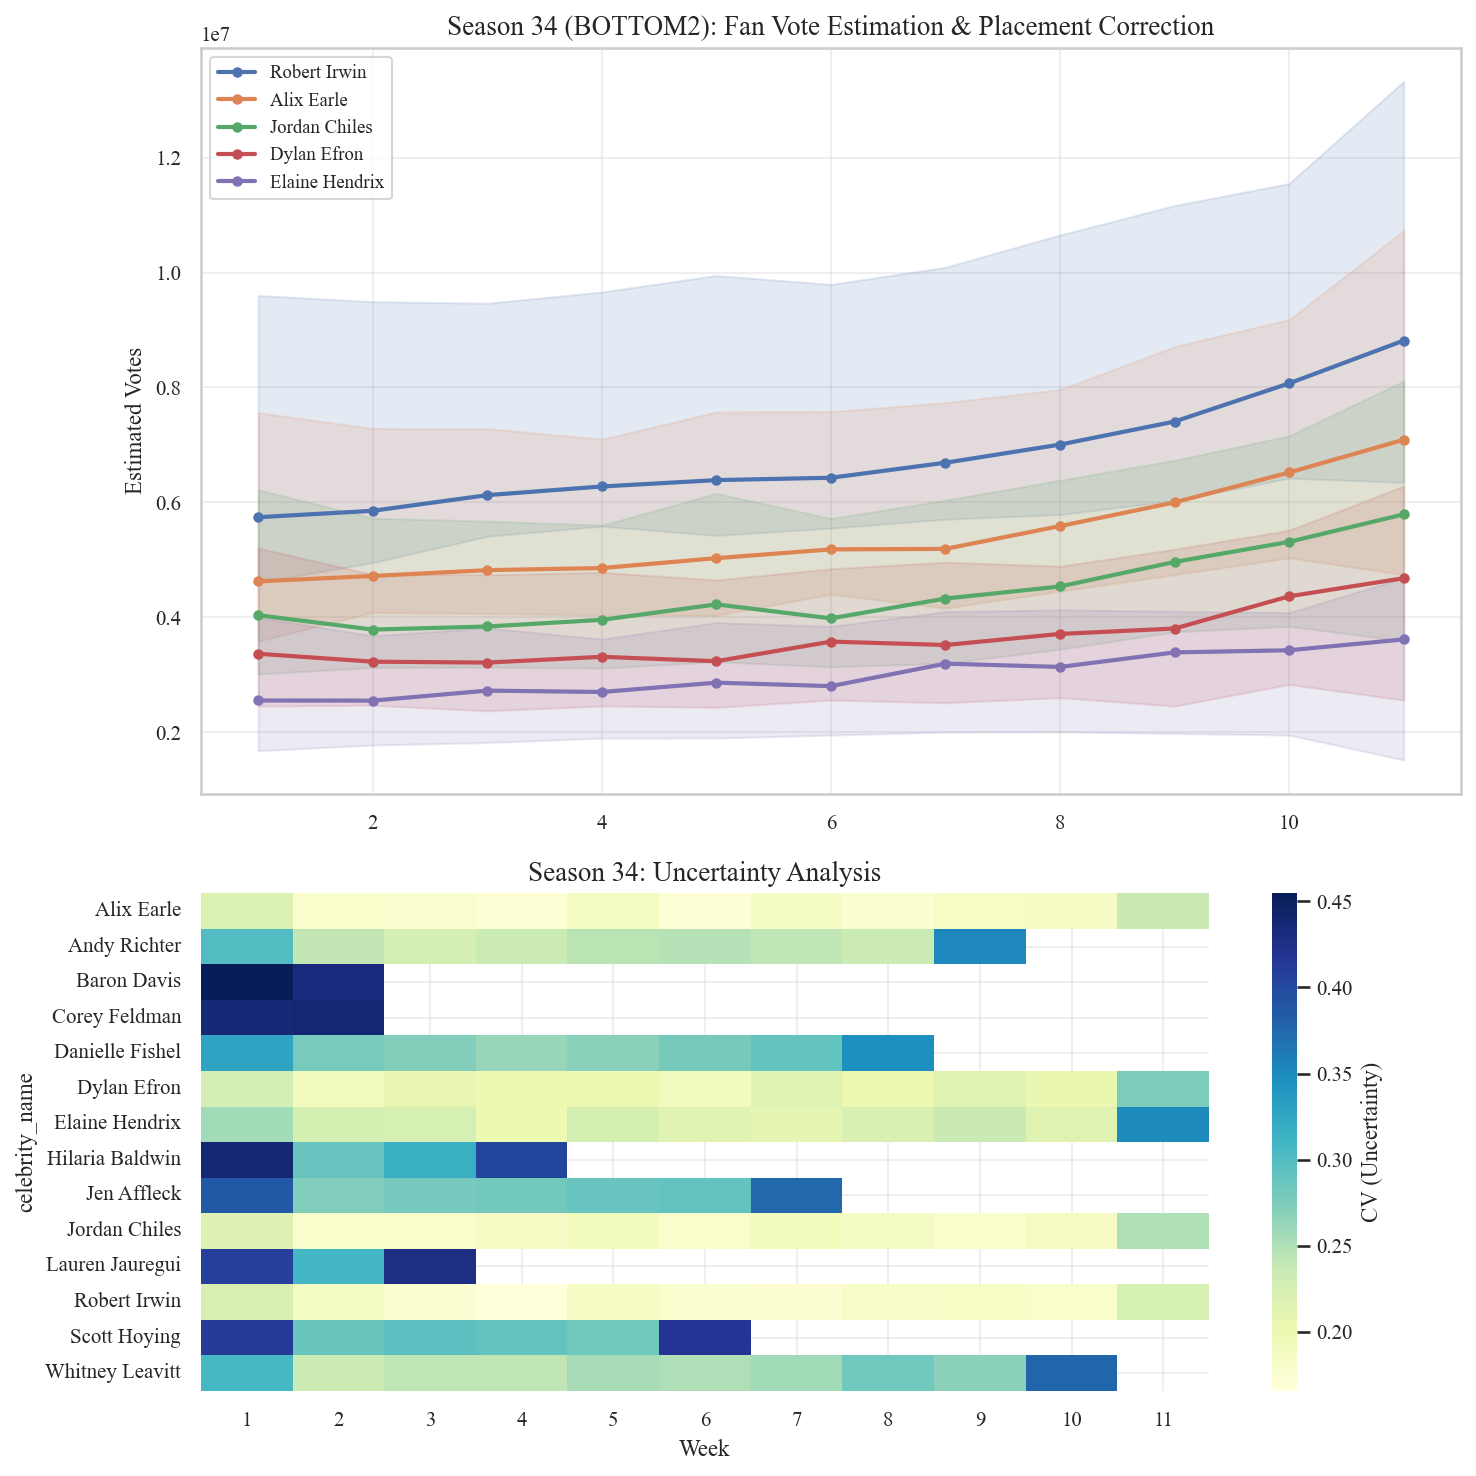


=== Survival Hit Rate ===
 season  hit_rate  avg_margin
      1  1.000000    0.068275
      2  1.000000    0.048891
      3  1.000000    0.032395
      4  0.875000    0.029007
      5  0.888889    0.023905
      6  1.000000    0.026269
      7  1.000000    0.033478
      8  1.000000    0.029655
      9  1.000000    0.021418
     10  0.875000    0.033133
     11  1.000000    0.028522
     12  1.000000    0.034618
     13  1.000000    0.032141
     14  1.000000    0.026387
     15  1.000000    0.016856
     16  1.000000    0.037119
     17  0.888889    0.022694
     18  1.000000    0.025940
     19  0.900000    0.022955
     20  0.875000    0.019379
     21  1.000000    0.025047
     22  1.000000    0.017212
     23  0.888889    0.023061
     24  1.000000    0.020841
     25  0.875000    0.022309
     26  1.000000    0.023999
     27  1.000000    0.013507
     28  1.000000    0.025275
     29  1.000000    0.017525
     30  0.875000    0.019697
     31  0.888889    0.013469
     32  0.88

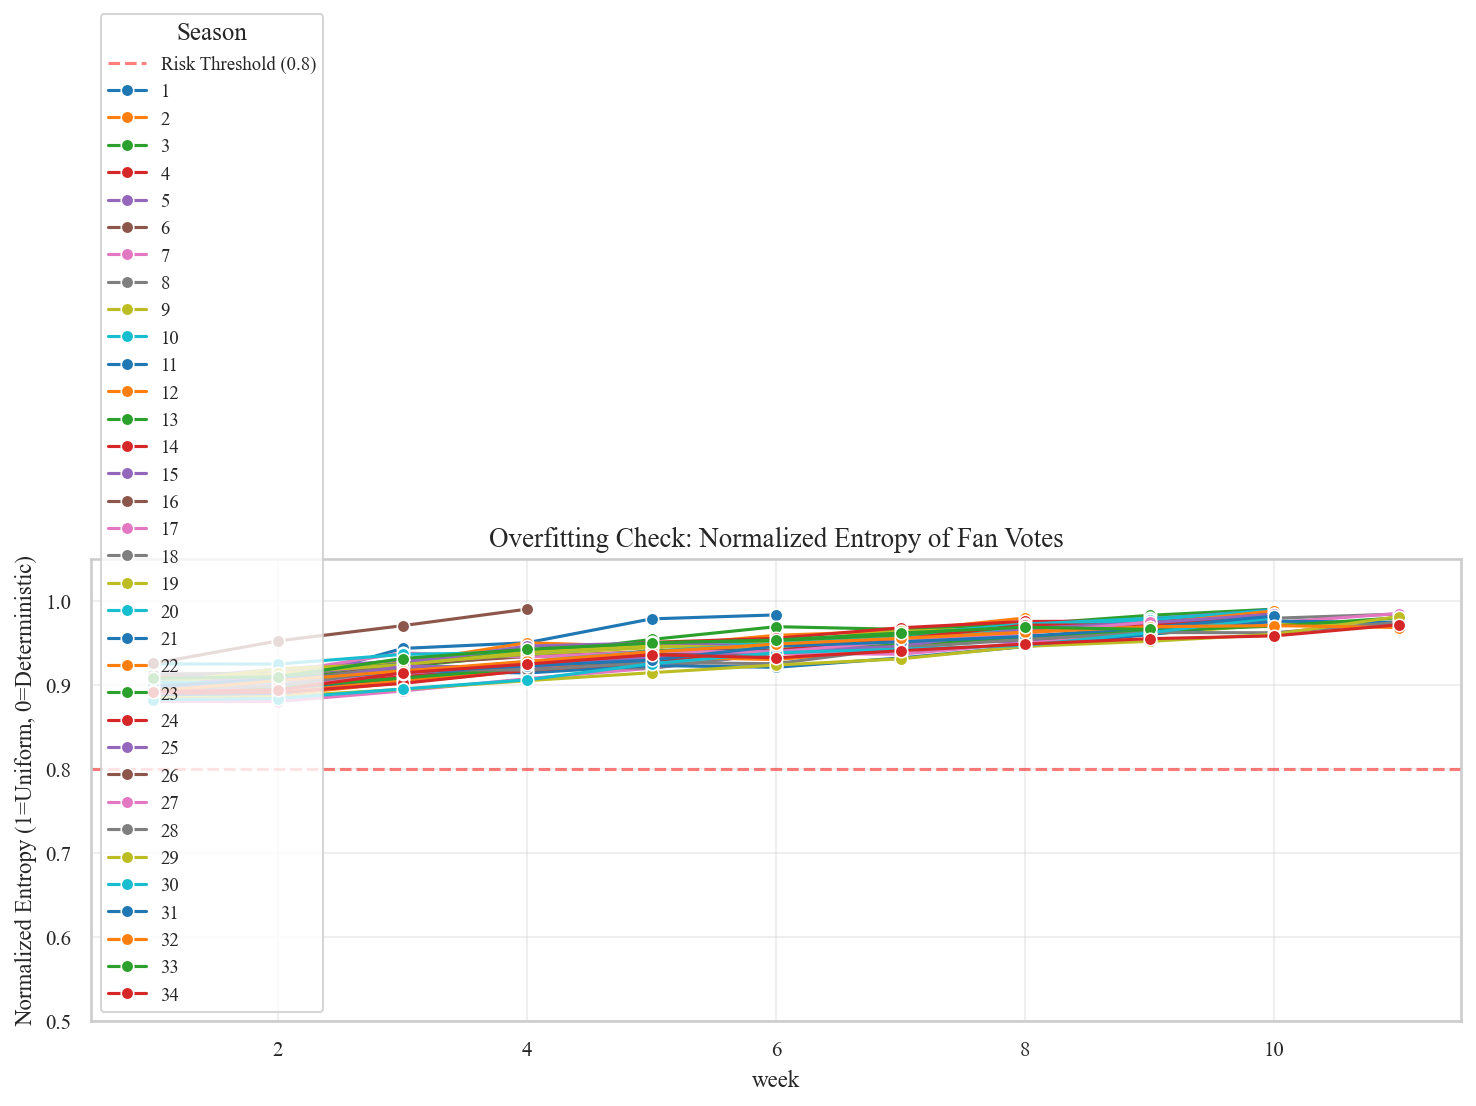


=== Overfitting Check Table ===
 Season  Weeks  Avg Entropy  Min Entropy  Volatility
      1      6     0.943051     0.901563    0.035480
      2      8     0.940733     0.892526    0.029257
      3     10     0.949128     0.893546    0.032991
      4     10     0.949445     0.909008    0.027242
      5     10     0.946624     0.905900    0.026864
      6     10     0.943572     0.902662    0.028853
      7     10     0.944315     0.892399    0.027232
      8     11     0.947453     0.912775    0.023981
      9     10     0.946756     0.901851    0.026511
     10     10     0.951534     0.924587    0.021879
     11     10     0.936128     0.882011    0.036179
     12     10     0.933881     0.887318    0.033691
     13     10     0.945214     0.898487    0.026425
     14     10     0.937837     0.895620    0.031781
     15     10     0.943914     0.899159    0.026471
     16     10     0.933554     0.893622    0.027744
     17     11     0.929246     0.880024    0.036497
     18     1

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata, entropy
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings

# 忽略数值计算警告
warnings.filterwarnings('ignore')

# -----------------------
# 全局常量
# -----------------------
TOTAL_VOTES = 30_000_000  # 假设每周 3000 万票
SEED = 2026

# -----------------------
# 0) 数据结构与预处理
# -----------------------

@dataclass
class WeekEvent:
    season: int
    week: int
    rule: str               # "RANK", "PERCENT", "BOTTOM2"
    active_names: List[str] # 当周参赛选手
    eliminated: List[str]   # 当周淘汰者
    j_scores: np.ndarray    # 评委原始分
    j_percent: np.ndarray   # 评委分占比
    j_rank: np.ndarray      # 评委排名 (1=Best)
    placements: np.ndarray  # [核心修复] 最终名次 (1=Winner, 999=Unknown)
    k_elim: int             # 淘汰人数
    is_z_week: bool         # 是否无淘汰周

def get_season_rule(season: int) -> str:
    if season <= 2: return "RANK"
    elif season <= 27: return "PERCENT"
    else: return "BOTTOM2"  # S28+

def calculate_ranks_desc(scores: np.ndarray) -> np.ndarray:
    """计算排名：分数越高，排名越小(1)。"""
    return rankdata(-scores, method='min')

def load_data(csv_path: str, target_seasons: List[int]) -> Tuple[pd.DataFrame, Dict[Tuple[int, int], WeekEvent]]:
    df = pd.read_csv(csv_path)
    
    # [核心修复] 解析 placement 列，处理非数值情况
    def safe_parse_place(x):
        try:
            return float(x)
        except:
            return 999.0 # 无效或未知的名次
            
    df['placement_num'] = df['placement'].apply(safe_parse_place).fillna(999.0)

    # 转长表
    week_cols = [c for c in df.columns if "week" in c and "judge" in c]
    long_df = df.melt(
        id_vars=["season", "celebrity_name", "results", "placement_num"],
        value_vars=week_cols,
        var_name="wk_str", value_name="score"
    )
    long_df["week"] = long_df["wk_str"].str.extract(r"week(\d+)_").astype(int)
    long_df["score"] = pd.to_numeric(long_df["score"], errors="coerce")
    
    # 聚合每周总分
    wk_tot = long_df.groupby(["season", "week", "celebrity_name", "results", "placement_num"])["score"].sum(min_count=1).reset_index()
    
    # 标记 Active (分数 > 0)
    wk_tot = wk_tot[wk_tot["score"].fillna(0) > 0].copy()
    
    # 解析淘汰周
    def parse_elim(res, wk):
        if pd.isna(res): return False
        s_res = str(res)
        if "Eliminated Week" in s_res:
            try:
                elim_w = int(s_res.split("Week ")[1])
                return elim_w == wk
            except: return False
        return False

    wk_tot["is_elim"] = wk_tot.apply(lambda x: parse_elim(x["results"], x["week"]), axis=1)

    events = {}
    for (s, w), g in wk_tot.groupby(["season", "week"]):
        if s not in target_seasons: continue
        
        # 按名字排序确保索引对齐
        g = g.sort_values("celebrity_name")
        
        names = g["celebrity_name"].tolist()
        scores = g["score"].values
        elim_names = g[g["is_elim"]]["celebrity_name"].tolist()
        places = g["placement_num"].values # 提取名次
        
        # 计算评委指标
        j_sum = scores.sum()
        j_percent = scores / j_sum if j_sum > 0 else np.zeros_like(scores)
        j_rank = calculate_ranks_desc(scores)
        
        rule = get_season_rule(s)
        
        events[(s, w)] = WeekEvent(
            season=s, week=w, rule=rule,
            active_names=names,
            eliminated=elim_names,
            j_scores=scores,
            j_percent=j_percent,
            j_rank=j_rank,
            placements=places, # 存入事件
            k_elim=len(elim_names),
            is_z_week=(len(elim_names) == 0)
        )
        
    return wk_tot, events

# -----------------------
# 1) 模型 A：优化 (Max Entropy + Smoothing + Rank Constraints)
# -----------------------
def estimate_model_a(season_events: List[WeekEvent], smooth_lambda=50.0) -> pd.DataFrame:
    # 确保按周排序
    season_events.sort(key=lambda x: x.week)
    results = []
    
    for ev in season_events:
        n = len(ev.active_names)
        # 初始猜测：均匀分布
        x0 = np.ones(n) / n
        
        def obj_func(v):
            # 最大熵目标 + 平滑正则
            ent = np.sum(v * np.log(v + 1e-9)) 
            reg = np.sum((v - 1/n)**2)
            return ent + smooth_lambda * reg

        # 基础约束: 概率和为 1
        cons = [{'type': 'eq', 'fun': lambda v: np.sum(v) - 1.0}]
        
        # --- 约束 1: 淘汰生存 (幸存者 > 淘汰者) ---
        if ev.k_elim > 0:
            elim_indices = [i for i, name in enumerate(ev.active_names) if name in ev.eliminated]
            safe_indices = [i for i, name in enumerate(ev.active_names) if name not in ev.eliminated]
            
            if safe_indices:
                for ei in elim_indices:
                    for si in safe_indices:
                        # 逻辑：Total(Safe) >= Total(Elim)
                        diff_j = ev.j_percent[si] - ev.j_percent[ei]
                        cons.append({'type': 'ineq', 'fun': lambda v, si=si, ei=ei, dj=diff_j: v[si] - v[ei] + dj})

        # --- [新增] 约束 2: 同周淘汰者内部排序 (Better Place > Worse Place) ---
        if ev.k_elim > 1:
            elim_indices = [i for i, name in enumerate(ev.active_names) if name in ev.eliminated]
            elim_with_place = []
            for idx in elim_indices:
                place = ev.placements[idx]
                if place != 999: # 过滤无效名次
                    elim_with_place.append((idx, place))
            
            # 按名次升序 (1st, 2nd...)
            elim_with_place.sort(key=lambda x: x[1])
            
            for k in range(len(elim_with_place) - 1):
                best_i, best_p = elim_with_place[k]
                worse_i, worse_p = elim_with_place[k+1]
                if best_p < worse_p:
                    diff_j = ev.j_percent[best_i] - ev.j_percent[worse_i]
                    cons.append({'type': 'ineq', 'fun': lambda v, bi=best_i, wi=worse_i, dj=diff_j: v[bi] - v[wi] + dj})

        # --- 约束 3: 决赛/全局名次软约束 ---
        ranked_indices = [i for i, p in enumerate(ev.placements) if p != 999]
        if len(ranked_indices) > 1:
            sorted_idx = sorted(ranked_indices, key=lambda i: ev.placements[i])
            for k in range(len(sorted_idx) - 1):
                best_i = sorted_idx[k]
                worse_i = sorted_idx[k+1]
                diff_j = ev.j_percent[best_i] - ev.j_percent[worse_i]
                # 给予 0.1% 容错，避免与硬约束冲突
                cons.append({'type': 'ineq', 'fun': lambda v, bi=best_i, wi=worse_i, dj=diff_j: v[bi] - v[wi] + dj + 0.001})

        bounds = [(1e-4, 1.0) for _ in range(n)]
        
        # 求解
        res = minimize(obj_func, x0, bounds=bounds, constraints=cons, method='SLSQP', options={'maxiter': 200})
        
        v_hat = res.x / res.x.sum()
        for i, name in enumerate(ev.active_names):
            results.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "vote_share_A": v_hat[i],
                "model_a_success": res.success
            })
    
    # 【关键】这里必须返回 DataFrame，不能没有 return
    return pd.DataFrame(results)


        

# -----------------------
# 2) 模型 B：贝叶斯 MAP + 采样 (Ranking Likelihood)
# -----------------------
def estimate_model_b(season_events: List[WeekEvent], 
                     sigma_rw=0.5, kappa=40.0, n_samples=500) -> Tuple[pd.DataFrame, pd.DataFrame]:
    season_events.sort(key=lambda x: x.week)
    
    # 1. 参数映射
    unique_keys = []
    for ev in season_events:
        for name in ev.active_names:
            unique_keys.append((ev.week, name))
    unique_keys = list(dict.fromkeys(unique_keys))
    key_to_idx = {k: i for i, k in enumerate(unique_keys)}
    n_params = len(unique_keys)
    
    def get_indices(ev):
        return [key_to_idx[(ev.week, n)] for n in ev.active_names]

    def softmax(u):
        e = np.exp(u - np.max(u))
        return e / np.sum(e)

    # 2. 后验函数
    def neg_log_posterior(u_vec):
        loss = 0.0
        
        # A. Prior: Random Walk (保持不变)
        player_dict = {}
        for (wk, name), idx in key_to_idx.items():
            player_dict.setdefault(name, []).append((wk, idx))
            
        for name, seq in player_dict.items():
            seq.sort()
            for k in range(len(seq) - 1):
                w1, idx1 = seq[k]
                w2, idx2 = seq[k+1]
                if w2 == w1 + 1:
                    loss += 0.5 * ((u_vec[idx2] - u_vec[idx1]) / sigma_rw) ** 2
        
        # B, C, D. Likelihoods
        for ev in season_events:
            idxs = get_indices(ev)
            current_u = u_vec[idxs]
            v_share = softmax(current_u)
            # --- Likelihood B: 幸存者 vs 淘汰者 (保持不变) ---
            if ev.k_elim > 0:
                elim_idxs = [i for i, n in enumerate(ev.active_names) if n in ev.eliminated]
                safe_idxs = [i for i, n in enumerate(ev.active_names) if n not in ev.eliminated]
                
                if elim_idxs and safe_idxs:
                    for ei in elim_idxs:
                        score_e = ev.j_percent[ei] + v_share[ei]
                        for si in safe_idxs:
                            score_s = ev.j_percent[si] + v_share[si]
                            diff = score_s - score_e
                            loss += np.log(1 + np.exp(-kappa * diff))
         # --- [新增] Likelihood D: 同周淘汰者内部排序 ---
            # 针对本周被淘汰的群体，必须满足 Placement 顺序
            if ev.k_elim > 1:
                elim_idxs = [i for i, n in enumerate(ev.active_names) if n in ev.eliminated]
                
                # 提取 (index, placement) 并过滤无效值
                elim_subset = []
                for idx in elim_idxs:
                    place = ev.placements[idx]
                    if place != 999:
                        elim_subset.append((idx, place))
                
                # 排序: 名次好的(数值小)在前
                elim_subset.sort(key=lambda x: x[1])
                
                # 链式比较
                for k in range(len(elim_subset) - 1):
                    bi, bp = elim_subset[k]   # Better (e.g. 9th)
                    wi, wp = elim_subset[k+1] # Worse  (e.g. 10th)
                    
                    if bp < wp:
                        score_b = ev.j_percent[bi] + v_share[bi]
                        score_w = ev.j_percent[wi] + v_share[wi]
                        diff = score_b - score_w
                        # 我们期望 diff > 0。如果 diff < 0，log(1+exp(-diff)) 会增大 Loss
                        # 使用更高的 kappa (比如 1.5倍) 强化这种确定的事实
                        loss += np.log(1 + np.exp(-kappa * 1.5 * diff))
             # --- Likelihood C: 全局名次顺序 (保持不变，作为软约束) ---
            ranked_indices = [i for i, p in enumerate(ev.placements) if p != 999]
            if len(ranked_indices) > 1:
                sorted_idx = sorted(ranked_indices, key=lambda i: ev.placements[i])
                for k in range(len(sorted_idx) - 1):
                    bi = sorted_idx[k]     
                    wi = sorted_idx[k+1]   
                    score_b = ev.j_percent[bi] + v_share[bi]
                    score_w = ev.j_percent[wi] + v_share[wi]
                    diff = score_b - score_w
                    loss += np.log(1 + np.exp(-kappa * diff))

        loss += 1e-4 * np.sum(u_vec**2) # L2 Regularization
        return loss

    # 3. 优化与采样
    u0 = np.zeros(n_params)
    res = minimize(neg_log_posterior, u0, method='L-BFGS-B', options={'maxiter': 1000})
    u_map = res.x
    
    # Laplace Approximation
    h = 1e-3
    hess_diag = []
    base_loss = neg_log_posterior(u_map)
    for i in range(n_params):
        u_p = u_map.copy(); u_p[i] += h
        u_m = u_map.copy(); u_m[i] -= h
        l_p = neg_log_posterior(u_p)
        l_m = neg_log_posterior(u_m)
        d2 = max((l_p + l_m - 2*base_loss)/(h**2), 1e-2)
        hess_diag.append(d2)
    std_vec = 1.0 / np.sqrt(np.array(hess_diag))
    
    rng = np.random.default_rng(SEED)
    samples = rng.normal(u_map, std_vec, size=(n_samples, n_params))
    
    map_rows = []
    unc_rows = []
    
    for ev in season_events:
        idxs = get_indices(ev)
        v_map_val = softmax(u_map[idxs])
        v_samples_block = np.array([softmax(row[idxs]) for row in samples])
        
        for i, name in enumerate(ev.active_names):
            map_rows.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "vote_share_B": v_map_val[i]
            })
            
            mean_v = np.mean(v_samples_block[:, i])
            std_v = np.std(v_samples_block[:, i])
            unc_rows.append({
                "season": ev.season, "week": ev.week, "celebrity_name": name,
                "mean_share": mean_v, "std_share": std_v, 
                "low_share": np.percentile(v_samples_block[:, i], 5), 
                "high_share": np.percentile(v_samples_block[:, i], 95),
                "cv": std_v / (mean_v + 1e-9)
            })
            
    return pd.DataFrame(map_rows), pd.DataFrame(unc_rows)

# -----------------------
# 3) 评估与辅助功能
# -----------------------
def evaluate_metrics(events: Dict, df_ens: pd.DataFrame) -> pd.DataFrame:
    metrics = []
    seasons = df_ens["season"].unique()
    
    for s in seasons:
        s_evs = [e for k, e in events.items() if k[0] == s]
        s_evs.sort(key=lambda x: x.week)
        hits, total_elim = 0, 0
        margins = []
        
        for ev in s_evs:
            if ev.k_elim == 0: continue
            total_elim += 1
            sub = df_ens[(df_ens["season"] == s) & (df_ens["week"] == ev.week)]
            if sub.empty: continue
            
            name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
            v_share = np.array([name_map.get(n, 0) for n in ev.active_names])
            
            # 使用统一 Score 评估
            combined = ev.j_percent + v_share
            sorted_idx = np.argsort(combined) # 0 is lowest
            
            bottom_names = [ev.active_names[i] for i in sorted_idx[:ev.k_elim]]
            
            if set(ev.eliminated).issubset(set(bottom_names)):
                hits += 1
                
            if len(sorted_idx) > ev.k_elim:
                safe_score = combined[sorted_idx[ev.k_elim]]
                danger_score = combined[sorted_idx[ev.k_elim-1]]
                margins.append(safe_score - danger_score)
                
        metrics.append({
            "season": s,
            "hit_rate": hits / total_elim if total_elim else 0,
            "avg_margin": np.mean(margins) if margins else 0
        })
    return pd.DataFrame(metrics)

# -----------------------
# 4) 可视化 (SCI Style + Heatmap)
# -----------------------
def init_sci_style():
    sns.set_style("whitegrid")
    plt.rcParams.update({
        "font.family": "serif",
        "axes.labelsize": 11,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 9,
        "figure.dpi": 150
    })

def plot_season_analysis(season, df_ens, df_unc, events):
    init_sci_style()
    s_df = df_ens[df_ens["season"] == season]
    u_df = df_unc[df_unc["season"] == season]
    if s_df.empty: return

    # Top 5 选手
    top_names = s_df.groupby("celebrity_name")["votes_ens"].mean().nlargest(5).index.tolist()
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1.5, 1]})
    
    # 子图1：票数趋势
    ax = axes[0]
    colors = sns.color_palette("deep", n_colors=len(top_names))
    for i, name in enumerate(top_names):
        d = s_df[s_df["celebrity_name"] == name]
        u = u_df[u_df["celebrity_name"] == name]
        weeks = d["week"].values
        v_mean = d["votes_ens"].values
        v_high = u["high_share"].values * TOTAL_VOTES
        v_low = u["low_share"].values * TOTAL_VOTES
        ax.plot(weeks, v_mean, label=name, color=colors[i], linewidth=2, marker='o', markersize=4)
        ax.fill_between(weeks, v_low, v_high, color=colors[i], alpha=0.15)
    
    rule = get_season_rule(season)
    ax.set_title(f"Season {season} ({rule}): Fan Vote Estimation & Placement Correction")
    ax.set_ylabel("Estimated Votes")
    ax.legend(loc='upper left')
    
    # 子图2：不确定性 (CV) 热力图
    ax2 = axes[1]
    piv = u_df.pivot(index="celebrity_name", columns="week", values="cv")
    sns.heatmap(piv, ax=ax2, cmap="YlGnBu", cbar_kws={'label': 'CV (Uncertainty)'})
    ax2.set_title(f"Season {season}: Uncertainty Analysis")
    ax2.set_xlabel("Week")
    
    plt.tight_layout()
    plt.show()

# -----------------------
# 5) 过拟合检验 (Entropy Analysis)
# -----------------------
def analyze_entropy_overfitting(df_ens: pd.DataFrame):
    entropy_records = []
    groups = df_ens.groupby(['season', 'week'])
    
    for (s, w), g in groups:
        votes = g['vote_share_ens'].values
        votes = votes / np.sum(votes)
        n = len(votes)
        if n <= 1: continue
        
        ent = entropy(votes) # Shannon Entropy
        max_ent = np.log(n)
        norm_ent = ent / max_ent
        
        entropy_records.append({
            "season": s, "week": w, "n_candidates": n,
            "shannon_entropy": ent, "normalized_entropy": norm_ent
        })
    return pd.DataFrame(entropy_records)

def plot_entropy_check(entropy_df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Risk Threshold (0.8)')
    sns.lineplot(data=entropy_df, x='week', y='normalized_entropy', hue='season', palette='tab10', marker='o')
    plt.title('Overfitting Check: Normalized Entropy of Fan Votes')
    plt.ylabel('Normalized Entropy (1=Uniform, 0=Deterministic)')
    plt.ylim(0.5, 1.05)
    plt.legend(title='Season', loc='lower left')
    plt.tight_layout()
    plt.show()

def generate_entropy_table(entropy_df: pd.DataFrame):
    summary = entropy_df.groupby('season')['normalized_entropy'].agg(['count', 'mean', 'min', 'std']).reset_index()
    summary.columns = ['Season', 'Weeks', 'Avg Entropy', 'Min Entropy', 'Volatility']
    print("\n=== Overfitting Check Table ===")
    print(summary.to_string(index=False))
    return summary

# -----------------------
# 主程序
# -----------------------
if __name__ == "__main__":
    csv_path = "2026_MCM_Problem_C_Data.csv"
    target_seasons = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]
    
    try:
        print("Loading data...")
        wk_tot, events = load_data(csv_path, target_seasons)
        
        all_ens = []
        all_unc = []
        
        for s in target_seasons:
            print(f"\n--- Processing Season {s} ---")
            s_events = [e for k, e in events.items() if k[0] == s]
            
            # Model A (With Constraints)
            df_a = estimate_model_a(s_events, smooth_lambda=20.0)
            
            # Model B (Bayesian MAP with Placement Likelihood)
            df_b, df_unc_s = estimate_model_b(s_events, sigma_rw=0.4, kappa=50.0)
            
            # Ensemble
            df_merge = pd.merge(df_a, df_b, on=["season", "week", "celebrity_name"])
            w_b = 0.75 # B model handles placements better
            df_merge["vote_share_ens"] = w_b * df_merge["vote_share_B"] + (1 - w_b) * df_merge["vote_share_A"]
            df_merge["votes_ens"] = df_merge["vote_share_ens"] * TOTAL_VOTES
            
            all_ens.append(df_merge)
            all_unc.append(df_unc_s)
            
            # Plot
            plot_season_analysis(s, df_merge, df_unc_s, events)
            
        final_ens = pd.concat(all_ens)
        
        # Metrics
        print("\n=== Survival Hit Rate ===")
        print(evaluate_metrics(events, final_ens).to_string(index=False))
        
        # Entropy Check
        ent_df = analyze_entropy_overfitting(final_ens)
        plot_entropy_check(ent_df)
        generate_entropy_table(ent_df)
        
        print("\nTask 1 completed. 'final_ens' DataFrame is ready in memory.")
        
    except FileNotFoundError:
        print("Error: CSV not found.")
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
# ==============================================================================
# [Task 2] 独立仿真模块 (修正: 决赛周强制无淘汰)
# ==============================================================================

import pandas as pd
import numpy as np
from scipy.stats import rankdata
from collections import defaultdict

class Task2Simulator:
    def __init__(self, events_dict, vote_df):
        """
        events_dict: Task 1 的 events 字典 {(season, week): WeekEvent}
        vote_df: Task 1 输出的 final_ens DataFrame
        """
        self.events = events_dict
        self.vote_df = vote_df
        self.simulation_results = []
        
        # 1. 预计算每一季的决赛周（最大周数）
        season_weeks = defaultdict(list)
        for (s, w) in self.events.keys():
            season_weeks[s].append(w)
        self.season_max_week = {s: max(weeks) for s, weeks in season_weeks.items()}
        
        # 2. 维护每一季的“实际已淘汰名单”历史
        self.eliminated_history = defaultdict(list)

    def _get_fan_shares(self, season, week, active_names):
        sub = self.vote_df[(self.vote_df["season"] == season) & (self.vote_df["week"] == week)]
        if sub.empty:
            return np.ones(len(active_names)) / len(active_names)
        name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
        shares = np.array([name_map.get(n, 0.0) for n in active_names])
        if shares.sum() > 0: shares = shares / shares.sum()
        return shares

    def _calculate_rank_order(self, j_scores, fan_shares, active_names):
        """计算在场选手的 Rank 顺序 (1st ... Last)"""
        j_rank = rankdata(-j_scores, method='min')
        f_rank = rankdata(-fan_shares, method='min')
        total_rank = j_rank + f_rank
        
        candidates = []
        for i, name in enumerate(active_names):
            candidates.append({
                'name': name,
                'score': total_rank[i],    # 越小越好
                'tie_break': fan_shares[i] # 越大越好
            })
        candidates.sort(key=lambda x: x['tie_break'], reverse=True) 
        candidates.sort(key=lambda x: x['score'], reverse=False)
        return [c['name'] for c in candidates]

    def _calculate_percent_order(self, j_scores, fan_shares, active_names):
        """计算在场选手的 Percent 顺序 (1st ... Last)"""
        total_j = j_scores.sum()
        j_pct = j_scores / total_j if total_j > 0 else np.zeros_like(j_scores)
        total_pct = j_pct + fan_shares
        
        candidates = []
        for i, name in enumerate(active_names):
            candidates.append({
                'name': name,
                'score': total_pct[i] # 越大越好
            })
        candidates.sort(key=lambda x: x['score'], reverse=True)
        return [c['name'] for c in candidates]

    def run(self):
        sorted_keys = sorted(self.events.keys())
        self.eliminated_history = defaultdict(list)
        
        for (s, w) in sorted_keys:
            ev = self.events[(s, w)]
            is_final_week = (w == self.season_max_week[s])
            
            if is_final_week:
                k_elim_processed = 0
                actual_elim_display = [] 
                week_type = 'Final'
            else:
                k_elim_processed = ev.k_elim
                actual_elim_display = ev.eliminated
                week_type = 'Elimination' if k_elim_processed > 0 else 'Non-Elim'
            
            active_names = ev.active_names
            fan_shares = self._get_fan_shares(s, w, active_names)
            
            # 4. 计算【在场选手】相对排名
            active_rank_order = self._calculate_rank_order(ev.j_scores, fan_shares, active_names)
            active_pct_order = self._calculate_percent_order(ev.j_scores, fan_shares, active_names)
            
            # 5. 构建【全员排名】
            # 历史回放：我们需要 [在场] + [刚淘汰(好->差)] + [早淘汰]
            # 这里 eliminated_history 存储顺序应为：[Week1淘汰, Week2差, Week2好, ...]
            # 逆序后变成：[Week2好, Week2差, Week1淘汰]
            past_eliminated_reversed = self.eliminated_history[s][::-1]
            full_rank_order = active_rank_order + past_eliminated_reversed
            full_pct_order = active_pct_order + past_eliminated_reversed
            
            # 6. 提取仿真数据
            is_rank_identical = (full_rank_order == full_pct_order)
            sim_rank_elim, sim_pct_elim = [], []
            is_elim_diff = False
            
            if k_elim_processed > 0:
                sim_rank_elim = active_rank_order[-k_elim_processed:] 
                sim_pct_elim = active_pct_order[-k_elim_processed:]
                is_elim_diff = (set(sim_rank_elim) != set(sim_pct_elim))
            
            sim_rank_winner = full_rank_order[0]
            sim_pct_winner = full_pct_order[0]
            is_winner_diff = (sim_rank_winner != sim_pct_winner)
            
            # --- [核心修复] 更新历史记录时的排序逻辑 ---
            if not is_final_week and ev.eliminated:
                # 1. 获取 (Name, Placement) 对
                elim_batch = []
                for name in ev.eliminated:
                    if name in ev.active_names:
                        idx = ev.active_names.index(name)
                        place = ev.placements[idx]
                        elim_batch.append((name, place))
                
                # 2. 排序逻辑：
                # 我们希望加入列表的顺序是 [第10名, 第9名]。
                # 这样被 [::-1] 逆序后，变成 [第9名, 第10名]，紧接在 active_names 后面。
                # Placement 数值：10 > 9。
                # 所以我们要按 Placement 降序排列 (Desc)。
                elim_batch.sort(key=lambda x: x[1], reverse=True)
                
                sorted_names = [x[0] for x in elim_batch]
                self.eliminated_history[s].extend(sorted_names)
            
            # 10. 记录
            self.simulation_results.append({
                'season': s, 'week': w, 'type': week_type,
                'k_elim': k_elim_processed,
                'is_rank_identical': is_rank_identical,
                'actual_elim': actual_elim_display,
                'sim_rank_elim': sim_rank_elim, 'sim_pct_elim': sim_pct_elim,
                'is_elim_diff': is_elim_diff,
                'sim_rank_winner': sim_rank_winner, 'sim_pct_winner': sim_pct_winner,
                'is_winner_diff': is_winner_diff,
                'full_rank_order': ",".join(full_rank_order),
                'full_pct_order': ",".join(full_pct_order)
            })
            
        return pd.DataFrame(self.simulation_results)

               

# --- 执行入口 ---
print("\n" + "="*50)
print("STARTING TASK 2 SIMULATION (Fix: No Elim in Finals)")
print("="*50)

# 运行
task2_sim = Task2Simulator(events, final_ens)
df_task2 = task2_sim.run()

# 保存
output_file = "task2_simulation_results_v3.csv" 
try:
    df_task2.to_csv(output_file, index=False)
    print(f"Task 2 仿真完成! 结果已保存至: {output_file}")
except PermissionError:
    print(f"错误: 无法写入 {output_file}。请关闭Excel后重试。")

# --- 验证 ---
finals = df_task2[df_task2['type'] == 'Final']
print("\n[验证决赛周状态]")
print(f"决赛周总数: {len(finals)}")
print(f"决赛周中 k_elim > 0 的数量: {len(finals[finals['k_elim'] > 0])} (应为0)")

In [4]:
# ==============================================================================
# [Validation] 深度验证：全员排名完全对比 (Full Ranking Exact Match)
# ==============================================================================

import pandas as pd
import numpy as np

def verify_full_ranking(original_data_path, simulation_result_path):
    print(f"\n{'='*20} 深度模型验证：S1-S27 全员排名对比 {'='*20}")
    
    # 1. 读取数据
    raw_df = pd.read_csv(original_data_path)
    sim_df = pd.read_csv(simulation_result_path)
    
    finals_sim = sim_df[sim_df['type'] == 'Final'].copy()
    
    validation_log = []
    
    # S1-S27: 原始规则区间
    for season in range(1, 28):
        # --- A. 获取真实全员排名 (Ground Truth) ---
        season_raw = raw_df[raw_df['season'] == season]
        
        # 提取有 placement 的人，按名次升序 (1, 2, 3...)
        # 必须过滤掉 placement 为 NaN 的行
        actual_df = season_raw.dropna(subset=['placement']).sort_values('placement')
        
        # 真实名单列表 (按名次排列: [冠军, 亚军, 季军, ...])
        actual_list = actual_df['celebrity_name'].tolist()
        
        # --- B. 获取仿真全员排名 (Simulation) ---
        if season not in finals_sim['season'].values:
            continue
        sim_row = finals_sim[finals_sim['season'] == season].iloc[0]
        
        # 根据赛季选择对应的规则列
        if season <= 2:
            rule = "Rank"
            sim_list_str = sim_row['full_rank_order']
        else:
            rule = "Percent"
            sim_list_str = sim_row['full_pct_order']
            
        sim_list = sim_list_str.split(',')
        
        # --- C. 对齐名单 ---
        # 仿真列表通常包含所有参赛者，而 raw_df 的 placement 可能不全
        # 或者 raw_df placement 包含所有人。我们需要取"交集"来对比相对顺序。
        # 逻辑：只对比 raw_df 中有名次的人在仿真里的相对顺序是否一致。
        
        # 从仿真列表中提取出 actual_list 里的人，保持仿真的相对顺序
        # 这样可以忽略掉那些数据里缺失 placement 的边缘人物
        sim_filtered = [name for name in sim_list if name in actual_list]
        
        # 同样，确保 actual_list 里的人都在 sim_list 里 (防止名字拼写不一致等问题)
        actual_filtered = [name for name in actual_list if name in sim_list]
        
        # --- D. 严格对比 ---
        is_exact_match = (actual_filtered == sim_filtered)
        
        # 计算相似度 (Kendall Tau 距离可能太复杂，这里直接用是否全对)
        # 也可以计算"位置偏差"：比如某人实际第5，仿真第6
        
        # 记录第一个不匹配的位置（如果有）
        mismatch_info = ""
        if not is_exact_match:
            for i, (act, sim) in enumerate(zip(actual_filtered, sim_filtered)):
                if act != sim:
                    mismatch_info = f"Pos {i+1}: Actual={act} vs Sim={sim}"
                    break
        
        validation_log.append({
            'Season': season,
            'Rule': rule,
            'Is_Perfect_Match': "✅" if is_exact_match else "❌",
            'Count_Actual': len(actual_filtered),
            'Count_Sim': len(sim_filtered),
            'Mismatch_Detail': mismatch_info,
            'Actual_List': str(actual_filtered),
            'Sim_List': str(sim_filtered)
        })

    # --- 输出 ---
    val_df = pd.DataFrame(validation_log)
    
    # 统计
    perfect_count = len(val_df[val_df['Is_Perfect_Match']=='✅'])
    total = len(val_df)
    print(f"\n[验证摘要]")
    print(f"完全匹配赛季: {perfect_count} / {total} ({perfect_count/total:.1%})")
    
    if perfect_count < total:
        print("\n[差异详情]")
        print(val_df[val_df['Is_Perfect_Match']=='❌'][['Season', 'Mismatch_Detail']])
    else:
        print("\n[完美!] S1-S27 所有排位完全一致。")
        
    val_df.to_csv("task2_validation_full_rank.csv", index=False)
    print("\n完整对比报告已保存: task2_validation_full_rank.csv")

# 运行
verify_full_ranking("2026_MCM_Problem_C_Data.csv", "task2_simulation_results_v3.csv")



==================== 深度模型验证：S1-S27 全员排名对比 ====================

[验证摘要]
完全匹配赛季: 20 / 27 (74.1%)

[差异详情]
    Season                                    Mismatch_Detail
5        6   Pos 11: Actual=Monica Seles vs Sim=Penn Jillette
8        9   Pos 6: Actual=Mark Dacascos vs Sim=Michael Irvin
13      14  Pos 5: Actual=Melissa Gilbert vs Sim=Roshon Fegan
14      15   Pos 6: Actual=Gilles Marini vs Sim=Kirstie Alley
19      20  Pos 5: Actual=Chris Soules vs Sim=Robert Herjavec
25      26  Pos 5: Actual=Chris Mazdzer vs Sim=Jennie Finc...
26      27  Pos 7: Actual=DeMarcus Ware vs Sim=John Schneider

完整对比报告已保存: task2_validation_full_rank.csv


In [5]:
# ==============================================================================
# Task 2 最终分析块: 补全粉丝排名并计算相关性参数
# ==============================================================================
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

def generate_fan_rank_column(row, df_estimates):
    """
    辅助函数：根据赛季和周次，从 Task 1 数据中提取粉丝排名字符串
    """
    s, w = row['season'], row['week']
    
    # 1. 获取该周的粉丝估算数据
    sub = df_estimates[(df_estimates["season"] == s) & (df_estimates["week"] == w)]
    if sub.empty:
        return None
    
    # 2. 获取该周参赛选手名单 (从已有的排名列中解析)
    # 假设 full_rank_order 是逗号分隔的字符串
    try:
        if pd.isna(row['full_rank_order']): return None
        active_names = row['full_rank_order'].split(',')
        active_names = [n.strip() for n in active_names if n.strip()]
    except:
        return None
        
    # 3. 建立 名字 -> 票数 映射
    # 注意：确保 df_estimates 里的名字和 CSV 里的名字拼写一致
    name_map = dict(zip(sub["celebrity_name"], sub["vote_share_ens"]))
    
    # 4. 获取票数并排序
    # 如果找不到名字（比如拼写差异），给一个默认低分 -1
    contestant_votes = []
    for name in active_names:
        votes = name_map.get(name, -1) 
        contestant_votes.append((name, votes))
    
    # 按票数降序排列 (票高的在列表前面 -> Rank 1)
    contestant_votes.sort(key=lambda x: x[1], reverse=True)
    
    # 5. 提取排序后的名字列表，拼成字符串
    sorted_names = [item[0] for item in contestant_votes]
    return ",".join(sorted_names)

def calculate_list_correlation(list_a_str, list_b_str):
    """
    计算两个以逗号分隔的排名字符串之间的斯皮尔曼相关系数
    List A: "Tom, Jerry, Spike" (Tom is #1)
    List B: "Jerry, Tom, Spike" (Jerry is #1)
    """
    if pd.isna(list_a_str) or pd.isna(list_b_str):
        return None
        
    list_a = [n.strip() for n in list_a_str.split(',') if n.strip()]
    list_b = [n.strip() for n in list_b_str.split(',') if n.strip()]
    
    if len(list_a) != len(list_b) or len(list_a) < 2:
        return None
        
    # 建立统一的选手池（以 list_a 的顺序为基准）
    # 我们要比较的是：每个选手在 A 中的名次 vs 在 B 中的名次
    
    # 映射：名字 -> A中的名次 (0-based index)
    rank_map_a = {name: idx for idx, name in enumerate(list_a)}
    
    # 映射：名字 -> B中的名次
    rank_map_b = {name: idx for idx, name in enumerate(list_b)}
    
    # 构建两个名次向量
    # 向量 X: 选手在 A 中的名次 (自然是 0, 1, 2, ...)
    # 向量 Y: 对应选手在 B 中的名次
    vector_a = []
    vector_b = []
    
    for name in list_a:
        if name in rank_map_b:
            vector_a.append(rank_map_a[name])
            vector_b.append(rank_map_b[name])
            
    if len(vector_a) < 2: return None
    
    # 计算 Spearman 相关系数
    rho, _ = spearmanr(vector_a, vector_b)
    return rho

# --- 主执行逻辑 ---

if __name__ == "__main__":
    # 1. 读取你输出的 CSV 文件
    # 请确保文件名与你实际保存的一致
    csv_path = "task2_simulation_results_v3.csv" 
    
    try:
        df_analysis = pd.read_csv(csv_path)
        print(f"成功读取数据: {csv_path}, 共 {len(df_analysis)} 行")

        # 2. [新增一列] 生成粉丝投票排名 (full_fan_order)
        # 需要用到 Task 1 的 final_ens 变量
        if 'final_ens' in locals():
            print("正在补全粉丝投票排名数据 (full_fan_order)...")
            df_analysis['full_fan_order'] = df_analysis.apply(
                lambda row: generate_fan_rank_column(row, final_ens), axis=1
            )
        else:
            print("错误: 内存中未找到 'final_ens' 数据，无法生成粉丝排名。请先运行 Task 1 代码。")
            exit()

        # 3. 计算相关系数 (Rho)
        # 倒数第三列 (Rank Outcome) vs 最后一列 (Fan Outcome)
        # 倒数第二列 (Pct Outcome)  vs 最后一列 (Fan Outcome)
        
        print("正在计算斯皮尔曼相关系数...")
        
        df_analysis['rho_rank_vs_fan'] = df_analysis.apply(
            lambda row: calculate_list_correlation(row['full_rank_order'], row['full_fan_order']), axis=1
        )
        
        df_analysis['rho_pct_vs_fan'] = df_analysis.apply(
            lambda row: calculate_list_correlation(row['full_pct_order'], row['full_fan_order']), axis=1
        )

        # 4. 统计分析与输出结论
        # 过滤掉无效行（如第一周无淘汰可能数据不全，或数据缺失）
        valid_df = df_analysis.dropna(subset=['rho_rank_vs_fan', 'rho_pct_vs_fan'])
        
        avg_rho_rank = valid_df['rho_rank_vs_fan'].mean()
        avg_rho_pct = valid_df['rho_pct_vs_fan'].mean()
        
        print("\n" + "="*50)
        print("Task 2: 赛制粉丝偏向性分析结果 (Fan Bias Analysis)")
        print("="*50)
        print(f"分析样本数: {len(valid_df)} 个有效周次")
        print(f"参数含义: 斯皮尔曼相关系数 (1.0 = 完全听从粉丝, 0 = 无关)")
        print("-" * 50)
        print(f"1. Rank Method (排名制) 相关系数: {avg_rho_rank:.4f}")
        print(f"2. Percent Method (百分比制) 相关系数: {avg_rho_pct:.4f}")
        print("-" * 50)
        
        diff = avg_rho_pct - avg_rho_rank
        print(f"差异 (Percent - Rank): {diff:.4f}")
        
        if diff > 0.01:
            print("\n[结论]: Percent Method 的相关系数显著更高。")
            print("这意味着: Percent 赛制产生的最终排名与粉丝投票排名更一致。")
            print("判定: Percent Method favors fan votes MORE.")
            print("解释: 因为粉丝票的方差(Variance)远大于评委分，在百分比相加时主导了结果。")
        elif diff < -0.01:
            print("\n[结论]: Rank Method 的相关系数显著更高。")
            print("判定: Rank Method favors fan votes MORE.")
        else:
            print("\n[结论]: 两种赛制对粉丝意愿的反映程度基本一致。")

        # 5. 保存带有新列和相关系数的最终表格
        output_file = "task2_final_bias_analysis.csv"
        df_analysis.to_csv(output_file, index=False)
        print(f"\n完整数据已保存至: {output_file}")
        
    except FileNotFoundError:
        print(f"错误: 找不到文件 {csv_path}，请确认文件名正确或将文件上传至同级目录。")


成功读取数据: task2_simulation_results_v3.csv, 共 335 行
正在补全粉丝投票排名数据 (full_fan_order)...
正在计算斯皮尔曼相关系数...

Task 2: 赛制粉丝偏向性分析结果 (Fan Bias Analysis)
分析样本数: 335 个有效周次
参数含义: 斯皮尔曼相关系数 (1.0 = 完全听从粉丝, 0 = 无关)
--------------------------------------------------
1. Rank Method (排名制) 相关系数: 0.9462
2. Percent Method (百分比制) 相关系数: 0.9926
--------------------------------------------------
差异 (Percent - Rank): 0.0465

[结论]: Percent Method 的相关系数显著更高。
这意味着: Percent 赛制产生的最终排名与粉丝投票排名更一致。
判定: Percent Method favors fan votes MORE.
解释: 因为粉丝票的方差(Variance)远大于评委分，在百分比相加时主导了结果。

完整数据已保存至: task2_final_bias_analysis.csv


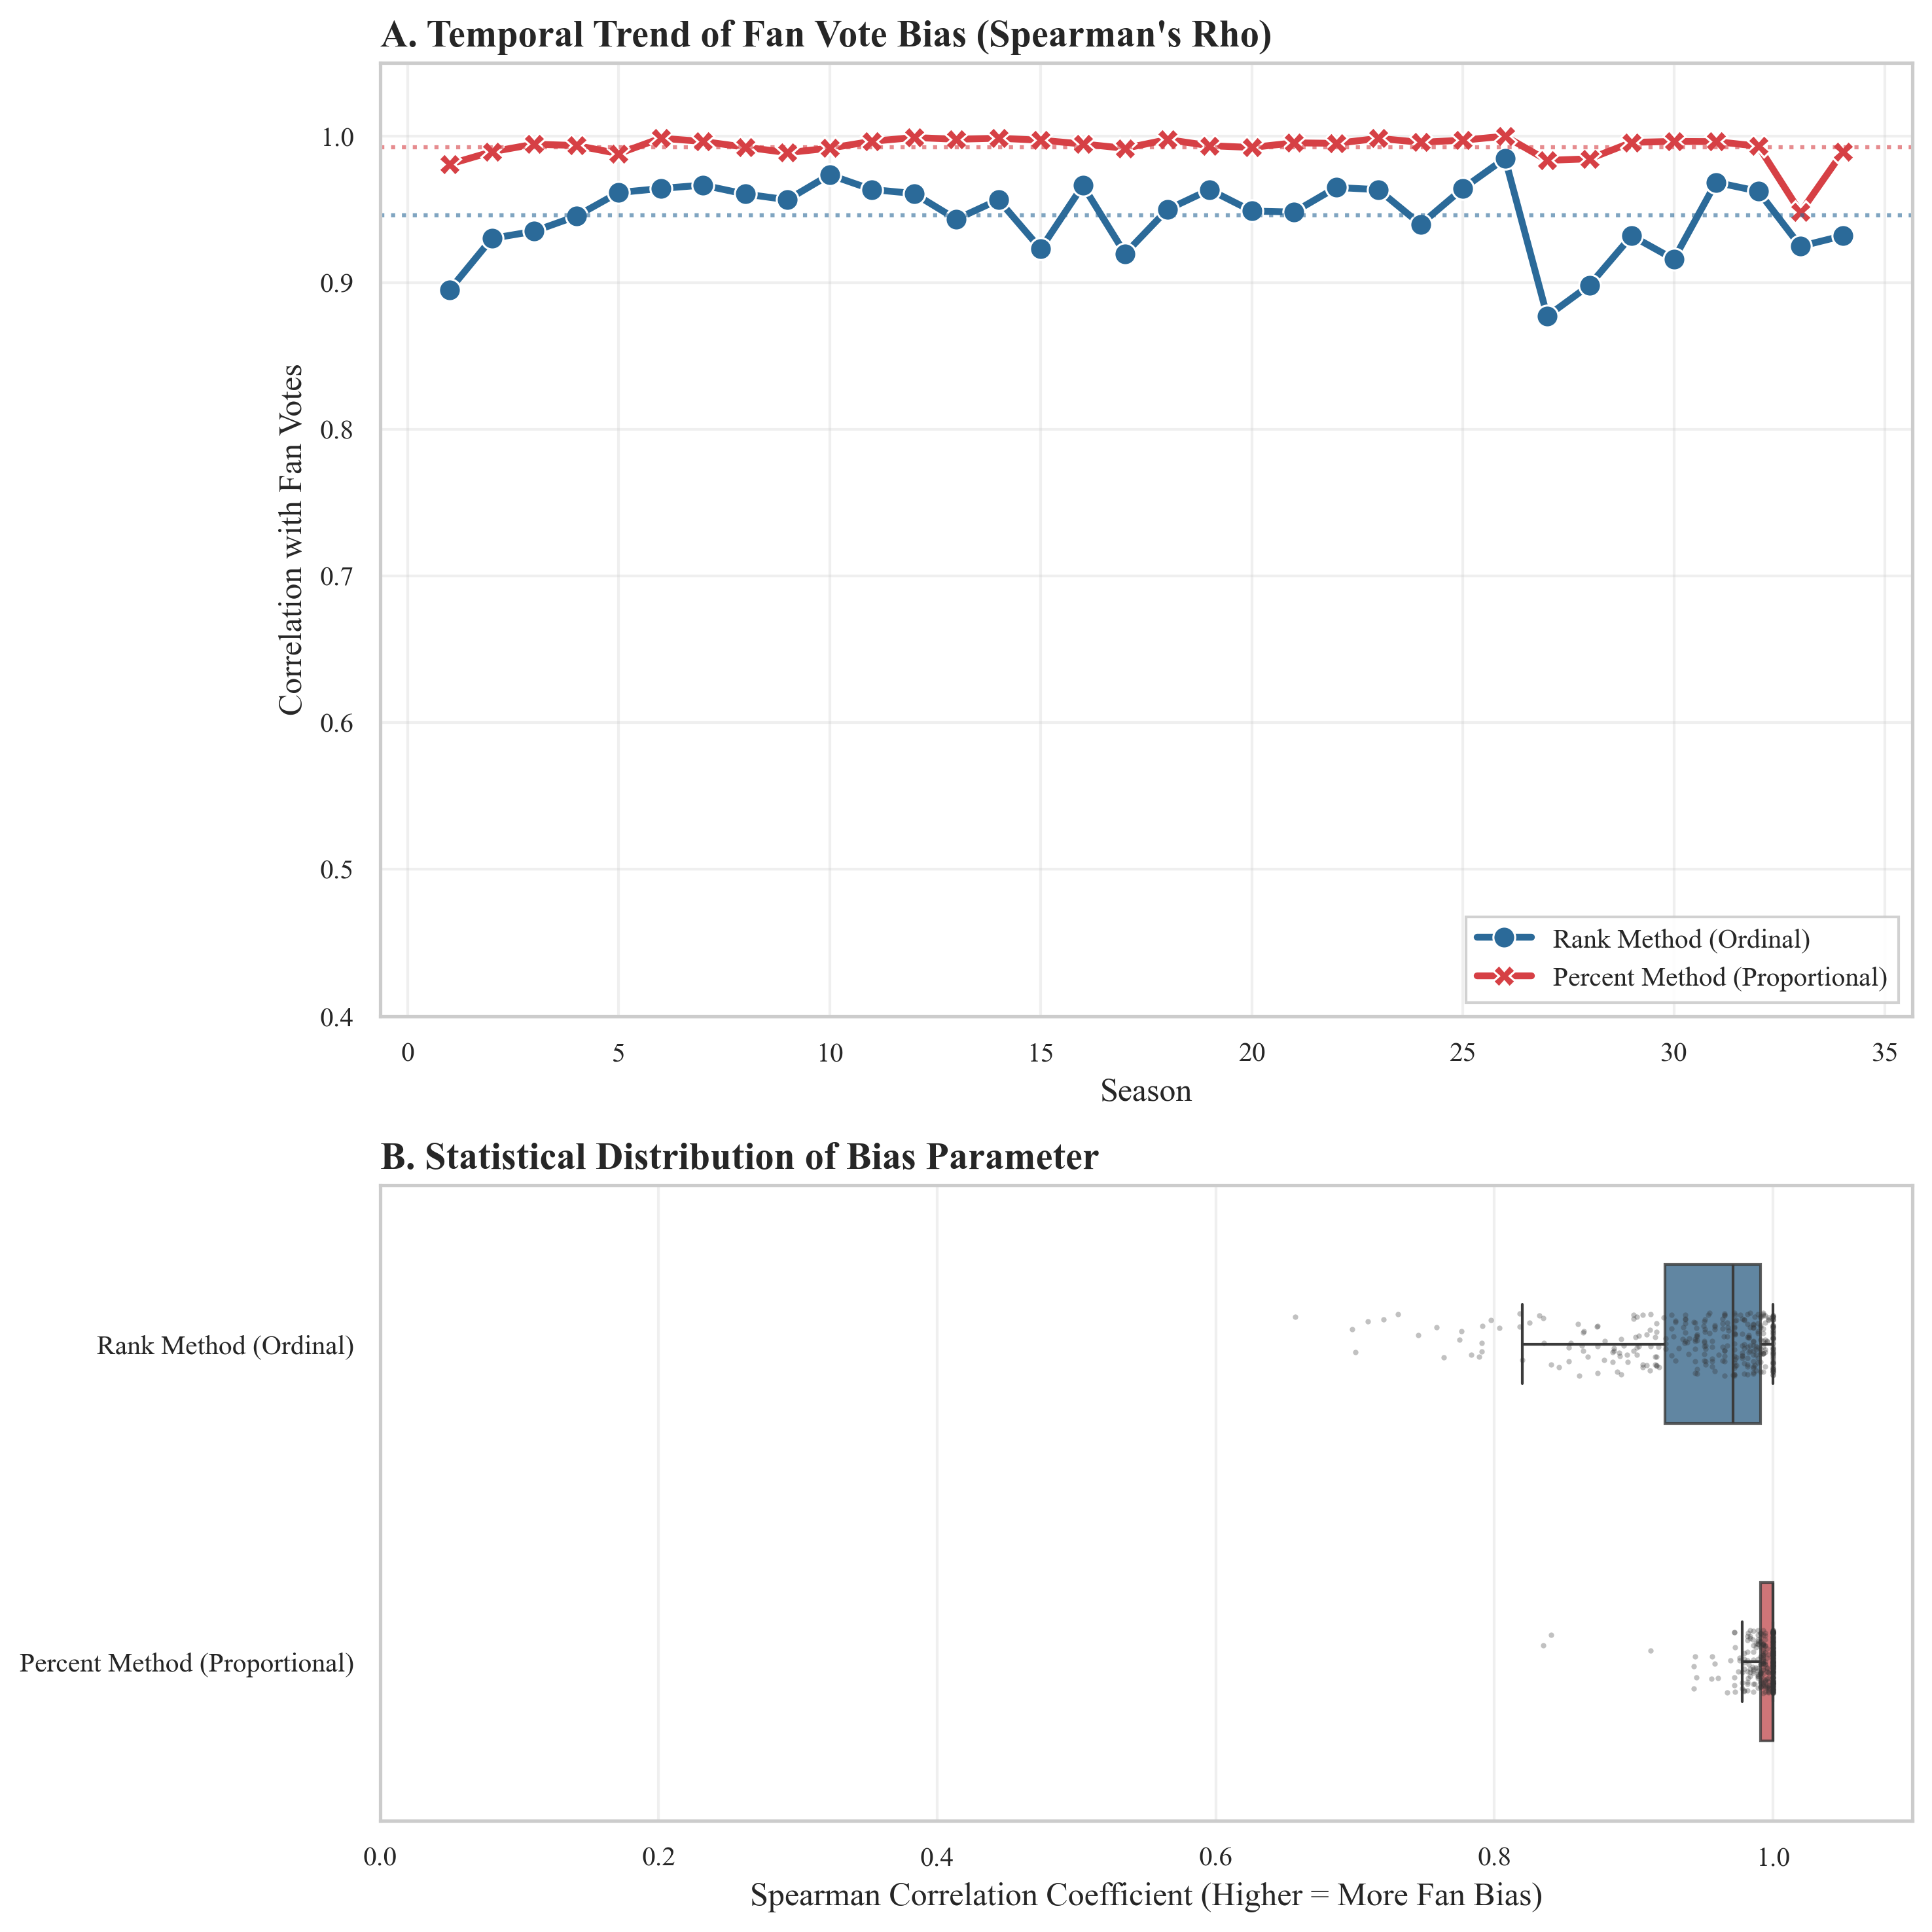

图表生成完毕。
图表解读: 红色曲线/箱体 (Percent Method) 如果位于蓝色 (Rank Method) 之上，
直观证明了 Percent 赛制与粉丝投票的相关性更强，即'偏向粉丝'。


In [8]:
# ==============================================================================
# Task 2 可视化扩展: 粉丝偏向性参数图表 (SCI Style Visualization)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bias_comparison_sci(df_analysis):
    """
    绘制两种赛制的斯皮尔曼相关系数对比图。
    包含：赛季趋势图 (Line Plot) 和 整体分布图 (Box Plot)。
    """
    if df_analysis is None or 'rho_rank_vs_fan' not in df_analysis.columns:
        print("错误: 数据集为空或缺少相关系数列，无法绘图。")
        return

    # 1. SCI 绘图风格设置
    sns.set_theme(style="whitegrid", rc={"axes.grid": True, "grid.alpha": 0.3})
    plt.rcParams.update({
        "font.family": "serif",              # 衬线字体
        "font.serif": ["Times New Roman"],   # 具体字体
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 300                    # 高分辨率
    })

    # 2. 数据准备
    # 聚合每个赛季的平均相关性
    season_trend = df_analysis.groupby('season')[['rho_rank_vs_fan', 'rho_pct_vs_fan']].mean().reset_index()
    
    # 转换成长格式 (Long Format) 以便绘图
    trend_melt = season_trend.melt('season', var_name='Method', value_name='Correlation')
    dist_melt = df_analysis.melt(id_vars=['season', 'week'], 
                                 value_vars=['rho_rank_vs_fan', 'rho_pct_vs_fan'], 
                                 var_name='Method', value_name='Correlation')
    
    # 标签映射优化
    label_map = {
        'rho_rank_vs_fan': 'Rank Method (Ordinal)',
        'rho_pct_vs_fan': 'Percent Method (Proportional)'
    }
    trend_melt['Method'] = trend_melt['Method'].map(label_map)
    dist_melt['Method'] = dist_melt['Method'].map(label_map)

    # 3. 创建画布 (2行1列)
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1.5, 1]})
    
    # --- 配色方案 (SCI 常用: 深蓝 vs 砖红) ---
    sci_colors = ["#2b6a99", "#d64045"]  # Blue, Red
    
    # --- 子图 1: 赛季趋势折线图 ---
    ax1 = axes[0]
    sns.lineplot(data=trend_melt, x='season', y='Correlation', hue='Method', style='Method',
                 markers=True, dashes=False, palette=sci_colors, linewidth=2.5, ax=ax1, markersize=8)
    
    ax1.set_title("A. Temporal Trend of Fan Vote Bias (Spearman's Rho)", loc='left', fontweight='bold')
    ax1.set_ylabel("Correlation with Fan Votes")
    ax1.set_xlabel("Season")
    ax1.set_ylim(0.4, 1.05)
    ax1.legend(loc='lower right', frameon=True, framealpha=0.9, fancybox=False)
    
    # 添加平均线
    overall_rank_mean = df_analysis['rho_rank_vs_fan'].mean()
    overall_pct_mean = df_analysis['rho_pct_vs_fan'].mean()
    ax1.axhline(overall_rank_mean, color=sci_colors[0], linestyle=':', alpha=0.6, linewidth=1.5)
    ax1.axhline(overall_pct_mean, color=sci_colors[1], linestyle=':', alpha=0.6, linewidth=1.5)
    
    # --- 子图 2: 整体分布箱线图 ---
    ax2 = axes[1]
    
    # 结合 Boxplot 和 Stripplot 显示分布细节
    sns.boxplot(data=dist_melt, x='Correlation', y='Method', palette=sci_colors, 
                width=0.5, fliersize=0, ax=ax2, boxprops=dict(alpha=.8))
    # 抖动点 (Jitter points) 显示原始数据密度
    sns.stripplot(data=dist_melt, x='Correlation', y='Method', color=".2", 
                  size=2, alpha=0.3, ax=ax2)
    
    ax2.set_title("B. Statistical Distribution of Bias Parameter", loc='left', fontweight='bold')
    ax2.set_xlabel("Spearman Correlation Coefficient (Higher = More Fan Bias)")
    ax2.set_ylabel("") # 移除 redundant label
    ax2.set_xlim(0, 1.1)

    # 4. 布局调整与保存
    plt.tight_layout()
    plt.show()
    print("图表生成完毕。")
    print(f"图表解读: 红色曲线/箱体 (Percent Method) 如果位于蓝色 (Rank Method) 之上，")
    print(f"直观证明了 Percent 赛制与粉丝投票的相关性更强，即'偏向粉丝'。")

# --- 调用绘图 ---
if __name__ == "__main__":
    # 确保使用上一步生成的 df_analysis (包含相关系数列)
    if 'df_analysis' in locals() and df_analysis is not None:
        plot_bias_comparison_sci(df_analysis)
    else:
        print("请先运行上一个代码块以生成 df_analysis 数据。")


In [10]:
import pandas as pd
import numpy as np
import re

path = "2026_MCM_Problem_C_Data.csv"
df = pd.read_csv(path)

# 1) 把淘汰后填的 0 分当作缺失
judge_score_cols = [c for c in df.columns if re.match(r"week\d+_judge\d+_score", c)]
df[judge_score_cols] = df[judge_score_cols].replace(0, np.nan)

# 2) 每周总分（4 位评委相加）
weeks = range(1, 12)  # week1..week11
for w in weeks:
    cols = [f"week{w}_judge{j}_score" for j in range(1, 5)]
    df[f"week{w}_total"] = df[cols].sum(axis=1, min_count=1)

total_cols = [f"week{w}_total" for w in weeks]

# 3) 评委“平均周总分”（只在有效周上求均值）
df["judge_avg_per_week"] = df[total_cols].mean(axis=1, skipna=True)

# 4) 计算每周“当周参赛者内”的评委排名百分位(0最好,1最差)，用于辅助解释
rank_frames = []
for w in weeks:
    col = f"week{w}_total"
    tmp = df[["season", "celebrity_name", col]].dropna(subset=[col]).copy()
    tmp["judge_rank"] = tmp.groupby("season")[col].rank(method="average", ascending=False)
    tmp["n_week"] = tmp.groupby("season")[col].transform("count")
    tmp["judge_pct"] = (tmp["judge_rank"] - 1) / (tmp["n_week"] - 1)
    tmp["week"] = w
    rank_frames.append(tmp[["season", "celebrity_name", "week", "judge_rank", "n_week", "judge_pct"]])

ranks = pd.concat(rank_frames, ignore_index=True)
ranks["last"] = ranks["judge_rank"] == ranks["n_week"]

stats = ranks.groupby(["season", "celebrity_name"]).agg(
    weeks=("week", "count"),
    avg_weekly_pct=("judge_pct", "mean"),
    last_weeks=("last", "sum"),
).reset_index()

# 5) 季内：用 judge_avg_per_week 得到“评委名次”
df["judge_avg_rank"] = df.groupby("season")["judge_avg_per_week"].rank(method="average", ascending=False)

base = df[["season", "celebrity_name", "placement", "results", "judge_avg_rank"]].drop_duplicates()
base = base.merge(stats, on=["season", "celebrity_name"], how="left")

# 6) 冲突判定：delta = 最终名次 - 评委名次
base["delta_rank"] = base["placement"] - base["judge_avg_rank"]

season_n = (base.groupby("season")["celebrity_name"]
            .nunique()
            .reset_index(name="season_total_competitors"))

base = base.merge(season_n, on="season", how="left")

k = 4
fans_support = base[base["delta_rank"] <= -k].sort_values(["delta_rank", "season"])  # 粉丝抬上去
fans_support.to_csv('fans_support.csv', index=False, encoding="utf-8-sig")
fans_against = base[base["delta_rank"] >=  k].sort_values(["delta_rank", "season"], ascending=[False, True])  # 粉丝压下去
fans_against.to_csv('fans_against.csv', index=False, encoding="utf-8-sig")

cols = ["season","celebrity_name","season_total_competitors","placement","judge_avg_rank","delta_rank","avg_weekly_pct","last_weeks","weeks","results"]
print("=== Fans support (judges low, final high) ===")
print(fans_support[cols].to_string(index=False))
print("\n=== Fans against (judges high, final low) ===")
print(fans_against[cols].to_string(index=False))


df1 = pd.read_csv('fans_support.csv')
df2 = pd.read_csv('fans_against.csv')

# 1) 校验表头完全一致
if list(df1.columns) != list(df2.columns):
    raise ValueError(f"Headers not identical.\nfile1: {list(df1.columns)}\nfile2: {list(df2.columns)}")

# 2) 合并（上下拼接）
merged = pd.concat([df1, df2], ignore_index=True)

# 3) 可选：去掉完全重复的行
merged = merged.drop_duplicates().reset_index(drop=True)

# 4) 保存
merged.to_csv("fans_merged.csv", index=False, encoding="utf-8-sig")

=== Fans support (judges low, final high) ===
 season   celebrity_name  season_total_competitors  placement  judge_avg_rank  delta_rank  avg_weekly_pct  last_weeks  weeks            results
     27      Bobby Bones                        13          1             8.0        -7.0        0.810772           2      9          1st Place
      7  Cloris Leachman                        13          7            12.0        -5.0        0.911706           3      6  Eliminated Week 6
     17     Bill Engvall                        12          4             9.0        -5.0        0.887534           6     11 Eliminated Week 11
     19  Michael Waltrip                        13          7            12.0        -5.0        0.916319           4      8  Eliminated Week 8
     21   Alek Skarlatos                        13          3             8.0        -5.0        0.682576           2     11          3rd Place
     27      Joe Amabile                        13          6            11.0        -5.0 

In [11]:
import pandas as pd

# 文件名定义
file_fans = 'fans_merged.csv'
file_sim = 'task2_simulation_results_v3.csv'
output_file = 'result_filtered.csv'

try:
    # 1. 读取 fans_merge.csv 并提取 season 列的唯一值
    df_fans = pd.read_csv(file_fans)
    target_seasons = df_fans['season'].unique()
    
    print(f"从 {file_fans} 中提取到 {len(target_seasons)} 个相关赛季。")
    # print(target_seasons) # 如果需要查看具体是哪些赛季，可以取消注释

    # 2. 读取 task2_simulation_results_v3.csv
    df_sim = pd.read_csv(file_sim)

    # 3. 进行双重筛选：
    # 条件 A: season 列的值必须包含在 target_seasons 中
    # 条件 B: type 列的值必须是 'Final'
    filtered_df = df_sim[
        (df_sim['season'].isin(target_seasons)) & 
        (df_sim['type'] == 'Final')
    ]

    # 4. 输出结果信息
    print(f"筛选完成。在 {file_sim} 中符合条件的行数: {len(filtered_df)}")
    print("前5行预览:")
    print(filtered_df.head())

    # 5. 保存结果到新文件 (可选)
    filtered_df.to_csv(output_file, index=False)
    print(f"结果已保存为: {output_file}")

except FileNotFoundError as e:
    print(f"错误: 找不到文件 {e.filename}，请确认文件路径正确。")
except KeyError as e:
    print(f"错误: 找不到列名 {e}，请检查CSV文件中的列名拼写（如 'season' 或 'type'）是否正确。")

从 fans_merged.csv 中提取到 18 个相关赛季。
筛选完成。在 task2_simulation_results_v3.csv 中符合条件的行数: 18
前5行预览:
    season  week   type  k_elim  is_rank_identical actual_elim sim_rank_elim  \
13       2     8  Final       0               True          []            []   
33       4    10  Final       0               True          []            []   
43       5    10  Final       0               True          []            []   
63       7    10  Final       0               True          []            []   
74       8    11  Final       0               True          []            []   

   sim_pct_elim  is_elim_diff    sim_rank_winner     sim_pct_winner  \
13           []         False        Drew Lachey        Drew Lachey   
33           []         False   Apolo Anton Ohno   Apolo Anton Ohno   
43           []         False  Helio Castroneves  Helio Castroneves   
63           []         False       Brooke Burke       Brooke Burke   
74           []         False      Shawn Johnson      Shawn Johnson   

